<a href="https://colab.research.google.com/github/KingNook/QCES/blob/main/Project4_storms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## Install Dedalus

# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:

        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3
  libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 41 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://arch

# Project 4: Storms
In this project, we will use Dedalus to solve the 2-layer quasi-geostrophic equations to model the development of atmospheric storm systems.

The two-layer quasi-geostrophic (QG) equations describe the motion of two vertically-stacked shallow layers of fluid in the limit where the Rossby number, $Ro=U/fL$ is small, where $U$ is a characteristic velocity scale, $L$ is a characteristic horizontal lengthscale, and $f$ is the Coriolis parameter. Here, we will use `1` to refer to quantitites in the upper layer and `2` to refer to quantities in the lower layer.

The fluid in the upper layer is lighter than the fluid in the lower layer (such that $\rho_1<\rho_2$). When the interface separating the upper and lower layers isn't flat, the varying thicknesses of the upper and lower layers implies that there are horizontal gradients in the hydrostatic pressure. When the Rossby number is small, $Ro\ll 1$, the flow will tend to be close to geostrophic balance a velocity difference between the upper and lower layer that balances the horizontal pressure gradients.

Student tasks are in [Section 1.5](#section1pt5), [Section 2.3](#section2pt3), and [Section 3.1](#section3pt1).

## 1. Two-layer quasi-geostrophic equations in a periodic box

In this section we will solve a non-dimensional version of the two-layer QG equations in Cartesian coordinates. Let $+x$ denote the eastwards direction and $+y$ denote the northwards direction. We start with a flow in geostrophic balance where the velocity is constant in each layer. Let $U \hat{\mathbf{x}}$ denote the velocity in the top layer and $-U \hat{\mathbf{x}}$ denote the velocity in the bottom layer. Geostrophic balance then implies that the interface has a constant, non-zero slope. We will invoke the so-called "beta-plane" approximation and make the Coriolis parameter a linear function of $y$.

In this section we solve for the departures to the background state described above. We let $q_1$ and $q_2$ denote the perturbation QG potential vorticity and $\psi_1$ and $\psi_2$ denote the perturbation streamfunction. Although the background state is not periodic, we apply periodic boundary conditions in $x$ and $y$ to the perturbation quantities. This has the effect of maintaining the north/south potential vorticity gradient associated with the background state.

### 1.1 Governing equations

The script below solves the following equations:

$$ \partial_t(q_1) + U \partial_x(q_1) + \frac{2U}{R_{d1}^2}\partial_x(\psi_1)-\nu \nabla^2 q_1 = - J(\psi_1, q_1), $$

$$ \partial_t(q_2) - U \partial_x(q_2) - \frac{2U}{R_{d2}^2}\partial_x(\psi_2)-\nu \nabla^2 q_2 = - J(\psi_2, q_2), $$

where $R_{d1,2}=\sqrt{g'H_{1,2}}/f_0$ is the internal deformation radius in each layer, $g'=(\rho_2-\rho_1)/\rho_0$ is the reduced gravity, $\rho_0$ is a reference density, $J(a,b)=\partial_x(a)\partial_y(b) - \partial_y(a)\partial_x(b)$ is the Jacobian operator and $\nu$ is a viscosity which is added to keep the model stable.

In addition to the equations above, two other equations relate the perturbation potential vorticity and streamfunctions:

$$q_1=\nabla^2\psi_1 - \frac{\psi_1-\psi_2}{R_{d1}^2}, $$
$$q_2=\nabla^2\psi_2 + \frac{\psi_1-\psi_2}{R_{d2}^2}. $$

### 1.2 Tau method

The equations above are invariant to a constant added to $\psi_1-\psi_2$. Therefore, there are infinitely many solutions to the above equations and the coefficient matrix associated with the discretized equations will be singular. To avoid this, we can add an extra equation to the system to set this constant offset. Here, we do this by including the following equation:

$$ \int\int \psi_1 dxdy = 0 $$

which in effect ensures that the spatial mean of $\psi_1$ is zero. The problem now is that we have five equations for four unknowns. One fix is to include another unknown in our system. We will include a constant called $\tau_{\psi1}$ and we will add it to the equation relating the upper layer QG potential voricity and streamfunction which then becomes:

$$q_1=\nabla^2\psi_1 - \frac{\psi_1-\psi_2}{R_{d1}^2} + \tau_{\psi1}. $$

Since adding a constant to the potential vorticity and streamfunction doesn't have any impact on the dynamics of the system, adding $\tau_{\psi1}$ here won't cause any problems and we now have a fully constained set of equations.


### 1.3 Dedalus script

The script below solves the 2-layer QG equations given above with non-dimensional parameters. Note that the velocity gets faster as the simulation progresses. If you find that the code blows up (returns NaNs and a white screen), try reducing the timestep.

In [3]:
# # Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 64 # Number of gridpoints in x
Ny = 64 # Number of gridpoints in y
Lx = 100 # Domain size in x
Ly = 100 # Domain size in y
Rd1 = 3 # Deformation radius in layer 1
Rd2 = 3 # Deformation radius in layer 2
U = 1 # Background velocity in layer 1

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu = 0.2

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/U/100 # This is just an estimate based on the background velocity
stop_sim_time = 100

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Set the initial conditions
q1.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
q2.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U*dx(q1) + (2*U/Rd1**2.0)*dx(psi1) - nu*lap(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) - U*dx(q2) - (2*U/Rd2**2.0)*dx(psi2) - nu*lap(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")

problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK443)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];
t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)

INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 3s, Rate: 1.0e+01/s


2025-12-05 11:27:58,613 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 3s, Rate: 1.0e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 2s, Rate: 1.9e+01/s


2025-12-05 11:27:58,730 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 2s, Rate: 1.9e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 2.3e+01/s


2025-12-05 11:27:58,870 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 2.3e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 2.4e+01/s


2025-12-05 11:27:59,010 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 2.4e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.4e+01/s


2025-12-05 11:27:59,176 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.4e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.3e+01/s


2025-12-05 11:27:59,391 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.3e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 2.1e+01/s


2025-12-05 11:27:59,665 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 2.1e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+01/s


2025-12-05 11:27:59,895 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 1.8e+01/s


2025-12-05 11:28:00,250 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 1.8e+01/s


INFO:__main__:Starting main loop


2025-12-05 11:28:00,408 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e-03, dt=7.812500e-03


2025-12-05 11:28:01,324 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e-03, dt=7.812500e-03


INFO:__main__:Iteration=11, Time=8.593750e-02, dt=7.812500e-03


2025-12-05 11:28:01,809 __main__ 0/1 INFO :: Iteration=11, Time=8.593750e-02, dt=7.812500e-03


INFO:__main__:Iteration=21, Time=1.640625e-01, dt=7.812500e-03


2025-12-05 11:28:02,493 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e-01, dt=7.812500e-03


INFO:__main__:Iteration=31, Time=2.421875e-01, dt=7.812500e-03


2025-12-05 11:28:03,021 __main__ 0/1 INFO :: Iteration=31, Time=2.421875e-01, dt=7.812500e-03


INFO:__main__:Iteration=41, Time=3.203125e-01, dt=7.812500e-03


2025-12-05 11:28:03,623 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e-01, dt=7.812500e-03


INFO:__main__:Iteration=51, Time=3.984375e-01, dt=7.812500e-03


2025-12-05 11:28:04,304 __main__ 0/1 INFO :: Iteration=51, Time=3.984375e-01, dt=7.812500e-03


INFO:__main__:Iteration=61, Time=4.765625e-01, dt=7.812500e-03


2025-12-05 11:28:04,778 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e-01, dt=7.812500e-03


INFO:__main__:Iteration=71, Time=5.546875e-01, dt=7.812500e-03


2025-12-05 11:28:05,173 __main__ 0/1 INFO :: Iteration=71, Time=5.546875e-01, dt=7.812500e-03


INFO:__main__:Iteration=81, Time=6.328125e-01, dt=7.812500e-03


2025-12-05 11:28:05,728 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e-01, dt=7.812500e-03


INFO:__main__:Iteration=91, Time=7.109375e-01, dt=7.812500e-03


2025-12-05 11:28:06,136 __main__ 0/1 INFO :: Iteration=91, Time=7.109375e-01, dt=7.812500e-03


INFO:__main__:Iteration=101, Time=7.890625e-01, dt=7.812500e-03


2025-12-05 11:28:06,651 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e-01, dt=7.812500e-03


INFO:__main__:Iteration=111, Time=8.671875e-01, dt=7.812500e-03


2025-12-05 11:28:07,319 __main__ 0/1 INFO :: Iteration=111, Time=8.671875e-01, dt=7.812500e-03


INFO:__main__:Iteration=121, Time=9.453125e-01, dt=7.812500e-03


2025-12-05 11:28:07,782 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e-01, dt=7.812500e-03


INFO:__main__:Iteration=131, Time=1.023438e+00, dt=7.812500e-03


2025-12-05 11:28:08,586 __main__ 0/1 INFO :: Iteration=131, Time=1.023438e+00, dt=7.812500e-03


INFO:__main__:Iteration=141, Time=1.101562e+00, dt=7.812500e-03


2025-12-05 11:28:09,462 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+00, dt=7.812500e-03


INFO:__main__:Iteration=151, Time=1.179688e+00, dt=7.812500e-03


2025-12-05 11:28:10,262 __main__ 0/1 INFO :: Iteration=151, Time=1.179688e+00, dt=7.812500e-03


INFO:__main__:Iteration=161, Time=1.257812e+00, dt=7.812500e-03


2025-12-05 11:28:10,487 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+00, dt=7.812500e-03


INFO:__main__:Iteration=171, Time=1.335938e+00, dt=7.812500e-03


2025-12-05 11:28:10,714 __main__ 0/1 INFO :: Iteration=171, Time=1.335938e+00, dt=7.812500e-03


INFO:__main__:Iteration=181, Time=1.414062e+00, dt=7.812500e-03


2025-12-05 11:28:10,950 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+00, dt=7.812500e-03


INFO:__main__:Iteration=191, Time=1.492188e+00, dt=7.812500e-03


2025-12-05 11:28:11,315 __main__ 0/1 INFO :: Iteration=191, Time=1.492188e+00, dt=7.812500e-03


INFO:__main__:Iteration=201, Time=1.570312e+00, dt=7.812500e-03


2025-12-05 11:28:11,688 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+00, dt=7.812500e-03


INFO:__main__:Iteration=211, Time=1.648438e+00, dt=7.812500e-03


2025-12-05 11:28:12,044 __main__ 0/1 INFO :: Iteration=211, Time=1.648438e+00, dt=7.812500e-03


INFO:__main__:Iteration=221, Time=1.726562e+00, dt=7.812500e-03


2025-12-05 11:28:12,386 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+00, dt=7.812500e-03


INFO:__main__:Iteration=231, Time=1.804688e+00, dt=7.812500e-03


2025-12-05 11:28:12,719 __main__ 0/1 INFO :: Iteration=231, Time=1.804688e+00, dt=7.812500e-03


INFO:__main__:Iteration=241, Time=1.882812e+00, dt=7.812500e-03


2025-12-05 11:28:13,086 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+00, dt=7.812500e-03


INFO:__main__:Iteration=251, Time=1.960938e+00, dt=7.812500e-03


2025-12-05 11:28:13,457 __main__ 0/1 INFO :: Iteration=251, Time=1.960938e+00, dt=7.812500e-03


INFO:__main__:Iteration=261, Time=2.039062e+00, dt=7.812500e-03


2025-12-05 11:28:13,775 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+00, dt=7.812500e-03


INFO:__main__:Iteration=271, Time=2.117188e+00, dt=7.812500e-03


2025-12-05 11:28:13,991 __main__ 0/1 INFO :: Iteration=271, Time=2.117188e+00, dt=7.812500e-03


INFO:__main__:Iteration=281, Time=2.195312e+00, dt=7.812500e-03


2025-12-05 11:28:14,240 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+00, dt=7.812500e-03


INFO:__main__:Iteration=291, Time=2.273438e+00, dt=7.812500e-03


2025-12-05 11:28:14,462 __main__ 0/1 INFO :: Iteration=291, Time=2.273438e+00, dt=7.812500e-03


INFO:__main__:Iteration=301, Time=2.351562e+00, dt=7.812500e-03


2025-12-05 11:28:14,694 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+00, dt=7.812500e-03


INFO:__main__:Iteration=311, Time=2.429688e+00, dt=7.812500e-03


2025-12-05 11:28:14,914 __main__ 0/1 INFO :: Iteration=311, Time=2.429688e+00, dt=7.812500e-03


INFO:__main__:Iteration=321, Time=2.507812e+00, dt=7.812500e-03


2025-12-05 11:28:15,140 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+00, dt=7.812500e-03


INFO:__main__:Iteration=331, Time=2.585938e+00, dt=7.812500e-03


2025-12-05 11:28:15,373 __main__ 0/1 INFO :: Iteration=331, Time=2.585938e+00, dt=7.812500e-03


INFO:__main__:Iteration=341, Time=2.664062e+00, dt=7.812500e-03


2025-12-05 11:28:15,593 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+00, dt=7.812500e-03


INFO:__main__:Iteration=351, Time=2.742188e+00, dt=7.812500e-03


2025-12-05 11:28:15,822 __main__ 0/1 INFO :: Iteration=351, Time=2.742188e+00, dt=7.812500e-03


INFO:__main__:Iteration=361, Time=2.820312e+00, dt=7.812500e-03


2025-12-05 11:28:16,086 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+00, dt=7.812500e-03


INFO:__main__:Iteration=371, Time=2.898438e+00, dt=7.812500e-03


2025-12-05 11:28:16,325 __main__ 0/1 INFO :: Iteration=371, Time=2.898438e+00, dt=7.812500e-03


INFO:__main__:Iteration=381, Time=2.976562e+00, dt=7.812500e-03


2025-12-05 11:28:16,547 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+00, dt=7.812500e-03


INFO:__main__:Iteration=391, Time=3.054688e+00, dt=7.812500e-03


2025-12-05 11:28:16,786 __main__ 0/1 INFO :: Iteration=391, Time=3.054688e+00, dt=7.812500e-03


INFO:__main__:Iteration=401, Time=3.132812e+00, dt=7.812500e-03


2025-12-05 11:28:17,007 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+00, dt=7.812500e-03


INFO:__main__:Iteration=411, Time=3.210938e+00, dt=7.812500e-03


2025-12-05 11:28:17,245 __main__ 0/1 INFO :: Iteration=411, Time=3.210938e+00, dt=7.812500e-03


INFO:__main__:Iteration=421, Time=3.289062e+00, dt=7.812500e-03


2025-12-05 11:28:17,469 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+00, dt=7.812500e-03


INFO:__main__:Iteration=431, Time=3.367188e+00, dt=7.812500e-03


2025-12-05 11:28:17,693 __main__ 0/1 INFO :: Iteration=431, Time=3.367188e+00, dt=7.812500e-03


INFO:__main__:Iteration=441, Time=3.445312e+00, dt=7.812500e-03


2025-12-05 11:28:17,917 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+00, dt=7.812500e-03


INFO:__main__:Iteration=451, Time=3.523438e+00, dt=7.812500e-03


2025-12-05 11:28:18,141 __main__ 0/1 INFO :: Iteration=451, Time=3.523438e+00, dt=7.812500e-03


INFO:__main__:Iteration=461, Time=3.601562e+00, dt=7.812500e-03


2025-12-05 11:28:18,375 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+00, dt=7.812500e-03


INFO:__main__:Iteration=471, Time=3.679688e+00, dt=7.812500e-03


2025-12-05 11:28:18,598 __main__ 0/1 INFO :: Iteration=471, Time=3.679688e+00, dt=7.812500e-03


INFO:__main__:Iteration=481, Time=3.757812e+00, dt=7.812500e-03


2025-12-05 11:28:18,819 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+00, dt=7.812500e-03


INFO:__main__:Iteration=491, Time=3.835938e+00, dt=7.812500e-03


2025-12-05 11:28:19,044 __main__ 0/1 INFO :: Iteration=491, Time=3.835938e+00, dt=7.812500e-03


INFO:__main__:Iteration=501, Time=3.914062e+00, dt=7.812500e-03


2025-12-05 11:28:19,274 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+00, dt=7.812500e-03


INFO:__main__:Iteration=511, Time=3.992188e+00, dt=7.812500e-03


2025-12-05 11:28:19,510 __main__ 0/1 INFO :: Iteration=511, Time=3.992188e+00, dt=7.812500e-03


INFO:__main__:Iteration=521, Time=4.070312e+00, dt=7.812500e-03


2025-12-05 11:28:19,736 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+00, dt=7.812500e-03


INFO:__main__:Iteration=531, Time=4.148438e+00, dt=7.812500e-03


2025-12-05 11:28:19,958 __main__ 0/1 INFO :: Iteration=531, Time=4.148438e+00, dt=7.812500e-03


INFO:__main__:Iteration=541, Time=4.226562e+00, dt=7.812500e-03


2025-12-05 11:28:20,182 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+00, dt=7.812500e-03


INFO:__main__:Iteration=551, Time=4.304688e+00, dt=7.812500e-03


2025-12-05 11:28:20,412 __main__ 0/1 INFO :: Iteration=551, Time=4.304688e+00, dt=7.812500e-03


INFO:__main__:Iteration=561, Time=4.382812e+00, dt=7.812500e-03


2025-12-05 11:28:20,651 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+00, dt=7.812500e-03


INFO:__main__:Iteration=571, Time=4.460938e+00, dt=7.812500e-03


2025-12-05 11:28:20,874 __main__ 0/1 INFO :: Iteration=571, Time=4.460938e+00, dt=7.812500e-03


INFO:__main__:Iteration=581, Time=4.539062e+00, dt=7.812500e-03


2025-12-05 11:28:21,088 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+00, dt=7.812500e-03


INFO:__main__:Iteration=591, Time=4.617188e+00, dt=7.812500e-03


2025-12-05 11:28:21,307 __main__ 0/1 INFO :: Iteration=591, Time=4.617188e+00, dt=7.812500e-03


INFO:__main__:Iteration=601, Time=4.695312e+00, dt=7.812500e-03


2025-12-05 11:28:21,545 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+00, dt=7.812500e-03


INFO:__main__:Iteration=611, Time=4.773438e+00, dt=7.812500e-03


2025-12-05 11:28:21,773 __main__ 0/1 INFO :: Iteration=611, Time=4.773438e+00, dt=7.812500e-03


INFO:__main__:Iteration=621, Time=4.851562e+00, dt=7.812500e-03


2025-12-05 11:28:21,986 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+00, dt=7.812500e-03


INFO:__main__:Iteration=631, Time=4.929688e+00, dt=7.812500e-03


2025-12-05 11:28:22,213 __main__ 0/1 INFO :: Iteration=631, Time=4.929688e+00, dt=7.812500e-03


INFO:__main__:Iteration=641, Time=5.007812e+00, dt=7.812500e-03


2025-12-05 11:28:22,450 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+00, dt=7.812500e-03


INFO:__main__:Iteration=651, Time=5.085938e+00, dt=7.812500e-03


2025-12-05 11:28:22,674 __main__ 0/1 INFO :: Iteration=651, Time=5.085938e+00, dt=7.812500e-03


INFO:__main__:Iteration=661, Time=5.164062e+00, dt=7.812500e-03


2025-12-05 11:28:22,895 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+00, dt=7.812500e-03


INFO:__main__:Iteration=671, Time=5.242188e+00, dt=7.812500e-03


2025-12-05 11:28:23,114 __main__ 0/1 INFO :: Iteration=671, Time=5.242188e+00, dt=7.812500e-03


INFO:__main__:Iteration=681, Time=5.320312e+00, dt=7.812500e-03


2025-12-05 11:28:23,331 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+00, dt=7.812500e-03


INFO:__main__:Iteration=691, Time=5.398438e+00, dt=7.812500e-03


2025-12-05 11:28:23,568 __main__ 0/1 INFO :: Iteration=691, Time=5.398438e+00, dt=7.812500e-03


INFO:__main__:Iteration=701, Time=5.476562e+00, dt=7.812500e-03


2025-12-05 11:28:23,877 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+00, dt=7.812500e-03


INFO:__main__:Iteration=711, Time=5.554688e+00, dt=7.812500e-03


2025-12-05 11:28:24,236 __main__ 0/1 INFO :: Iteration=711, Time=5.554688e+00, dt=7.812500e-03


INFO:__main__:Iteration=721, Time=5.632812e+00, dt=7.812500e-03


2025-12-05 11:28:24,656 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+00, dt=7.812500e-03


INFO:__main__:Iteration=731, Time=5.710938e+00, dt=7.812500e-03


2025-12-05 11:28:24,996 __main__ 0/1 INFO :: Iteration=731, Time=5.710938e+00, dt=7.812500e-03


INFO:__main__:Iteration=741, Time=5.789062e+00, dt=7.812500e-03


2025-12-05 11:28:25,380 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+00, dt=7.812500e-03


INFO:__main__:Iteration=751, Time=5.867188e+00, dt=7.812500e-03


2025-12-05 11:28:25,760 __main__ 0/1 INFO :: Iteration=751, Time=5.867188e+00, dt=7.812500e-03


INFO:__main__:Iteration=761, Time=5.945312e+00, dt=7.812500e-03


2025-12-05 11:28:26,116 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+00, dt=7.812500e-03


INFO:__main__:Iteration=771, Time=6.023438e+00, dt=7.812500e-03


2025-12-05 11:28:26,449 __main__ 0/1 INFO :: Iteration=771, Time=6.023438e+00, dt=7.812500e-03


INFO:__main__:Iteration=781, Time=6.101562e+00, dt=7.812500e-03


2025-12-05 11:28:26,677 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+00, dt=7.812500e-03


INFO:__main__:Iteration=791, Time=6.179688e+00, dt=7.812500e-03


2025-12-05 11:28:26,906 __main__ 0/1 INFO :: Iteration=791, Time=6.179688e+00, dt=7.812500e-03


INFO:__main__:Iteration=801, Time=6.257812e+00, dt=7.812500e-03


2025-12-05 11:28:27,123 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+00, dt=7.812500e-03


INFO:__main__:Iteration=811, Time=6.335938e+00, dt=7.812500e-03


2025-12-05 11:28:27,336 __main__ 0/1 INFO :: Iteration=811, Time=6.335938e+00, dt=7.812500e-03


INFO:__main__:Iteration=821, Time=6.414062e+00, dt=7.812500e-03


2025-12-05 11:28:27,547 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+00, dt=7.812500e-03


INFO:__main__:Iteration=831, Time=6.492188e+00, dt=7.812500e-03


2025-12-05 11:28:27,792 __main__ 0/1 INFO :: Iteration=831, Time=6.492188e+00, dt=7.812500e-03


INFO:__main__:Iteration=841, Time=6.570312e+00, dt=7.812500e-03


2025-12-05 11:28:28,019 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+00, dt=7.812500e-03


INFO:__main__:Iteration=851, Time=6.648438e+00, dt=7.812500e-03


2025-12-05 11:28:28,247 __main__ 0/1 INFO :: Iteration=851, Time=6.648438e+00, dt=7.812500e-03


INFO:__main__:Iteration=861, Time=6.726562e+00, dt=7.812500e-03


2025-12-05 11:28:28,463 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+00, dt=7.812500e-03


INFO:__main__:Iteration=871, Time=6.804688e+00, dt=7.812500e-03


2025-12-05 11:28:28,688 __main__ 0/1 INFO :: Iteration=871, Time=6.804688e+00, dt=7.812500e-03


INFO:__main__:Iteration=881, Time=6.882812e+00, dt=7.812500e-03


2025-12-05 11:28:28,929 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+00, dt=7.812500e-03


INFO:__main__:Iteration=891, Time=6.960938e+00, dt=7.812500e-03


2025-12-05 11:28:29,153 __main__ 0/1 INFO :: Iteration=891, Time=6.960938e+00, dt=7.812500e-03


INFO:__main__:Iteration=901, Time=7.039062e+00, dt=7.812500e-03


2025-12-05 11:28:29,371 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+00, dt=7.812500e-03


INFO:__main__:Iteration=911, Time=7.117188e+00, dt=7.812500e-03


2025-12-05 11:28:29,597 __main__ 0/1 INFO :: Iteration=911, Time=7.117188e+00, dt=7.812500e-03


INFO:__main__:Iteration=921, Time=7.195312e+00, dt=7.812500e-03


2025-12-05 11:28:29,845 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+00, dt=7.812500e-03


INFO:__main__:Iteration=931, Time=7.273438e+00, dt=7.812500e-03


2025-12-05 11:28:30,068 __main__ 0/1 INFO :: Iteration=931, Time=7.273438e+00, dt=7.812500e-03


INFO:__main__:Iteration=941, Time=7.351562e+00, dt=7.812500e-03


2025-12-05 11:28:30,297 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+00, dt=7.812500e-03


INFO:__main__:Iteration=951, Time=7.429688e+00, dt=7.812500e-03


2025-12-05 11:28:30,514 __main__ 0/1 INFO :: Iteration=951, Time=7.429688e+00, dt=7.812500e-03


INFO:__main__:Iteration=961, Time=7.507812e+00, dt=7.812500e-03


2025-12-05 11:28:30,740 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+00, dt=7.812500e-03


INFO:__main__:Iteration=971, Time=7.585938e+00, dt=7.812500e-03


2025-12-05 11:28:30,976 __main__ 0/1 INFO :: Iteration=971, Time=7.585938e+00, dt=7.812500e-03


INFO:__main__:Iteration=981, Time=7.664062e+00, dt=7.812500e-03


2025-12-05 11:28:31,202 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+00, dt=7.812500e-03


INFO:__main__:Iteration=991, Time=7.742188e+00, dt=7.812500e-03


2025-12-05 11:28:31,414 __main__ 0/1 INFO :: Iteration=991, Time=7.742188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1001, Time=7.820312e+00, dt=7.812500e-03


2025-12-05 11:28:31,631 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1011, Time=7.898438e+00, dt=7.812500e-03


2025-12-05 11:28:31,859 __main__ 0/1 INFO :: Iteration=1011, Time=7.898438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1021, Time=7.976562e+00, dt=7.812500e-03


2025-12-05 11:28:32,090 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1031, Time=8.054688e+00, dt=7.812500e-03


2025-12-05 11:28:32,310 __main__ 0/1 INFO :: Iteration=1031, Time=8.054688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1041, Time=8.132812e+00, dt=7.812500e-03


2025-12-05 11:28:32,530 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+00, dt=7.812500e-03


INFO:__main__:Iteration=1051, Time=8.210938e+00, dt=7.812500e-03


2025-12-05 11:28:32,754 __main__ 0/1 INFO :: Iteration=1051, Time=8.210938e+00, dt=7.812500e-03


INFO:__main__:Iteration=1061, Time=8.289062e+00, dt=7.812500e-03


2025-12-05 11:28:32,989 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+00, dt=7.812500e-03


INFO:__main__:Iteration=1071, Time=8.367188e+00, dt=7.812500e-03


2025-12-05 11:28:33,214 __main__ 0/1 INFO :: Iteration=1071, Time=8.367188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1081, Time=8.445312e+00, dt=7.812500e-03


2025-12-05 11:28:33,428 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1091, Time=8.523438e+00, dt=7.812500e-03


2025-12-05 11:28:33,650 __main__ 0/1 INFO :: Iteration=1091, Time=8.523438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1101, Time=8.601562e+00, dt=7.812500e-03


2025-12-05 11:28:33,880 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1111, Time=8.679688e+00, dt=7.812500e-03


2025-12-05 11:28:34,111 __main__ 0/1 INFO :: Iteration=1111, Time=8.679688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1121, Time=8.757812e+00, dt=7.812500e-03


2025-12-05 11:28:34,331 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+00, dt=7.812500e-03


INFO:__main__:Iteration=1131, Time=8.835938e+00, dt=7.812500e-03


2025-12-05 11:28:34,556 __main__ 0/1 INFO :: Iteration=1131, Time=8.835938e+00, dt=7.812500e-03


INFO:__main__:Iteration=1141, Time=8.914062e+00, dt=7.812500e-03


2025-12-05 11:28:34,777 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+00, dt=7.812500e-03


INFO:__main__:Iteration=1151, Time=8.992188e+00, dt=7.812500e-03


2025-12-05 11:28:35,003 __main__ 0/1 INFO :: Iteration=1151, Time=8.992188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1161, Time=9.070312e+00, dt=7.812500e-03


2025-12-05 11:28:35,232 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1171, Time=9.148438e+00, dt=7.812500e-03


2025-12-05 11:28:35,470 __main__ 0/1 INFO :: Iteration=1171, Time=9.148438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1181, Time=9.226562e+00, dt=7.812500e-03


2025-12-05 11:28:35,692 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1191, Time=9.304688e+00, dt=7.812500e-03


2025-12-05 11:28:35,914 __main__ 0/1 INFO :: Iteration=1191, Time=9.304688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1201, Time=9.382812e+00, dt=7.812500e-03


2025-12-05 11:28:36,161 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+00, dt=7.812500e-03


INFO:__main__:Iteration=1211, Time=9.460938e+00, dt=7.812500e-03


2025-12-05 11:28:36,382 __main__ 0/1 INFO :: Iteration=1211, Time=9.460938e+00, dt=7.812500e-03


INFO:__main__:Iteration=1221, Time=9.539062e+00, dt=7.812500e-03


2025-12-05 11:28:36,749 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+00, dt=7.812500e-03


INFO:__main__:Iteration=1231, Time=9.617188e+00, dt=7.812500e-03


2025-12-05 11:28:37,113 __main__ 0/1 INFO :: Iteration=1231, Time=9.617188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1241, Time=9.695312e+00, dt=7.812500e-03


2025-12-05 11:28:37,470 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1251, Time=9.773438e+00, dt=7.812500e-03


2025-12-05 11:28:37,817 __main__ 0/1 INFO :: Iteration=1251, Time=9.773438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1261, Time=9.851562e+00, dt=7.812500e-03


2025-12-05 11:28:38,158 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1271, Time=9.929688e+00, dt=7.812500e-03


2025-12-05 11:28:38,533 __main__ 0/1 INFO :: Iteration=1271, Time=9.929688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1281, Time=1.000781e+01, dt=7.812500e-03


2025-12-05 11:28:38,900 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1291, Time=1.008594e+01, dt=7.812500e-03


2025-12-05 11:28:39,208 __main__ 0/1 INFO :: Iteration=1291, Time=1.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1301, Time=1.016406e+01, dt=7.812500e-03


2025-12-05 11:28:39,445 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1311, Time=1.024219e+01, dt=7.812500e-03


2025-12-05 11:28:39,663 __main__ 0/1 INFO :: Iteration=1311, Time=1.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1321, Time=1.032031e+01, dt=7.812500e-03


2025-12-05 11:28:39,878 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1331, Time=1.039844e+01, dt=7.812500e-03


2025-12-05 11:28:40,124 __main__ 0/1 INFO :: Iteration=1331, Time=1.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1341, Time=1.047656e+01, dt=7.812500e-03


2025-12-05 11:28:40,362 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1351, Time=1.055469e+01, dt=7.812500e-03


2025-12-05 11:28:40,585 __main__ 0/1 INFO :: Iteration=1351, Time=1.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1361, Time=1.063281e+01, dt=7.812500e-03


2025-12-05 11:28:40,805 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1371, Time=1.071094e+01, dt=7.812500e-03


2025-12-05 11:28:41,027 __main__ 0/1 INFO :: Iteration=1371, Time=1.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1381, Time=1.078906e+01, dt=7.812500e-03


2025-12-05 11:28:41,247 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1391, Time=1.086719e+01, dt=7.812500e-03


2025-12-05 11:28:41,475 __main__ 0/1 INFO :: Iteration=1391, Time=1.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1401, Time=1.094531e+01, dt=7.812500e-03


2025-12-05 11:28:41,702 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1411, Time=1.102344e+01, dt=7.812500e-03


2025-12-05 11:28:41,926 __main__ 0/1 INFO :: Iteration=1411, Time=1.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1421, Time=1.110156e+01, dt=7.812500e-03


2025-12-05 11:28:42,151 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1431, Time=1.117969e+01, dt=7.812500e-03


2025-12-05 11:28:42,384 __main__ 0/1 INFO :: Iteration=1431, Time=1.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1441, Time=1.125781e+01, dt=7.812500e-03


2025-12-05 11:28:42,599 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1451, Time=1.133594e+01, dt=7.812500e-03


2025-12-05 11:28:42,825 __main__ 0/1 INFO :: Iteration=1451, Time=1.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1461, Time=1.141406e+01, dt=7.812500e-03


2025-12-05 11:28:43,040 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1471, Time=1.149219e+01, dt=7.812500e-03


2025-12-05 11:28:43,279 __main__ 0/1 INFO :: Iteration=1471, Time=1.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1481, Time=1.157031e+01, dt=7.812500e-03


2025-12-05 11:28:43,547 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1491, Time=1.164844e+01, dt=7.812500e-03


2025-12-05 11:28:43,780 __main__ 0/1 INFO :: Iteration=1491, Time=1.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1501, Time=1.172656e+01, dt=7.812500e-03


2025-12-05 11:28:44,006 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1511, Time=1.180469e+01, dt=7.812500e-03


2025-12-05 11:28:44,233 __main__ 0/1 INFO :: Iteration=1511, Time=1.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1521, Time=1.188281e+01, dt=7.812500e-03


2025-12-05 11:28:44,473 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1531, Time=1.196094e+01, dt=7.812500e-03


2025-12-05 11:28:44,703 __main__ 0/1 INFO :: Iteration=1531, Time=1.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1541, Time=1.203906e+01, dt=7.812500e-03


2025-12-05 11:28:44,928 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1551, Time=1.211719e+01, dt=7.812500e-03


2025-12-05 11:28:45,152 __main__ 0/1 INFO :: Iteration=1551, Time=1.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1561, Time=1.219531e+01, dt=7.812500e-03


2025-12-05 11:28:45,370 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1571, Time=1.227344e+01, dt=7.812500e-03


2025-12-05 11:28:45,601 __main__ 0/1 INFO :: Iteration=1571, Time=1.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1581, Time=1.235156e+01, dt=7.812500e-03


2025-12-05 11:28:45,821 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1591, Time=1.242969e+01, dt=7.812500e-03


2025-12-05 11:28:46,036 __main__ 0/1 INFO :: Iteration=1591, Time=1.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1601, Time=1.250781e+01, dt=7.812500e-03


2025-12-05 11:28:46,256 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1611, Time=1.258594e+01, dt=7.812500e-03


2025-12-05 11:28:46,469 __main__ 0/1 INFO :: Iteration=1611, Time=1.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1621, Time=1.266406e+01, dt=7.812500e-03


2025-12-05 11:28:46,709 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1631, Time=1.274219e+01, dt=7.812500e-03


2025-12-05 11:28:46,934 __main__ 0/1 INFO :: Iteration=1631, Time=1.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1641, Time=1.282031e+01, dt=7.812500e-03


2025-12-05 11:28:47,153 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1651, Time=1.289844e+01, dt=7.812500e-03


2025-12-05 11:28:47,363 __main__ 0/1 INFO :: Iteration=1651, Time=1.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1661, Time=1.297656e+01, dt=7.812500e-03


2025-12-05 11:28:47,599 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1671, Time=1.305469e+01, dt=7.812500e-03


2025-12-05 11:28:47,849 __main__ 0/1 INFO :: Iteration=1671, Time=1.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1681, Time=1.313281e+01, dt=7.812500e-03


2025-12-05 11:28:48,093 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1691, Time=1.321094e+01, dt=7.812500e-03


2025-12-05 11:28:48,315 __main__ 0/1 INFO :: Iteration=1691, Time=1.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1701, Time=1.328906e+01, dt=7.812500e-03


2025-12-05 11:28:48,533 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1711, Time=1.336719e+01, dt=7.812500e-03


2025-12-05 11:28:48,766 __main__ 0/1 INFO :: Iteration=1711, Time=1.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1721, Time=1.344531e+01, dt=7.812500e-03


2025-12-05 11:28:48,990 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1731, Time=1.352344e+01, dt=7.812500e-03


2025-12-05 11:28:49,280 __main__ 0/1 INFO :: Iteration=1731, Time=1.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1741, Time=1.360156e+01, dt=7.812500e-03


2025-12-05 11:28:49,634 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1751, Time=1.367969e+01, dt=7.812500e-03


2025-12-05 11:28:49,984 __main__ 0/1 INFO :: Iteration=1751, Time=1.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1761, Time=1.375781e+01, dt=7.812500e-03


2025-12-05 11:28:50,328 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1771, Time=1.383594e+01, dt=7.812500e-03


2025-12-05 11:28:50,660 __main__ 0/1 INFO :: Iteration=1771, Time=1.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1781, Time=1.391406e+01, dt=7.812500e-03


2025-12-05 11:28:51,004 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1791, Time=1.399219e+01, dt=7.812500e-03


2025-12-05 11:28:51,361 __main__ 0/1 INFO :: Iteration=1791, Time=1.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1801, Time=1.407031e+01, dt=7.812500e-03


2025-12-05 11:28:51,724 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1811, Time=1.414844e+01, dt=7.812500e-03


2025-12-05 11:28:52,047 __main__ 0/1 INFO :: Iteration=1811, Time=1.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1821, Time=1.422656e+01, dt=7.812500e-03


2025-12-05 11:28:52,269 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1831, Time=1.430469e+01, dt=7.812500e-03


2025-12-05 11:28:52,485 __main__ 0/1 INFO :: Iteration=1831, Time=1.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1841, Time=1.438281e+01, dt=7.812500e-03


2025-12-05 11:28:52,706 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1851, Time=1.446094e+01, dt=7.812500e-03


2025-12-05 11:28:52,952 __main__ 0/1 INFO :: Iteration=1851, Time=1.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1861, Time=1.453906e+01, dt=7.812500e-03


2025-12-05 11:28:53,192 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1871, Time=1.461719e+01, dt=7.812500e-03


2025-12-05 11:28:53,415 __main__ 0/1 INFO :: Iteration=1871, Time=1.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1881, Time=1.469531e+01, dt=7.812500e-03


2025-12-05 11:28:53,643 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1891, Time=1.477344e+01, dt=7.812500e-03


2025-12-05 11:28:53,880 __main__ 0/1 INFO :: Iteration=1891, Time=1.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1901, Time=1.485156e+01, dt=7.812500e-03


2025-12-05 11:28:54,129 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1911, Time=1.492969e+01, dt=7.812500e-03


2025-12-05 11:28:54,357 __main__ 0/1 INFO :: Iteration=1911, Time=1.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1921, Time=1.500781e+01, dt=7.812500e-03


2025-12-05 11:28:54,578 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1931, Time=1.508594e+01, dt=7.812500e-03


2025-12-05 11:28:54,803 __main__ 0/1 INFO :: Iteration=1931, Time=1.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1941, Time=1.516406e+01, dt=7.812500e-03


2025-12-05 11:28:55,044 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1951, Time=1.524219e+01, dt=7.812500e-03


2025-12-05 11:28:55,271 __main__ 0/1 INFO :: Iteration=1951, Time=1.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1961, Time=1.532031e+01, dt=7.812500e-03


2025-12-05 11:28:55,499 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1971, Time=1.539844e+01, dt=7.812500e-03


2025-12-05 11:28:55,732 __main__ 0/1 INFO :: Iteration=1971, Time=1.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1981, Time=1.547656e+01, dt=7.812500e-03


2025-12-05 11:28:55,992 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1991, Time=1.555469e+01, dt=7.812500e-03


2025-12-05 11:28:56,267 __main__ 0/1 INFO :: Iteration=1991, Time=1.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2001, Time=1.563281e+01, dt=7.812500e-03


2025-12-05 11:28:56,501 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2011, Time=1.571094e+01, dt=7.812500e-03


2025-12-05 11:28:56,732 __main__ 0/1 INFO :: Iteration=2011, Time=1.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2021, Time=1.578906e+01, dt=7.812500e-03


2025-12-05 11:28:56,958 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2031, Time=1.586719e+01, dt=7.812500e-03


2025-12-05 11:28:57,196 __main__ 0/1 INFO :: Iteration=2031, Time=1.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2041, Time=1.594531e+01, dt=7.812500e-03


2025-12-05 11:28:57,409 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2051, Time=1.602344e+01, dt=7.812500e-03


2025-12-05 11:28:57,630 __main__ 0/1 INFO :: Iteration=2051, Time=1.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2061, Time=1.610156e+01, dt=7.812500e-03


2025-12-05 11:28:57,859 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2071, Time=1.617969e+01, dt=7.812500e-03


2025-12-05 11:28:58,079 __main__ 0/1 INFO :: Iteration=2071, Time=1.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2081, Time=1.625781e+01, dt=7.812500e-03


2025-12-05 11:28:58,316 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2091, Time=1.633594e+01, dt=7.812500e-03


2025-12-05 11:28:58,538 __main__ 0/1 INFO :: Iteration=2091, Time=1.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2101, Time=1.641406e+01, dt=7.812500e-03


2025-12-05 11:28:58,766 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2111, Time=1.649219e+01, dt=7.812500e-03


2025-12-05 11:28:58,994 __main__ 0/1 INFO :: Iteration=2111, Time=1.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2121, Time=1.657031e+01, dt=7.812500e-03


2025-12-05 11:28:59,232 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2131, Time=1.664844e+01, dt=7.812500e-03


2025-12-05 11:28:59,458 __main__ 0/1 INFO :: Iteration=2131, Time=1.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2141, Time=1.672656e+01, dt=7.812500e-03


2025-12-05 11:28:59,703 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2151, Time=1.680469e+01, dt=7.812500e-03


2025-12-05 11:28:59,938 __main__ 0/1 INFO :: Iteration=2151, Time=1.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2161, Time=1.688281e+01, dt=7.812500e-03


2025-12-05 11:29:00,170 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2171, Time=1.696094e+01, dt=7.812500e-03


2025-12-05 11:29:00,408 __main__ 0/1 INFO :: Iteration=2171, Time=1.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2181, Time=1.703906e+01, dt=7.812500e-03


2025-12-05 11:29:00,636 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2191, Time=1.711719e+01, dt=7.812500e-03


2025-12-05 11:29:00,865 __main__ 0/1 INFO :: Iteration=2191, Time=1.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2201, Time=1.719531e+01, dt=7.812500e-03


2025-12-05 11:29:01,104 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2211, Time=1.727344e+01, dt=7.812500e-03


2025-12-05 11:29:01,350 __main__ 0/1 INFO :: Iteration=2211, Time=1.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2221, Time=1.735156e+01, dt=7.812500e-03


2025-12-05 11:29:01,583 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2231, Time=1.742969e+01, dt=7.812500e-03


2025-12-05 11:29:01,812 __main__ 0/1 INFO :: Iteration=2231, Time=1.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2241, Time=1.750781e+01, dt=7.812500e-03


2025-12-05 11:29:02,111 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2251, Time=1.758594e+01, dt=7.812500e-03


2025-12-05 11:29:02,483 __main__ 0/1 INFO :: Iteration=2251, Time=1.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2261, Time=1.766406e+01, dt=7.812500e-03


2025-12-05 11:29:02,838 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2271, Time=1.774219e+01, dt=7.812500e-03


2025-12-05 11:29:03,228 __main__ 0/1 INFO :: Iteration=2271, Time=1.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2281, Time=1.782031e+01, dt=7.812500e-03


2025-12-05 11:29:03,622 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2291, Time=1.789844e+01, dt=7.812500e-03


2025-12-05 11:29:03,980 __main__ 0/1 INFO :: Iteration=2291, Time=1.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2301, Time=1.797656e+01, dt=7.812500e-03


2025-12-05 11:29:04,353 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2311, Time=1.805469e+01, dt=7.812500e-03


2025-12-05 11:29:04,736 __main__ 0/1 INFO :: Iteration=2311, Time=1.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2321, Time=1.813281e+01, dt=7.812500e-03


2025-12-05 11:29:04,974 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2331, Time=1.821094e+01, dt=7.812500e-03


2025-12-05 11:29:05,204 __main__ 0/1 INFO :: Iteration=2331, Time=1.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2341, Time=1.828906e+01, dt=7.812500e-03


2025-12-05 11:29:05,423 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2351, Time=1.836719e+01, dt=7.812500e-03


2025-12-05 11:29:05,676 __main__ 0/1 INFO :: Iteration=2351, Time=1.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2361, Time=1.844531e+01, dt=7.812500e-03


2025-12-05 11:29:05,896 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2371, Time=1.852344e+01, dt=7.812500e-03


2025-12-05 11:29:06,130 __main__ 0/1 INFO :: Iteration=2371, Time=1.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2381, Time=1.860156e+01, dt=7.812500e-03


2025-12-05 11:29:06,358 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2391, Time=1.867969e+01, dt=7.812500e-03


2025-12-05 11:29:06,600 __main__ 0/1 INFO :: Iteration=2391, Time=1.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2401, Time=1.875781e+01, dt=7.812500e-03


2025-12-05 11:29:06,831 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2411, Time=1.883594e+01, dt=7.812500e-03


2025-12-05 11:29:07,068 __main__ 0/1 INFO :: Iteration=2411, Time=1.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2421, Time=1.891406e+01, dt=7.812500e-03


2025-12-05 11:29:07,298 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2431, Time=1.899219e+01, dt=7.812500e-03


2025-12-05 11:29:07,524 __main__ 0/1 INFO :: Iteration=2431, Time=1.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2441, Time=1.907031e+01, dt=7.812500e-03


2025-12-05 11:29:07,765 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2451, Time=1.914844e+01, dt=7.812500e-03


2025-12-05 11:29:07,992 __main__ 0/1 INFO :: Iteration=2451, Time=1.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2461, Time=1.922656e+01, dt=7.812500e-03


2025-12-05 11:29:08,223 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2471, Time=1.930469e+01, dt=7.812500e-03


2025-12-05 11:29:08,447 __main__ 0/1 INFO :: Iteration=2471, Time=1.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2481, Time=1.938281e+01, dt=7.812500e-03


2025-12-05 11:29:08,691 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2491, Time=1.946094e+01, dt=7.812500e-03


2025-12-05 11:29:08,915 __main__ 0/1 INFO :: Iteration=2491, Time=1.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2501, Time=1.953906e+01, dt=7.812500e-03


2025-12-05 11:29:09,152 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2511, Time=1.961719e+01, dt=7.812500e-03


2025-12-05 11:29:09,372 __main__ 0/1 INFO :: Iteration=2511, Time=1.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2521, Time=1.969531e+01, dt=7.812500e-03


2025-12-05 11:29:09,592 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2531, Time=1.977344e+01, dt=7.812500e-03


2025-12-05 11:29:09,831 __main__ 0/1 INFO :: Iteration=2531, Time=1.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2541, Time=1.985156e+01, dt=7.812500e-03


2025-12-05 11:29:10,060 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2551, Time=1.992969e+01, dt=7.812500e-03


2025-12-05 11:29:10,315 __main__ 0/1 INFO :: Iteration=2551, Time=1.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2561, Time=2.000781e+01, dt=7.812500e-03


2025-12-05 11:29:10,534 __main__ 0/1 INFO :: Iteration=2561, Time=2.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2571, Time=2.008594e+01, dt=7.812500e-03


2025-12-05 11:29:10,774 __main__ 0/1 INFO :: Iteration=2571, Time=2.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2581, Time=2.016406e+01, dt=7.812500e-03


2025-12-05 11:29:11,006 __main__ 0/1 INFO :: Iteration=2581, Time=2.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2591, Time=2.024219e+01, dt=7.812500e-03


2025-12-05 11:29:11,234 __main__ 0/1 INFO :: Iteration=2591, Time=2.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2601, Time=2.032031e+01, dt=7.812500e-03


2025-12-05 11:29:11,455 __main__ 0/1 INFO :: Iteration=2601, Time=2.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2611, Time=2.039844e+01, dt=7.812500e-03


2025-12-05 11:29:11,674 __main__ 0/1 INFO :: Iteration=2611, Time=2.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2621, Time=2.047656e+01, dt=7.812500e-03


2025-12-05 11:29:11,913 __main__ 0/1 INFO :: Iteration=2621, Time=2.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2631, Time=2.055469e+01, dt=7.812500e-03


2025-12-05 11:29:12,143 __main__ 0/1 INFO :: Iteration=2631, Time=2.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2641, Time=2.063281e+01, dt=7.812500e-03


2025-12-05 11:29:12,371 __main__ 0/1 INFO :: Iteration=2641, Time=2.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2651, Time=2.071094e+01, dt=7.812500e-03


2025-12-05 11:29:12,587 __main__ 0/1 INFO :: Iteration=2651, Time=2.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2661, Time=2.078906e+01, dt=7.812500e-03


2025-12-05 11:29:12,827 __main__ 0/1 INFO :: Iteration=2661, Time=2.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2671, Time=2.086719e+01, dt=7.812500e-03


2025-12-05 11:29:13,058 __main__ 0/1 INFO :: Iteration=2671, Time=2.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2681, Time=2.094531e+01, dt=7.812500e-03


2025-12-05 11:29:13,283 __main__ 0/1 INFO :: Iteration=2681, Time=2.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2691, Time=2.102344e+01, dt=7.812500e-03


2025-12-05 11:29:13,507 __main__ 0/1 INFO :: Iteration=2691, Time=2.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2701, Time=2.110156e+01, dt=7.812500e-03


2025-12-05 11:29:13,730 __main__ 0/1 INFO :: Iteration=2701, Time=2.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2711, Time=2.117969e+01, dt=7.812500e-03


2025-12-05 11:29:13,970 __main__ 0/1 INFO :: Iteration=2711, Time=2.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2721, Time=2.125781e+01, dt=7.812500e-03


2025-12-05 11:29:14,208 __main__ 0/1 INFO :: Iteration=2721, Time=2.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2731, Time=2.133594e+01, dt=7.812500e-03


2025-12-05 11:29:14,430 __main__ 0/1 INFO :: Iteration=2731, Time=2.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2741, Time=2.141406e+01, dt=7.812500e-03


2025-12-05 11:29:14,660 __main__ 0/1 INFO :: Iteration=2741, Time=2.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2751, Time=2.149219e+01, dt=7.812500e-03


2025-12-05 11:29:14,984 __main__ 0/1 INFO :: Iteration=2751, Time=2.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2761, Time=2.157031e+01, dt=7.812500e-03


2025-12-05 11:29:15,363 __main__ 0/1 INFO :: Iteration=2761, Time=2.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2771, Time=2.164844e+01, dt=7.812500e-03


2025-12-05 11:29:15,722 __main__ 0/1 INFO :: Iteration=2771, Time=2.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2781, Time=2.172656e+01, dt=7.812500e-03


2025-12-05 11:29:16,143 __main__ 0/1 INFO :: Iteration=2781, Time=2.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2791, Time=2.180469e+01, dt=7.812500e-03


2025-12-05 11:29:16,484 __main__ 0/1 INFO :: Iteration=2791, Time=2.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2801, Time=2.188281e+01, dt=7.812500e-03


2025-12-05 11:29:16,851 __main__ 0/1 INFO :: Iteration=2801, Time=2.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2811, Time=2.196094e+01, dt=7.812500e-03


2025-12-05 11:29:17,251 __main__ 0/1 INFO :: Iteration=2811, Time=2.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2821, Time=2.203906e+01, dt=7.812500e-03


2025-12-05 11:29:17,572 __main__ 0/1 INFO :: Iteration=2821, Time=2.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2831, Time=2.211719e+01, dt=7.812500e-03


2025-12-05 11:29:17,798 __main__ 0/1 INFO :: Iteration=2831, Time=2.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2841, Time=2.219531e+01, dt=7.812500e-03


2025-12-05 11:29:18,024 __main__ 0/1 INFO :: Iteration=2841, Time=2.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2851, Time=2.227344e+01, dt=7.812500e-03


2025-12-05 11:29:18,269 __main__ 0/1 INFO :: Iteration=2851, Time=2.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2861, Time=2.235156e+01, dt=7.812500e-03


2025-12-05 11:29:18,497 __main__ 0/1 INFO :: Iteration=2861, Time=2.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2871, Time=2.242969e+01, dt=7.812500e-03


2025-12-05 11:29:18,727 __main__ 0/1 INFO :: Iteration=2871, Time=2.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2881, Time=2.250781e+01, dt=7.812500e-03


2025-12-05 11:29:18,960 __main__ 0/1 INFO :: Iteration=2881, Time=2.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2891, Time=2.258594e+01, dt=7.812500e-03


2025-12-05 11:29:19,195 __main__ 0/1 INFO :: Iteration=2891, Time=2.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2901, Time=2.266406e+01, dt=7.812500e-03


2025-12-05 11:29:19,440 __main__ 0/1 INFO :: Iteration=2901, Time=2.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2911, Time=2.274219e+01, dt=7.812500e-03


2025-12-05 11:29:19,661 __main__ 0/1 INFO :: Iteration=2911, Time=2.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2921, Time=2.282031e+01, dt=7.812500e-03


2025-12-05 11:29:19,883 __main__ 0/1 INFO :: Iteration=2921, Time=2.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2931, Time=2.289844e+01, dt=7.812500e-03


2025-12-05 11:29:20,108 __main__ 0/1 INFO :: Iteration=2931, Time=2.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2941, Time=2.297656e+01, dt=7.812500e-03


2025-12-05 11:29:20,385 __main__ 0/1 INFO :: Iteration=2941, Time=2.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2951, Time=2.305469e+01, dt=7.812500e-03


2025-12-05 11:29:20,621 __main__ 0/1 INFO :: Iteration=2951, Time=2.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2961, Time=2.313281e+01, dt=7.812500e-03


2025-12-05 11:29:20,844 __main__ 0/1 INFO :: Iteration=2961, Time=2.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2971, Time=2.321094e+01, dt=7.812500e-03


2025-12-05 11:29:21,067 __main__ 0/1 INFO :: Iteration=2971, Time=2.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2981, Time=2.328906e+01, dt=7.812500e-03


2025-12-05 11:29:21,297 __main__ 0/1 INFO :: Iteration=2981, Time=2.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2991, Time=2.336719e+01, dt=7.812500e-03


2025-12-05 11:29:21,559 __main__ 0/1 INFO :: Iteration=2991, Time=2.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3001, Time=2.344531e+01, dt=7.812500e-03


2025-12-05 11:29:21,791 __main__ 0/1 INFO :: Iteration=3001, Time=2.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3011, Time=2.352344e+01, dt=7.812500e-03


2025-12-05 11:29:22,015 __main__ 0/1 INFO :: Iteration=3011, Time=2.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3021, Time=2.360156e+01, dt=7.812500e-03


2025-12-05 11:29:22,248 __main__ 0/1 INFO :: Iteration=3021, Time=2.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3031, Time=2.367969e+01, dt=7.812500e-03


2025-12-05 11:29:22,489 __main__ 0/1 INFO :: Iteration=3031, Time=2.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3041, Time=2.375781e+01, dt=7.812500e-03


2025-12-05 11:29:22,714 __main__ 0/1 INFO :: Iteration=3041, Time=2.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3051, Time=2.383594e+01, dt=7.812500e-03


2025-12-05 11:29:22,940 __main__ 0/1 INFO :: Iteration=3051, Time=2.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3061, Time=2.391406e+01, dt=7.812500e-03


2025-12-05 11:29:23,179 __main__ 0/1 INFO :: Iteration=3061, Time=2.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3071, Time=2.399219e+01, dt=7.812500e-03


2025-12-05 11:29:23,418 __main__ 0/1 INFO :: Iteration=3071, Time=2.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3081, Time=2.407031e+01, dt=7.812500e-03


2025-12-05 11:29:23,642 __main__ 0/1 INFO :: Iteration=3081, Time=2.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3091, Time=2.414844e+01, dt=7.812500e-03


2025-12-05 11:29:23,867 __main__ 0/1 INFO :: Iteration=3091, Time=2.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3101, Time=2.422656e+01, dt=7.812500e-03


2025-12-05 11:29:24,091 __main__ 0/1 INFO :: Iteration=3101, Time=2.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3111, Time=2.430469e+01, dt=7.812500e-03


2025-12-05 11:29:24,320 __main__ 0/1 INFO :: Iteration=3111, Time=2.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3121, Time=2.438281e+01, dt=7.812500e-03


2025-12-05 11:29:24,556 __main__ 0/1 INFO :: Iteration=3121, Time=2.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3131, Time=2.446094e+01, dt=7.812500e-03


2025-12-05 11:29:24,800 __main__ 0/1 INFO :: Iteration=3131, Time=2.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3141, Time=2.453906e+01, dt=7.812500e-03


2025-12-05 11:29:25,039 __main__ 0/1 INFO :: Iteration=3141, Time=2.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3151, Time=2.461719e+01, dt=7.812500e-03


2025-12-05 11:29:25,269 __main__ 0/1 INFO :: Iteration=3151, Time=2.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3161, Time=2.469531e+01, dt=7.812500e-03


2025-12-05 11:29:25,506 __main__ 0/1 INFO :: Iteration=3161, Time=2.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3171, Time=2.477344e+01, dt=7.812500e-03


2025-12-05 11:29:25,731 __main__ 0/1 INFO :: Iteration=3171, Time=2.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3181, Time=2.485156e+01, dt=7.812500e-03


2025-12-05 11:29:25,955 __main__ 0/1 INFO :: Iteration=3181, Time=2.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3191, Time=2.492969e+01, dt=7.812500e-03


2025-12-05 11:29:26,189 __main__ 0/1 INFO :: Iteration=3191, Time=2.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3201, Time=2.500781e+01, dt=7.812500e-03


2025-12-05 11:29:26,413 __main__ 0/1 INFO :: Iteration=3201, Time=2.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3211, Time=2.508594e+01, dt=7.812500e-03


2025-12-05 11:29:26,664 __main__ 0/1 INFO :: Iteration=3211, Time=2.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3221, Time=2.516406e+01, dt=7.812500e-03


2025-12-05 11:29:26,894 __main__ 0/1 INFO :: Iteration=3221, Time=2.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3231, Time=2.524219e+01, dt=7.812500e-03


2025-12-05 11:29:27,125 __main__ 0/1 INFO :: Iteration=3231, Time=2.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3241, Time=2.532031e+01, dt=7.812500e-03


2025-12-05 11:29:27,353 __main__ 0/1 INFO :: Iteration=3241, Time=2.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3251, Time=2.539844e+01, dt=7.812500e-03


2025-12-05 11:29:27,651 __main__ 0/1 INFO :: Iteration=3251, Time=2.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3261, Time=2.547656e+01, dt=7.812500e-03


2025-12-05 11:29:28,032 __main__ 0/1 INFO :: Iteration=3261, Time=2.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3271, Time=2.555469e+01, dt=7.812500e-03


2025-12-05 11:29:28,400 __main__ 0/1 INFO :: Iteration=3271, Time=2.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3281, Time=2.563281e+01, dt=7.812500e-03


2025-12-05 11:29:28,776 __main__ 0/1 INFO :: Iteration=3281, Time=2.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3291, Time=2.571094e+01, dt=7.812500e-03


2025-12-05 11:29:29,117 __main__ 0/1 INFO :: Iteration=3291, Time=2.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3301, Time=2.578906e+01, dt=7.812500e-03


2025-12-05 11:29:29,469 __main__ 0/1 INFO :: Iteration=3301, Time=2.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3311, Time=2.586719e+01, dt=7.812500e-03


2025-12-05 11:29:29,867 __main__ 0/1 INFO :: Iteration=3311, Time=2.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3321, Time=2.594531e+01, dt=7.812500e-03


2025-12-05 11:29:30,268 __main__ 0/1 INFO :: Iteration=3321, Time=2.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3331, Time=2.602344e+01, dt=7.812500e-03


2025-12-05 11:29:30,531 __main__ 0/1 INFO :: Iteration=3331, Time=2.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3341, Time=2.610156e+01, dt=7.812500e-03


2025-12-05 11:29:30,763 __main__ 0/1 INFO :: Iteration=3341, Time=2.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3351, Time=2.617969e+01, dt=7.812500e-03


2025-12-05 11:29:31,009 __main__ 0/1 INFO :: Iteration=3351, Time=2.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3361, Time=2.625781e+01, dt=7.812500e-03


2025-12-05 11:29:31,242 __main__ 0/1 INFO :: Iteration=3361, Time=2.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3371, Time=2.633594e+01, dt=7.812500e-03


2025-12-05 11:29:31,470 __main__ 0/1 INFO :: Iteration=3371, Time=2.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3381, Time=2.641406e+01, dt=7.812500e-03


2025-12-05 11:29:31,707 __main__ 0/1 INFO :: Iteration=3381, Time=2.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3391, Time=2.649219e+01, dt=7.812500e-03


2025-12-05 11:29:31,956 __main__ 0/1 INFO :: Iteration=3391, Time=2.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3401, Time=2.657031e+01, dt=7.812500e-03


2025-12-05 11:29:32,195 __main__ 0/1 INFO :: Iteration=3401, Time=2.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3411, Time=2.664844e+01, dt=7.812500e-03


2025-12-05 11:29:32,438 __main__ 0/1 INFO :: Iteration=3411, Time=2.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3421, Time=2.672656e+01, dt=7.812500e-03


2025-12-05 11:29:32,672 __main__ 0/1 INFO :: Iteration=3421, Time=2.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3431, Time=2.680469e+01, dt=7.812500e-03


2025-12-05 11:29:32,926 __main__ 0/1 INFO :: Iteration=3431, Time=2.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3441, Time=2.688281e+01, dt=7.812500e-03


2025-12-05 11:29:33,180 __main__ 0/1 INFO :: Iteration=3441, Time=2.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3451, Time=2.696094e+01, dt=7.812500e-03


2025-12-05 11:29:33,415 __main__ 0/1 INFO :: Iteration=3451, Time=2.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3461, Time=2.703906e+01, dt=7.812500e-03


2025-12-05 11:29:33,655 __main__ 0/1 INFO :: Iteration=3461, Time=2.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3471, Time=2.711719e+01, dt=7.812500e-03


2025-12-05 11:29:33,891 __main__ 0/1 INFO :: Iteration=3471, Time=2.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3481, Time=2.719531e+01, dt=7.812500e-03


2025-12-05 11:29:34,164 __main__ 0/1 INFO :: Iteration=3481, Time=2.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3491, Time=2.727344e+01, dt=7.812500e-03


2025-12-05 11:29:34,393 __main__ 0/1 INFO :: Iteration=3491, Time=2.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3501, Time=2.735156e+01, dt=7.812500e-03


2025-12-05 11:29:34,625 __main__ 0/1 INFO :: Iteration=3501, Time=2.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3511, Time=2.742969e+01, dt=7.812500e-03


2025-12-05 11:29:34,847 __main__ 0/1 INFO :: Iteration=3511, Time=2.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3521, Time=2.750781e+01, dt=7.812500e-03


2025-12-05 11:29:35,092 __main__ 0/1 INFO :: Iteration=3521, Time=2.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3531, Time=2.758594e+01, dt=7.812500e-03


2025-12-05 11:29:35,329 __main__ 0/1 INFO :: Iteration=3531, Time=2.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3541, Time=2.766406e+01, dt=7.812500e-03


2025-12-05 11:29:35,571 __main__ 0/1 INFO :: Iteration=3541, Time=2.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3551, Time=2.774219e+01, dt=7.812500e-03


2025-12-05 11:29:35,797 __main__ 0/1 INFO :: Iteration=3551, Time=2.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3561, Time=2.782031e+01, dt=7.812500e-03


2025-12-05 11:29:36,037 __main__ 0/1 INFO :: Iteration=3561, Time=2.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3571, Time=2.789844e+01, dt=7.812500e-03


2025-12-05 11:29:36,273 __main__ 0/1 INFO :: Iteration=3571, Time=2.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3581, Time=2.797656e+01, dt=7.812500e-03


2025-12-05 11:29:36,499 __main__ 0/1 INFO :: Iteration=3581, Time=2.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3591, Time=2.805469e+01, dt=7.812500e-03


2025-12-05 11:29:36,725 __main__ 0/1 INFO :: Iteration=3591, Time=2.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3601, Time=2.813281e+01, dt=7.812500e-03


2025-12-05 11:29:36,954 __main__ 0/1 INFO :: Iteration=3601, Time=2.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3611, Time=2.821094e+01, dt=7.812500e-03


2025-12-05 11:29:37,207 __main__ 0/1 INFO :: Iteration=3611, Time=2.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3621, Time=2.828906e+01, dt=7.812500e-03


2025-12-05 11:29:37,440 __main__ 0/1 INFO :: Iteration=3621, Time=2.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3631, Time=2.836719e+01, dt=7.812500e-03


2025-12-05 11:29:37,676 __main__ 0/1 INFO :: Iteration=3631, Time=2.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3641, Time=2.844531e+01, dt=7.812500e-03


2025-12-05 11:29:37,908 __main__ 0/1 INFO :: Iteration=3641, Time=2.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3651, Time=2.852344e+01, dt=7.812500e-03


2025-12-05 11:29:38,155 __main__ 0/1 INFO :: Iteration=3651, Time=2.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3661, Time=2.860156e+01, dt=7.812500e-03


2025-12-05 11:29:38,380 __main__ 0/1 INFO :: Iteration=3661, Time=2.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3671, Time=2.867969e+01, dt=7.812500e-03


2025-12-05 11:29:38,619 __main__ 0/1 INFO :: Iteration=3671, Time=2.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3681, Time=2.875781e+01, dt=7.812500e-03


2025-12-05 11:29:38,850 __main__ 0/1 INFO :: Iteration=3681, Time=2.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3691, Time=2.883594e+01, dt=7.812500e-03


2025-12-05 11:29:39,082 __main__ 0/1 INFO :: Iteration=3691, Time=2.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3701, Time=2.891406e+01, dt=7.812500e-03


2025-12-05 11:29:39,342 __main__ 0/1 INFO :: Iteration=3701, Time=2.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3711, Time=2.899219e+01, dt=7.812500e-03


2025-12-05 11:29:39,567 __main__ 0/1 INFO :: Iteration=3711, Time=2.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3721, Time=2.907031e+01, dt=7.812500e-03


2025-12-05 11:29:39,797 __main__ 0/1 INFO :: Iteration=3721, Time=2.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3731, Time=2.914844e+01, dt=7.812500e-03


2025-12-05 11:29:40,023 __main__ 0/1 INFO :: Iteration=3731, Time=2.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3741, Time=2.922656e+01, dt=7.812500e-03


2025-12-05 11:29:40,282 __main__ 0/1 INFO :: Iteration=3741, Time=2.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3751, Time=2.930469e+01, dt=7.812500e-03


2025-12-05 11:29:40,647 __main__ 0/1 INFO :: Iteration=3751, Time=2.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3761, Time=2.938281e+01, dt=7.812500e-03


2025-12-05 11:29:41,026 __main__ 0/1 INFO :: Iteration=3761, Time=2.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3771, Time=2.946094e+01, dt=7.812500e-03


2025-12-05 11:29:41,413 __main__ 0/1 INFO :: Iteration=3771, Time=2.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3781, Time=2.953906e+01, dt=7.812500e-03


2025-12-05 11:29:41,776 __main__ 0/1 INFO :: Iteration=3781, Time=2.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3791, Time=2.961719e+01, dt=7.812500e-03


2025-12-05 11:29:42,135 __main__ 0/1 INFO :: Iteration=3791, Time=2.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3801, Time=2.969531e+01, dt=7.812500e-03


2025-12-05 11:29:42,522 __main__ 0/1 INFO :: Iteration=3801, Time=2.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3811, Time=2.977344e+01, dt=7.812500e-03


2025-12-05 11:29:42,885 __main__ 0/1 INFO :: Iteration=3811, Time=2.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3821, Time=2.985156e+01, dt=7.812500e-03


2025-12-05 11:29:43,245 __main__ 0/1 INFO :: Iteration=3821, Time=2.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3831, Time=2.992969e+01, dt=7.812500e-03


2025-12-05 11:29:43,490 __main__ 0/1 INFO :: Iteration=3831, Time=2.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3841, Time=3.000781e+01, dt=7.812500e-03


2025-12-05 11:29:43,727 __main__ 0/1 INFO :: Iteration=3841, Time=3.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3851, Time=3.008594e+01, dt=7.812500e-03


2025-12-05 11:29:43,967 __main__ 0/1 INFO :: Iteration=3851, Time=3.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3861, Time=3.016406e+01, dt=7.812500e-03


2025-12-05 11:29:44,223 __main__ 0/1 INFO :: Iteration=3861, Time=3.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3871, Time=3.024219e+01, dt=7.812500e-03


2025-12-05 11:29:44,481 __main__ 0/1 INFO :: Iteration=3871, Time=3.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3881, Time=3.032031e+01, dt=7.812500e-03


2025-12-05 11:29:44,722 __main__ 0/1 INFO :: Iteration=3881, Time=3.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3891, Time=3.039844e+01, dt=7.812500e-03


2025-12-05 11:29:44,964 __main__ 0/1 INFO :: Iteration=3891, Time=3.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3901, Time=3.047656e+01, dt=7.812500e-03


2025-12-05 11:29:45,213 __main__ 0/1 INFO :: Iteration=3901, Time=3.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3911, Time=3.055469e+01, dt=7.812500e-03


2025-12-05 11:29:45,468 __main__ 0/1 INFO :: Iteration=3911, Time=3.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3921, Time=3.063281e+01, dt=7.812500e-03


2025-12-05 11:29:45,712 __main__ 0/1 INFO :: Iteration=3921, Time=3.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3931, Time=3.071094e+01, dt=7.812500e-03


2025-12-05 11:29:45,953 __main__ 0/1 INFO :: Iteration=3931, Time=3.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3941, Time=3.078906e+01, dt=7.812500e-03


2025-12-05 11:29:46,185 __main__ 0/1 INFO :: Iteration=3941, Time=3.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3951, Time=3.086719e+01, dt=7.812500e-03


2025-12-05 11:29:46,424 __main__ 0/1 INFO :: Iteration=3951, Time=3.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3961, Time=3.094531e+01, dt=7.812500e-03


2025-12-05 11:29:46,676 __main__ 0/1 INFO :: Iteration=3961, Time=3.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3971, Time=3.102344e+01, dt=7.812500e-03


2025-12-05 11:29:46,902 __main__ 0/1 INFO :: Iteration=3971, Time=3.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3981, Time=3.110156e+01, dt=7.812500e-03


2025-12-05 11:29:47,135 __main__ 0/1 INFO :: Iteration=3981, Time=3.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3991, Time=3.117969e+01, dt=7.812500e-03


2025-12-05 11:29:47,367 __main__ 0/1 INFO :: Iteration=3991, Time=3.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4001, Time=3.125781e+01, dt=7.812500e-03


2025-12-05 11:29:47,620 __main__ 0/1 INFO :: Iteration=4001, Time=3.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4011, Time=3.133594e+01, dt=7.812500e-03


2025-12-05 11:29:47,849 __main__ 0/1 INFO :: Iteration=4011, Time=3.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4021, Time=3.141406e+01, dt=7.812500e-03


2025-12-05 11:29:48,074 __main__ 0/1 INFO :: Iteration=4021, Time=3.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4031, Time=3.149219e+01, dt=7.812500e-03


2025-12-05 11:29:48,308 __main__ 0/1 INFO :: Iteration=4031, Time=3.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4041, Time=3.157031e+01, dt=7.812500e-03


2025-12-05 11:29:48,541 __main__ 0/1 INFO :: Iteration=4041, Time=3.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4051, Time=3.164844e+01, dt=7.812500e-03


2025-12-05 11:29:48,791 __main__ 0/1 INFO :: Iteration=4051, Time=3.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4061, Time=3.172656e+01, dt=7.812500e-03


2025-12-05 11:29:49,021 __main__ 0/1 INFO :: Iteration=4061, Time=3.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4071, Time=3.180469e+01, dt=7.812500e-03


2025-12-05 11:29:49,256 __main__ 0/1 INFO :: Iteration=4071, Time=3.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4081, Time=3.188281e+01, dt=7.812500e-03


2025-12-05 11:29:49,480 __main__ 0/1 INFO :: Iteration=4081, Time=3.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4091, Time=3.196094e+01, dt=7.812500e-03


2025-12-05 11:29:49,735 __main__ 0/1 INFO :: Iteration=4091, Time=3.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4101, Time=3.203906e+01, dt=7.812500e-03


2025-12-05 11:29:49,966 __main__ 0/1 INFO :: Iteration=4101, Time=3.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4111, Time=3.211719e+01, dt=7.812500e-03


2025-12-05 11:29:50,203 __main__ 0/1 INFO :: Iteration=4111, Time=3.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4121, Time=3.219531e+01, dt=7.812500e-03


2025-12-05 11:29:50,449 __main__ 0/1 INFO :: Iteration=4121, Time=3.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4131, Time=3.227344e+01, dt=7.812500e-03


2025-12-05 11:29:50,700 __main__ 0/1 INFO :: Iteration=4131, Time=3.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4141, Time=3.235156e+01, dt=7.812500e-03


2025-12-05 11:29:50,927 __main__ 0/1 INFO :: Iteration=4141, Time=3.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4151, Time=3.242969e+01, dt=7.812500e-03


2025-12-05 11:29:51,158 __main__ 0/1 INFO :: Iteration=4151, Time=3.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4161, Time=3.250781e+01, dt=7.812500e-03


2025-12-05 11:29:51,386 __main__ 0/1 INFO :: Iteration=4161, Time=3.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4171, Time=3.258594e+01, dt=7.812500e-03


2025-12-05 11:29:51,611 __main__ 0/1 INFO :: Iteration=4171, Time=3.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4181, Time=3.266406e+01, dt=7.812500e-03


2025-12-05 11:29:51,863 __main__ 0/1 INFO :: Iteration=4181, Time=3.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4191, Time=3.274219e+01, dt=7.812500e-03


2025-12-05 11:29:52,096 __main__ 0/1 INFO :: Iteration=4191, Time=3.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4201, Time=3.282031e+01, dt=7.812500e-03


2025-12-05 11:29:52,339 __main__ 0/1 INFO :: Iteration=4201, Time=3.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4211, Time=3.289844e+01, dt=7.812500e-03


2025-12-05 11:29:52,573 __main__ 0/1 INFO :: Iteration=4211, Time=3.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4221, Time=3.297656e+01, dt=7.812500e-03


2025-12-05 11:29:52,825 __main__ 0/1 INFO :: Iteration=4221, Time=3.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4231, Time=3.305469e+01, dt=7.812500e-03


2025-12-05 11:29:53,065 __main__ 0/1 INFO :: Iteration=4231, Time=3.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4241, Time=3.313281e+01, dt=7.812500e-03


2025-12-05 11:29:53,387 __main__ 0/1 INFO :: Iteration=4241, Time=3.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4251, Time=3.321094e+01, dt=7.812500e-03


2025-12-05 11:29:53,771 __main__ 0/1 INFO :: Iteration=4251, Time=3.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4261, Time=3.328906e+01, dt=7.812500e-03


2025-12-05 11:29:54,141 __main__ 0/1 INFO :: Iteration=4261, Time=3.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4271, Time=3.336719e+01, dt=7.812500e-03


2025-12-05 11:29:54,487 __main__ 0/1 INFO :: Iteration=4271, Time=3.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4281, Time=3.344531e+01, dt=7.812500e-03


2025-12-05 11:29:54,821 __main__ 0/1 INFO :: Iteration=4281, Time=3.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4291, Time=3.352344e+01, dt=7.812500e-03


2025-12-05 11:29:55,178 __main__ 0/1 INFO :: Iteration=4291, Time=3.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4301, Time=3.360156e+01, dt=7.812500e-03


2025-12-05 11:29:55,560 __main__ 0/1 INFO :: Iteration=4301, Time=3.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4311, Time=3.367969e+01, dt=7.812500e-03


2025-12-05 11:29:55,951 __main__ 0/1 INFO :: Iteration=4311, Time=3.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4321, Time=3.375781e+01, dt=7.812500e-03


2025-12-05 11:29:56,522 __main__ 0/1 INFO :: Iteration=4321, Time=3.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4331, Time=3.383594e+01, dt=7.812500e-03


2025-12-05 11:29:56,750 __main__ 0/1 INFO :: Iteration=4331, Time=3.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4341, Time=3.391406e+01, dt=7.812500e-03


2025-12-05 11:29:56,983 __main__ 0/1 INFO :: Iteration=4341, Time=3.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4351, Time=3.399219e+01, dt=7.812500e-03


2025-12-05 11:29:57,232 __main__ 0/1 INFO :: Iteration=4351, Time=3.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4361, Time=3.407031e+01, dt=7.812500e-03


2025-12-05 11:29:57,465 __main__ 0/1 INFO :: Iteration=4361, Time=3.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4371, Time=3.414844e+01, dt=7.812500e-03


2025-12-05 11:29:57,697 __main__ 0/1 INFO :: Iteration=4371, Time=3.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4381, Time=3.422656e+01, dt=7.812500e-03


2025-12-05 11:29:57,938 __main__ 0/1 INFO :: Iteration=4381, Time=3.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4391, Time=3.430469e+01, dt=7.812500e-03


2025-12-05 11:29:58,190 __main__ 0/1 INFO :: Iteration=4391, Time=3.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4401, Time=3.438281e+01, dt=7.812500e-03


2025-12-05 11:29:58,423 __main__ 0/1 INFO :: Iteration=4401, Time=3.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4411, Time=3.446094e+01, dt=7.812500e-03


2025-12-05 11:29:58,664 __main__ 0/1 INFO :: Iteration=4411, Time=3.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4421, Time=3.453906e+01, dt=7.812500e-03


2025-12-05 11:29:58,902 __main__ 0/1 INFO :: Iteration=4421, Time=3.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4431, Time=3.461719e+01, dt=7.812500e-03


2025-12-05 11:29:59,147 __main__ 0/1 INFO :: Iteration=4431, Time=3.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4441, Time=3.469531e+01, dt=7.812500e-03


2025-12-05 11:29:59,397 __main__ 0/1 INFO :: Iteration=4441, Time=3.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4451, Time=3.477344e+01, dt=7.812500e-03


2025-12-05 11:29:59,634 __main__ 0/1 INFO :: Iteration=4451, Time=3.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4461, Time=3.485156e+01, dt=7.812500e-03


2025-12-05 11:29:59,861 __main__ 0/1 INFO :: Iteration=4461, Time=3.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4471, Time=3.492969e+01, dt=7.812500e-03


2025-12-05 11:30:00,092 __main__ 0/1 INFO :: Iteration=4471, Time=3.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4481, Time=3.500781e+01, dt=7.812500e-03


2025-12-05 11:30:00,365 __main__ 0/1 INFO :: Iteration=4481, Time=3.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4491, Time=3.508594e+01, dt=7.812500e-03


2025-12-05 11:30:00,592 __main__ 0/1 INFO :: Iteration=4491, Time=3.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4501, Time=3.516406e+01, dt=7.812500e-03


2025-12-05 11:30:00,823 __main__ 0/1 INFO :: Iteration=4501, Time=3.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4511, Time=3.524219e+01, dt=7.812500e-03


2025-12-05 11:30:01,050 __main__ 0/1 INFO :: Iteration=4511, Time=3.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4521, Time=3.532031e+01, dt=7.812500e-03


2025-12-05 11:30:01,300 __main__ 0/1 INFO :: Iteration=4521, Time=3.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4531, Time=3.539844e+01, dt=7.812500e-03


2025-12-05 11:30:01,534 __main__ 0/1 INFO :: Iteration=4531, Time=3.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4541, Time=3.547656e+01, dt=7.812500e-03


2025-12-05 11:30:01,775 __main__ 0/1 INFO :: Iteration=4541, Time=3.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4551, Time=3.555469e+01, dt=7.812500e-03


2025-12-05 11:30:02,013 __main__ 0/1 INFO :: Iteration=4551, Time=3.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4561, Time=3.563281e+01, dt=7.812500e-03


2025-12-05 11:30:02,255 __main__ 0/1 INFO :: Iteration=4561, Time=3.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4571, Time=3.571094e+01, dt=7.812500e-03


2025-12-05 11:30:02,502 __main__ 0/1 INFO :: Iteration=4571, Time=3.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4581, Time=3.578906e+01, dt=7.812500e-03


2025-12-05 11:30:02,746 __main__ 0/1 INFO :: Iteration=4581, Time=3.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4591, Time=3.586719e+01, dt=7.812500e-03


2025-12-05 11:30:03,155 __main__ 0/1 INFO :: Iteration=4591, Time=3.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4601, Time=3.594531e+01, dt=7.812500e-03


2025-12-05 11:30:03,443 __main__ 0/1 INFO :: Iteration=4601, Time=3.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4611, Time=3.602344e+01, dt=7.812500e-03


2025-12-05 11:30:03,687 __main__ 0/1 INFO :: Iteration=4611, Time=3.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4621, Time=3.610156e+01, dt=7.812500e-03


2025-12-05 11:30:03,920 __main__ 0/1 INFO :: Iteration=4621, Time=3.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4631, Time=3.617969e+01, dt=7.812500e-03


2025-12-05 11:30:04,163 __main__ 0/1 INFO :: Iteration=4631, Time=3.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4641, Time=3.625781e+01, dt=7.812500e-03


2025-12-05 11:30:04,392 __main__ 0/1 INFO :: Iteration=4641, Time=3.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4651, Time=3.633594e+01, dt=7.812500e-03


2025-12-05 11:30:04,659 __main__ 0/1 INFO :: Iteration=4651, Time=3.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4661, Time=3.641406e+01, dt=7.812500e-03


2025-12-05 11:30:04,953 __main__ 0/1 INFO :: Iteration=4661, Time=3.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4671, Time=3.649219e+01, dt=7.812500e-03


2025-12-05 11:30:05,607 __main__ 0/1 INFO :: Iteration=4671, Time=3.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4681, Time=3.657031e+01, dt=7.812500e-03


2025-12-05 11:30:05,978 __main__ 0/1 INFO :: Iteration=4681, Time=3.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4691, Time=3.664844e+01, dt=7.812500e-03


2025-12-05 11:30:06,364 __main__ 0/1 INFO :: Iteration=4691, Time=3.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4701, Time=3.672656e+01, dt=7.812500e-03


2025-12-05 11:30:06,846 __main__ 0/1 INFO :: Iteration=4701, Time=3.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4711, Time=3.680469e+01, dt=7.812500e-03


2025-12-05 11:30:07,207 __main__ 0/1 INFO :: Iteration=4711, Time=3.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4721, Time=3.688281e+01, dt=7.812500e-03


2025-12-05 11:30:07,558 __main__ 0/1 INFO :: Iteration=4721, Time=3.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4731, Time=3.696094e+01, dt=7.812500e-03


2025-12-05 11:30:08,852 __main__ 0/1 INFO :: Iteration=4731, Time=3.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4741, Time=3.703906e+01, dt=7.812500e-03


2025-12-05 11:30:09,264 __main__ 0/1 INFO :: Iteration=4741, Time=3.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4751, Time=3.711719e+01, dt=7.812500e-03


2025-12-05 11:30:09,528 __main__ 0/1 INFO :: Iteration=4751, Time=3.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4761, Time=3.719531e+01, dt=7.812500e-03


2025-12-05 11:30:09,780 __main__ 0/1 INFO :: Iteration=4761, Time=3.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4771, Time=3.727344e+01, dt=7.812500e-03


2025-12-05 11:30:10,035 __main__ 0/1 INFO :: Iteration=4771, Time=3.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4781, Time=3.735156e+01, dt=7.812500e-03


2025-12-05 11:30:10,280 __main__ 0/1 INFO :: Iteration=4781, Time=3.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4791, Time=3.742969e+01, dt=7.812500e-03


2025-12-05 11:30:10,516 __main__ 0/1 INFO :: Iteration=4791, Time=3.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4801, Time=3.750781e+01, dt=7.812500e-03


2025-12-05 11:30:11,013 __main__ 0/1 INFO :: Iteration=4801, Time=3.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4811, Time=3.758594e+01, dt=7.812500e-03


2025-12-05 11:30:11,254 __main__ 0/1 INFO :: Iteration=4811, Time=3.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4821, Time=3.766406e+01, dt=7.812500e-03


2025-12-05 11:30:11,484 __main__ 0/1 INFO :: Iteration=4821, Time=3.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4831, Time=3.774219e+01, dt=7.812500e-03


2025-12-05 11:30:11,864 __main__ 0/1 INFO :: Iteration=4831, Time=3.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4841, Time=3.782031e+01, dt=7.812500e-03


2025-12-05 11:30:12,547 __main__ 0/1 INFO :: Iteration=4841, Time=3.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4851, Time=3.789844e+01, dt=7.812500e-03


2025-12-05 11:30:13,129 __main__ 0/1 INFO :: Iteration=4851, Time=3.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4861, Time=3.797656e+01, dt=7.812500e-03


2025-12-05 11:30:13,804 __main__ 0/1 INFO :: Iteration=4861, Time=3.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4871, Time=3.805469e+01, dt=7.812500e-03


2025-12-05 11:30:14,308 __main__ 0/1 INFO :: Iteration=4871, Time=3.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4881, Time=3.813281e+01, dt=7.812500e-03


2025-12-05 11:30:14,537 __main__ 0/1 INFO :: Iteration=4881, Time=3.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4891, Time=3.821094e+01, dt=7.812500e-03


2025-12-05 11:30:14,768 __main__ 0/1 INFO :: Iteration=4891, Time=3.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4901, Time=3.828906e+01, dt=7.812500e-03


2025-12-05 11:30:14,996 __main__ 0/1 INFO :: Iteration=4901, Time=3.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4911, Time=3.836719e+01, dt=7.812500e-03


2025-12-05 11:30:15,250 __main__ 0/1 INFO :: Iteration=4911, Time=3.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4921, Time=3.844531e+01, dt=7.812500e-03


2025-12-05 11:30:15,489 __main__ 0/1 INFO :: Iteration=4921, Time=3.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4931, Time=3.852344e+01, dt=7.812500e-03


2025-12-05 11:30:15,723 __main__ 0/1 INFO :: Iteration=4931, Time=3.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4941, Time=3.860156e+01, dt=7.812500e-03


2025-12-05 11:30:15,955 __main__ 0/1 INFO :: Iteration=4941, Time=3.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4951, Time=3.867969e+01, dt=7.812500e-03


2025-12-05 11:30:16,211 __main__ 0/1 INFO :: Iteration=4951, Time=3.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4961, Time=3.875781e+01, dt=7.812500e-03


2025-12-05 11:30:16,433 __main__ 0/1 INFO :: Iteration=4961, Time=3.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4971, Time=3.883594e+01, dt=7.812500e-03


2025-12-05 11:30:16,766 __main__ 0/1 INFO :: Iteration=4971, Time=3.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4981, Time=3.891406e+01, dt=7.812500e-03


2025-12-05 11:30:17,023 __main__ 0/1 INFO :: Iteration=4981, Time=3.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4991, Time=3.899219e+01, dt=7.812500e-03


2025-12-05 11:30:17,275 __main__ 0/1 INFO :: Iteration=4991, Time=3.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5001, Time=3.907031e+01, dt=7.812500e-03


2025-12-05 11:30:17,583 __main__ 0/1 INFO :: Iteration=5001, Time=3.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5011, Time=3.914844e+01, dt=7.812500e-03


2025-12-05 11:30:18,078 __main__ 0/1 INFO :: Iteration=5011, Time=3.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5021, Time=3.922656e+01, dt=7.812500e-03


2025-12-05 11:30:18,412 __main__ 0/1 INFO :: Iteration=5021, Time=3.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5031, Time=3.930469e+01, dt=7.812500e-03


2025-12-05 11:30:18,716 __main__ 0/1 INFO :: Iteration=5031, Time=3.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5041, Time=3.938281e+01, dt=7.812500e-03


2025-12-05 11:30:18,945 __main__ 0/1 INFO :: Iteration=5041, Time=3.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5051, Time=3.946094e+01, dt=7.812500e-03


2025-12-05 11:30:19,186 __main__ 0/1 INFO :: Iteration=5051, Time=3.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5061, Time=3.953906e+01, dt=7.812500e-03


2025-12-05 11:30:19,494 __main__ 0/1 INFO :: Iteration=5061, Time=3.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5071, Time=3.961719e+01, dt=7.812500e-03


2025-12-05 11:30:19,903 __main__ 0/1 INFO :: Iteration=5071, Time=3.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5081, Time=3.969531e+01, dt=7.812500e-03


2025-12-05 11:30:20,362 __main__ 0/1 INFO :: Iteration=5081, Time=3.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5091, Time=3.977344e+01, dt=7.812500e-03


2025-12-05 11:30:20,762 __main__ 0/1 INFO :: Iteration=5091, Time=3.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5101, Time=3.985156e+01, dt=7.812500e-03


2025-12-05 11:30:21,109 __main__ 0/1 INFO :: Iteration=5101, Time=3.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5111, Time=3.992969e+01, dt=7.812500e-03


2025-12-05 11:30:21,523 __main__ 0/1 INFO :: Iteration=5111, Time=3.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5121, Time=4.000781e+01, dt=7.812500e-03


2025-12-05 11:30:21,913 __main__ 0/1 INFO :: Iteration=5121, Time=4.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5131, Time=4.008594e+01, dt=7.812500e-03


2025-12-05 11:30:22,267 __main__ 0/1 INFO :: Iteration=5131, Time=4.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5141, Time=4.016406e+01, dt=7.812500e-03


2025-12-05 11:30:22,509 __main__ 0/1 INFO :: Iteration=5141, Time=4.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5151, Time=4.024219e+01, dt=7.812500e-03


2025-12-05 11:30:22,960 __main__ 0/1 INFO :: Iteration=5151, Time=4.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5161, Time=4.032031e+01, dt=7.812500e-03


2025-12-05 11:30:23,507 __main__ 0/1 INFO :: Iteration=5161, Time=4.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5171, Time=4.039844e+01, dt=7.812500e-03


2025-12-05 11:30:23,991 __main__ 0/1 INFO :: Iteration=5171, Time=4.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5181, Time=4.047656e+01, dt=7.812500e-03


2025-12-05 11:30:24,653 __main__ 0/1 INFO :: Iteration=5181, Time=4.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5191, Time=4.055469e+01, dt=7.812500e-03


2025-12-05 11:30:24,876 __main__ 0/1 INFO :: Iteration=5191, Time=4.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5201, Time=4.063281e+01, dt=7.812500e-03


2025-12-05 11:30:25,100 __main__ 0/1 INFO :: Iteration=5201, Time=4.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5211, Time=4.071094e+01, dt=7.812500e-03


2025-12-05 11:30:25,332 __main__ 0/1 INFO :: Iteration=5211, Time=4.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5221, Time=4.078906e+01, dt=7.812500e-03


2025-12-05 11:30:25,581 __main__ 0/1 INFO :: Iteration=5221, Time=4.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5231, Time=4.086719e+01, dt=7.812500e-03


2025-12-05 11:30:26,019 __main__ 0/1 INFO :: Iteration=5231, Time=4.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5241, Time=4.094531e+01, dt=7.812500e-03


2025-12-05 11:30:26,258 __main__ 0/1 INFO :: Iteration=5241, Time=4.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5251, Time=4.102344e+01, dt=7.812500e-03


2025-12-05 11:30:26,687 __main__ 0/1 INFO :: Iteration=5251, Time=4.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5261, Time=4.110156e+01, dt=7.812500e-03


2025-12-05 11:30:27,073 __main__ 0/1 INFO :: Iteration=5261, Time=4.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5271, Time=4.117969e+01, dt=7.812500e-03


2025-12-05 11:30:27,673 __main__ 0/1 INFO :: Iteration=5271, Time=4.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5281, Time=4.125781e+01, dt=7.812500e-03


2025-12-05 11:30:28,364 __main__ 0/1 INFO :: Iteration=5281, Time=4.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5291, Time=4.133594e+01, dt=7.812500e-03


2025-12-05 11:30:28,837 __main__ 0/1 INFO :: Iteration=5291, Time=4.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5301, Time=4.141406e+01, dt=7.812500e-03


2025-12-05 11:30:29,069 __main__ 0/1 INFO :: Iteration=5301, Time=4.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5311, Time=4.149219e+01, dt=7.812500e-03


2025-12-05 11:30:29,304 __main__ 0/1 INFO :: Iteration=5311, Time=4.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5321, Time=4.157031e+01, dt=7.812500e-03


2025-12-05 11:30:29,537 __main__ 0/1 INFO :: Iteration=5321, Time=4.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5331, Time=4.164844e+01, dt=7.812500e-03


2025-12-05 11:30:29,789 __main__ 0/1 INFO :: Iteration=5331, Time=4.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5341, Time=4.172656e+01, dt=7.812500e-03


2025-12-05 11:30:30,060 __main__ 0/1 INFO :: Iteration=5341, Time=4.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5351, Time=4.180469e+01, dt=7.812500e-03


2025-12-05 11:30:30,301 __main__ 0/1 INFO :: Iteration=5351, Time=4.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5361, Time=4.188281e+01, dt=7.812500e-03


2025-12-05 11:30:30,524 __main__ 0/1 INFO :: Iteration=5361, Time=4.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5371, Time=4.196094e+01, dt=7.812500e-03


2025-12-05 11:30:30,749 __main__ 0/1 INFO :: Iteration=5371, Time=4.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5381, Time=4.203906e+01, dt=7.812500e-03


2025-12-05 11:30:30,996 __main__ 0/1 INFO :: Iteration=5381, Time=4.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5391, Time=4.211719e+01, dt=7.812500e-03


2025-12-05 11:30:31,240 __main__ 0/1 INFO :: Iteration=5391, Time=4.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5401, Time=4.219531e+01, dt=7.812500e-03


2025-12-05 11:30:31,479 __main__ 0/1 INFO :: Iteration=5401, Time=4.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5411, Time=4.227344e+01, dt=7.812500e-03


2025-12-05 11:30:31,808 __main__ 0/1 INFO :: Iteration=5411, Time=4.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5421, Time=4.235156e+01, dt=7.812500e-03


2025-12-05 11:30:32,169 __main__ 0/1 INFO :: Iteration=5421, Time=4.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5431, Time=4.242969e+01, dt=7.812500e-03


2025-12-05 11:30:32,521 __main__ 0/1 INFO :: Iteration=5431, Time=4.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5441, Time=4.250781e+01, dt=7.812500e-03


2025-12-05 11:30:32,904 __main__ 0/1 INFO :: Iteration=5441, Time=4.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5451, Time=4.258594e+01, dt=7.812500e-03


2025-12-05 11:30:33,304 __main__ 0/1 INFO :: Iteration=5451, Time=4.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5461, Time=4.266406e+01, dt=7.812500e-03


2025-12-05 11:30:34,104 __main__ 0/1 INFO :: Iteration=5461, Time=4.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5471, Time=4.274219e+01, dt=7.812500e-03


2025-12-05 11:30:34,874 __main__ 0/1 INFO :: Iteration=5471, Time=4.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5481, Time=4.282031e+01, dt=7.812500e-03


2025-12-05 11:30:35,227 __main__ 0/1 INFO :: Iteration=5481, Time=4.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5491, Time=4.289844e+01, dt=7.812500e-03


2025-12-05 11:30:35,464 __main__ 0/1 INFO :: Iteration=5491, Time=4.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5501, Time=4.297656e+01, dt=7.812500e-03


2025-12-05 11:30:35,744 __main__ 0/1 INFO :: Iteration=5501, Time=4.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5511, Time=4.305469e+01, dt=7.812500e-03


2025-12-05 11:30:36,006 __main__ 0/1 INFO :: Iteration=5511, Time=4.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5521, Time=4.313281e+01, dt=7.812500e-03


2025-12-05 11:30:36,279 __main__ 0/1 INFO :: Iteration=5521, Time=4.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5531, Time=4.321094e+01, dt=7.812500e-03


2025-12-05 11:30:36,555 __main__ 0/1 INFO :: Iteration=5531, Time=4.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5541, Time=4.328906e+01, dt=7.812500e-03


2025-12-05 11:30:36,791 __main__ 0/1 INFO :: Iteration=5541, Time=4.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5551, Time=4.336719e+01, dt=7.812500e-03


2025-12-05 11:30:37,042 __main__ 0/1 INFO :: Iteration=5551, Time=4.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5561, Time=4.344531e+01, dt=7.812500e-03


2025-12-05 11:30:37,453 __main__ 0/1 INFO :: Iteration=5561, Time=4.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5571, Time=4.352344e+01, dt=7.812500e-03


2025-12-05 11:30:37,907 __main__ 0/1 INFO :: Iteration=5571, Time=4.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5581, Time=4.360156e+01, dt=7.812500e-03


2025-12-05 11:30:38,406 __main__ 0/1 INFO :: Iteration=5581, Time=4.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5591, Time=4.367969e+01, dt=7.812500e-03


2025-12-05 11:30:38,950 __main__ 0/1 INFO :: Iteration=5591, Time=4.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5601, Time=4.375781e+01, dt=7.812500e-03


2025-12-05 11:30:39,188 __main__ 0/1 INFO :: Iteration=5601, Time=4.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5611, Time=4.383594e+01, dt=7.812500e-03


2025-12-05 11:30:39,434 __main__ 0/1 INFO :: Iteration=5611, Time=4.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5621, Time=4.391406e+01, dt=7.812500e-03


2025-12-05 11:30:39,663 __main__ 0/1 INFO :: Iteration=5621, Time=4.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5631, Time=4.399219e+01, dt=7.812500e-03


2025-12-05 11:30:39,897 __main__ 0/1 INFO :: Iteration=5631, Time=4.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5641, Time=4.407031e+01, dt=7.812500e-03


2025-12-05 11:30:40,134 __main__ 0/1 INFO :: Iteration=5641, Time=4.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5651, Time=4.414844e+01, dt=7.812500e-03


2025-12-05 11:30:40,372 __main__ 0/1 INFO :: Iteration=5651, Time=4.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5661, Time=4.422656e+01, dt=7.812500e-03


2025-12-05 11:30:40,627 __main__ 0/1 INFO :: Iteration=5661, Time=4.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5671, Time=4.430469e+01, dt=7.812500e-03


2025-12-05 11:30:40,884 __main__ 0/1 INFO :: Iteration=5671, Time=4.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5681, Time=4.438281e+01, dt=7.812500e-03


2025-12-05 11:30:41,111 __main__ 0/1 INFO :: Iteration=5681, Time=4.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5691, Time=4.446094e+01, dt=7.812500e-03


2025-12-05 11:30:41,341 __main__ 0/1 INFO :: Iteration=5691, Time=4.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5701, Time=4.453906e+01, dt=7.812500e-03


2025-12-05 11:30:41,587 __main__ 0/1 INFO :: Iteration=5701, Time=4.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5711, Time=4.461719e+01, dt=7.812500e-03


2025-12-05 11:30:41,830 __main__ 0/1 INFO :: Iteration=5711, Time=4.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5721, Time=4.469531e+01, dt=7.812500e-03


2025-12-05 11:30:42,057 __main__ 0/1 INFO :: Iteration=5721, Time=4.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5731, Time=4.477344e+01, dt=7.812500e-03


2025-12-05 11:30:42,297 __main__ 0/1 INFO :: Iteration=5731, Time=4.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5741, Time=4.485156e+01, dt=7.812500e-03


2025-12-05 11:30:42,545 __main__ 0/1 INFO :: Iteration=5741, Time=4.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5751, Time=4.492969e+01, dt=7.812500e-03


2025-12-05 11:30:42,805 __main__ 0/1 INFO :: Iteration=5751, Time=4.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5761, Time=4.500781e+01, dt=7.812500e-03


2025-12-05 11:30:43,097 __main__ 0/1 INFO :: Iteration=5761, Time=4.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5771, Time=4.508594e+01, dt=7.812500e-03


2025-12-05 11:30:43,362 __main__ 0/1 INFO :: Iteration=5771, Time=4.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5781, Time=4.516406e+01, dt=7.812500e-03


2025-12-05 11:30:43,679 __main__ 0/1 INFO :: Iteration=5781, Time=4.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5791, Time=4.524219e+01, dt=7.812500e-03


2025-12-05 11:30:43,913 __main__ 0/1 INFO :: Iteration=5791, Time=4.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5801, Time=4.532031e+01, dt=7.812500e-03


2025-12-05 11:30:44,172 __main__ 0/1 INFO :: Iteration=5801, Time=4.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5811, Time=4.539844e+01, dt=7.812500e-03


2025-12-05 11:30:44,451 __main__ 0/1 INFO :: Iteration=5811, Time=4.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5821, Time=4.547656e+01, dt=7.812500e-03


2025-12-05 11:30:44,714 __main__ 0/1 INFO :: Iteration=5821, Time=4.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5831, Time=4.555469e+01, dt=7.812500e-03


2025-12-05 11:30:44,953 __main__ 0/1 INFO :: Iteration=5831, Time=4.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5841, Time=4.563281e+01, dt=7.812500e-03


2025-12-05 11:30:45,241 __main__ 0/1 INFO :: Iteration=5841, Time=4.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5851, Time=4.571094e+01, dt=7.812500e-03


2025-12-05 11:30:45,621 __main__ 0/1 INFO :: Iteration=5851, Time=4.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5861, Time=4.578906e+01, dt=7.812500e-03


2025-12-05 11:30:45,996 __main__ 0/1 INFO :: Iteration=5861, Time=4.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5871, Time=4.586719e+01, dt=7.812500e-03


2025-12-05 11:30:46,604 __main__ 0/1 INFO :: Iteration=5871, Time=4.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5881, Time=4.594531e+01, dt=7.812500e-03


2025-12-05 11:30:46,985 __main__ 0/1 INFO :: Iteration=5881, Time=4.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5891, Time=4.602344e+01, dt=7.812500e-03


2025-12-05 11:30:47,378 __main__ 0/1 INFO :: Iteration=5891, Time=4.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5901, Time=4.610156e+01, dt=7.812500e-03


2025-12-05 11:30:48,494 __main__ 0/1 INFO :: Iteration=5901, Time=4.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5911, Time=4.617969e+01, dt=7.812500e-03


2025-12-05 11:30:48,926 __main__ 0/1 INFO :: Iteration=5911, Time=4.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5921, Time=4.625781e+01, dt=7.812500e-03


2025-12-05 11:30:49,429 __main__ 0/1 INFO :: Iteration=5921, Time=4.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5931, Time=4.633594e+01, dt=7.812500e-03


2025-12-05 11:30:49,652 __main__ 0/1 INFO :: Iteration=5931, Time=4.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5941, Time=4.641406e+01, dt=7.812500e-03


2025-12-05 11:30:49,886 __main__ 0/1 INFO :: Iteration=5941, Time=4.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5951, Time=4.649219e+01, dt=7.812500e-03


2025-12-05 11:30:50,154 __main__ 0/1 INFO :: Iteration=5951, Time=4.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5961, Time=4.657031e+01, dt=7.812500e-03


2025-12-05 11:30:50,525 __main__ 0/1 INFO :: Iteration=5961, Time=4.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5971, Time=4.664844e+01, dt=7.812500e-03


2025-12-05 11:30:51,016 __main__ 0/1 INFO :: Iteration=5971, Time=4.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5981, Time=4.672656e+01, dt=7.812500e-03


2025-12-05 11:30:51,541 __main__ 0/1 INFO :: Iteration=5981, Time=4.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5991, Time=4.680469e+01, dt=7.812500e-03


2025-12-05 11:30:51,898 __main__ 0/1 INFO :: Iteration=5991, Time=4.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6001, Time=4.688281e+01, dt=7.812500e-03


2025-12-05 11:30:52,148 __main__ 0/1 INFO :: Iteration=6001, Time=4.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6011, Time=4.696094e+01, dt=7.812500e-03


2025-12-05 11:30:52,381 __main__ 0/1 INFO :: Iteration=6011, Time=4.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6021, Time=4.703906e+01, dt=7.812500e-03


2025-12-05 11:30:52,621 __main__ 0/1 INFO :: Iteration=6021, Time=4.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6031, Time=4.711719e+01, dt=7.812500e-03


2025-12-05 11:30:52,852 __main__ 0/1 INFO :: Iteration=6031, Time=4.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6041, Time=4.719531e+01, dt=7.812500e-03


2025-12-05 11:30:53,075 __main__ 0/1 INFO :: Iteration=6041, Time=4.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6051, Time=4.727344e+01, dt=7.812500e-03


2025-12-05 11:30:53,322 __main__ 0/1 INFO :: Iteration=6051, Time=4.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6061, Time=4.735156e+01, dt=7.812500e-03


2025-12-05 11:30:53,551 __main__ 0/1 INFO :: Iteration=6061, Time=4.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6071, Time=4.742969e+01, dt=7.812500e-03


2025-12-05 11:30:53,785 __main__ 0/1 INFO :: Iteration=6071, Time=4.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6081, Time=4.750781e+01, dt=7.812500e-03


2025-12-05 11:30:54,013 __main__ 0/1 INFO :: Iteration=6081, Time=4.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6091, Time=4.758594e+01, dt=7.812500e-03


2025-12-05 11:30:54,258 __main__ 0/1 INFO :: Iteration=6091, Time=4.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6101, Time=4.766406e+01, dt=7.812500e-03


2025-12-05 11:30:54,483 __main__ 0/1 INFO :: Iteration=6101, Time=4.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6111, Time=4.774219e+01, dt=7.812500e-03


2025-12-05 11:30:54,708 __main__ 0/1 INFO :: Iteration=6111, Time=4.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6121, Time=4.782031e+01, dt=7.812500e-03


2025-12-05 11:30:54,936 __main__ 0/1 INFO :: Iteration=6121, Time=4.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6131, Time=4.789844e+01, dt=7.812500e-03


2025-12-05 11:30:55,165 __main__ 0/1 INFO :: Iteration=6131, Time=4.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6141, Time=4.797656e+01, dt=7.812500e-03


2025-12-05 11:30:55,415 __main__ 0/1 INFO :: Iteration=6141, Time=4.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6151, Time=4.805469e+01, dt=7.812500e-03


2025-12-05 11:30:55,641 __main__ 0/1 INFO :: Iteration=6151, Time=4.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6161, Time=4.813281e+01, dt=7.812500e-03


2025-12-05 11:30:55,872 __main__ 0/1 INFO :: Iteration=6161, Time=4.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6171, Time=4.821094e+01, dt=7.812500e-03


2025-12-05 11:30:56,097 __main__ 0/1 INFO :: Iteration=6171, Time=4.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6181, Time=4.828906e+01, dt=7.812500e-03


2025-12-05 11:30:56,346 __main__ 0/1 INFO :: Iteration=6181, Time=4.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6191, Time=4.836719e+01, dt=7.812500e-03


2025-12-05 11:30:56,577 __main__ 0/1 INFO :: Iteration=6191, Time=4.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6201, Time=4.844531e+01, dt=7.812500e-03


2025-12-05 11:30:56,813 __main__ 0/1 INFO :: Iteration=6201, Time=4.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6211, Time=4.852344e+01, dt=7.812500e-03


2025-12-05 11:30:57,040 __main__ 0/1 INFO :: Iteration=6211, Time=4.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6221, Time=4.860156e+01, dt=7.812500e-03


2025-12-05 11:30:57,274 __main__ 0/1 INFO :: Iteration=6221, Time=4.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6231, Time=4.867969e+01, dt=7.812500e-03


2025-12-05 11:30:57,520 __main__ 0/1 INFO :: Iteration=6231, Time=4.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6241, Time=4.875781e+01, dt=7.812500e-03


2025-12-05 11:30:57,754 __main__ 0/1 INFO :: Iteration=6241, Time=4.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6251, Time=4.883594e+01, dt=7.812500e-03


2025-12-05 11:30:57,989 __main__ 0/1 INFO :: Iteration=6251, Time=4.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6261, Time=4.891406e+01, dt=7.812500e-03


2025-12-05 11:30:58,254 __main__ 0/1 INFO :: Iteration=6261, Time=4.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6271, Time=4.899219e+01, dt=7.812500e-03


2025-12-05 11:30:58,662 __main__ 0/1 INFO :: Iteration=6271, Time=4.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6281, Time=4.907031e+01, dt=7.812500e-03


2025-12-05 11:30:59,028 __main__ 0/1 INFO :: Iteration=6281, Time=4.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6291, Time=4.914844e+01, dt=7.812500e-03


2025-12-05 11:30:59,389 __main__ 0/1 INFO :: Iteration=6291, Time=4.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6301, Time=4.922656e+01, dt=7.812500e-03


2025-12-05 11:30:59,764 __main__ 0/1 INFO :: Iteration=6301, Time=4.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6311, Time=4.930469e+01, dt=7.812500e-03


2025-12-05 11:31:00,120 __main__ 0/1 INFO :: Iteration=6311, Time=4.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6321, Time=4.938281e+01, dt=7.812500e-03


2025-12-05 11:31:00,511 __main__ 0/1 INFO :: Iteration=6321, Time=4.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6331, Time=4.946094e+01, dt=7.812500e-03


2025-12-05 11:31:00,923 __main__ 0/1 INFO :: Iteration=6331, Time=4.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6341, Time=4.953906e+01, dt=7.812500e-03


2025-12-05 11:31:01,213 __main__ 0/1 INFO :: Iteration=6341, Time=4.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6351, Time=4.961719e+01, dt=7.812500e-03


2025-12-05 11:31:01,454 __main__ 0/1 INFO :: Iteration=6351, Time=4.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6361, Time=4.969531e+01, dt=7.812500e-03


2025-12-05 11:31:01,710 __main__ 0/1 INFO :: Iteration=6361, Time=4.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6371, Time=4.977344e+01, dt=7.812500e-03


2025-12-05 11:31:01,946 __main__ 0/1 INFO :: Iteration=6371, Time=4.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6381, Time=4.985156e+01, dt=7.812500e-03


2025-12-05 11:31:02,186 __main__ 0/1 INFO :: Iteration=6381, Time=4.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6391, Time=4.992969e+01, dt=7.812500e-03


2025-12-05 11:31:02,418 __main__ 0/1 INFO :: Iteration=6391, Time=4.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6401, Time=5.000781e+01, dt=7.812500e-03


2025-12-05 11:31:02,677 __main__ 0/1 INFO :: Iteration=6401, Time=5.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6411, Time=5.008594e+01, dt=7.812500e-03


2025-12-05 11:31:02,926 __main__ 0/1 INFO :: Iteration=6411, Time=5.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6421, Time=5.016406e+01, dt=7.812500e-03


2025-12-05 11:31:03,186 __main__ 0/1 INFO :: Iteration=6421, Time=5.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6431, Time=5.024219e+01, dt=7.812500e-03


2025-12-05 11:31:03,429 __main__ 0/1 INFO :: Iteration=6431, Time=5.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6441, Time=5.032031e+01, dt=7.812500e-03


2025-12-05 11:31:03,683 __main__ 0/1 INFO :: Iteration=6441, Time=5.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6451, Time=5.039844e+01, dt=7.812500e-03


2025-12-05 11:31:03,920 __main__ 0/1 INFO :: Iteration=6451, Time=5.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6461, Time=5.047656e+01, dt=7.812500e-03


2025-12-05 11:31:04,160 __main__ 0/1 INFO :: Iteration=6461, Time=5.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6471, Time=5.055469e+01, dt=7.812500e-03


2025-12-05 11:31:04,393 __main__ 0/1 INFO :: Iteration=6471, Time=5.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6481, Time=5.063281e+01, dt=7.812500e-03


2025-12-05 11:31:04,630 __main__ 0/1 INFO :: Iteration=6481, Time=5.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6491, Time=5.071094e+01, dt=7.812500e-03


2025-12-05 11:31:04,886 __main__ 0/1 INFO :: Iteration=6491, Time=5.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6501, Time=5.078906e+01, dt=7.812500e-03


2025-12-05 11:31:05,115 __main__ 0/1 INFO :: Iteration=6501, Time=5.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6511, Time=5.086719e+01, dt=7.812500e-03


2025-12-05 11:31:05,347 __main__ 0/1 INFO :: Iteration=6511, Time=5.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6521, Time=5.094531e+01, dt=7.812500e-03


2025-12-05 11:31:05,573 __main__ 0/1 INFO :: Iteration=6521, Time=5.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6531, Time=5.102344e+01, dt=7.812500e-03


2025-12-05 11:31:05,850 __main__ 0/1 INFO :: Iteration=6531, Time=5.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6541, Time=5.110156e+01, dt=7.812500e-03


2025-12-05 11:31:06,095 __main__ 0/1 INFO :: Iteration=6541, Time=5.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6551, Time=5.117969e+01, dt=7.812500e-03


2025-12-05 11:31:06,330 __main__ 0/1 INFO :: Iteration=6551, Time=5.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6561, Time=5.125781e+01, dt=7.812500e-03


2025-12-05 11:31:06,559 __main__ 0/1 INFO :: Iteration=6561, Time=5.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6571, Time=5.133594e+01, dt=7.812500e-03


2025-12-05 11:31:06,816 __main__ 0/1 INFO :: Iteration=6571, Time=5.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6581, Time=5.141406e+01, dt=7.812500e-03


2025-12-05 11:31:07,042 __main__ 0/1 INFO :: Iteration=6581, Time=5.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6591, Time=5.149219e+01, dt=7.812500e-03


2025-12-05 11:31:07,276 __main__ 0/1 INFO :: Iteration=6591, Time=5.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6601, Time=5.157031e+01, dt=7.812500e-03


2025-12-05 11:31:07,510 __main__ 0/1 INFO :: Iteration=6601, Time=5.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6611, Time=5.164844e+01, dt=7.812500e-03


2025-12-05 11:31:07,745 __main__ 0/1 INFO :: Iteration=6611, Time=5.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6621, Time=5.172656e+01, dt=7.812500e-03


2025-12-05 11:31:07,998 __main__ 0/1 INFO :: Iteration=6621, Time=5.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6631, Time=5.180469e+01, dt=7.812500e-03


2025-12-05 11:31:08,240 __main__ 0/1 INFO :: Iteration=6631, Time=5.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6641, Time=5.188281e+01, dt=7.812500e-03


2025-12-05 11:31:08,480 __main__ 0/1 INFO :: Iteration=6641, Time=5.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6651, Time=5.196094e+01, dt=7.812500e-03


2025-12-05 11:31:08,709 __main__ 0/1 INFO :: Iteration=6651, Time=5.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6661, Time=5.203906e+01, dt=7.812500e-03


2025-12-05 11:31:08,961 __main__ 0/1 INFO :: Iteration=6661, Time=5.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6671, Time=5.211719e+01, dt=7.812500e-03


2025-12-05 11:31:09,193 __main__ 0/1 INFO :: Iteration=6671, Time=5.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6681, Time=5.219531e+01, dt=7.812500e-03


2025-12-05 11:31:09,418 __main__ 0/1 INFO :: Iteration=6681, Time=5.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6691, Time=5.227344e+01, dt=7.812500e-03


2025-12-05 11:31:09,647 __main__ 0/1 INFO :: Iteration=6691, Time=5.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6701, Time=5.235156e+01, dt=7.812500e-03


2025-12-05 11:31:09,897 __main__ 0/1 INFO :: Iteration=6701, Time=5.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6711, Time=5.242969e+01, dt=7.812500e-03


2025-12-05 11:31:10,137 __main__ 0/1 INFO :: Iteration=6711, Time=5.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6721, Time=5.250781e+01, dt=7.812500e-03


2025-12-05 11:31:10,374 __main__ 0/1 INFO :: Iteration=6721, Time=5.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6731, Time=5.258594e+01, dt=7.812500e-03


2025-12-05 11:31:10,601 __main__ 0/1 INFO :: Iteration=6731, Time=5.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6741, Time=5.266406e+01, dt=7.812500e-03


2025-12-05 11:31:10,831 __main__ 0/1 INFO :: Iteration=6741, Time=5.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6751, Time=5.274219e+01, dt=7.812500e-03


2025-12-05 11:31:11,131 __main__ 0/1 INFO :: Iteration=6751, Time=5.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6761, Time=5.282031e+01, dt=7.812500e-03


2025-12-05 11:31:11,502 __main__ 0/1 INFO :: Iteration=6761, Time=5.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6771, Time=5.289844e+01, dt=7.812500e-03


2025-12-05 11:31:11,877 __main__ 0/1 INFO :: Iteration=6771, Time=5.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6781, Time=5.297656e+01, dt=7.812500e-03


2025-12-05 11:31:12,238 __main__ 0/1 INFO :: Iteration=6781, Time=5.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6791, Time=5.305469e+01, dt=7.812500e-03


2025-12-05 11:31:12,599 __main__ 0/1 INFO :: Iteration=6791, Time=5.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6801, Time=5.313281e+01, dt=7.812500e-03


2025-12-05 11:31:12,950 __main__ 0/1 INFO :: Iteration=6801, Time=5.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6811, Time=5.321094e+01, dt=7.812500e-03


2025-12-05 11:31:13,326 __main__ 0/1 INFO :: Iteration=6811, Time=5.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6821, Time=5.328906e+01, dt=7.812500e-03


2025-12-05 11:31:13,720 __main__ 0/1 INFO :: Iteration=6821, Time=5.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6831, Time=5.336719e+01, dt=7.812500e-03


2025-12-05 11:31:14,015 __main__ 0/1 INFO :: Iteration=6831, Time=5.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6841, Time=5.344531e+01, dt=7.812500e-03


2025-12-05 11:31:14,273 __main__ 0/1 INFO :: Iteration=6841, Time=5.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6851, Time=5.352344e+01, dt=7.812500e-03


2025-12-05 11:31:14,508 __main__ 0/1 INFO :: Iteration=6851, Time=5.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6861, Time=5.360156e+01, dt=7.812500e-03


2025-12-05 11:31:14,754 __main__ 0/1 INFO :: Iteration=6861, Time=5.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6871, Time=5.367969e+01, dt=7.812500e-03


2025-12-05 11:31:14,986 __main__ 0/1 INFO :: Iteration=6871, Time=5.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6881, Time=5.375781e+01, dt=7.812500e-03


2025-12-05 11:31:15,243 __main__ 0/1 INFO :: Iteration=6881, Time=5.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6891, Time=5.383594e+01, dt=7.812500e-03


2025-12-05 11:31:15,479 __main__ 0/1 INFO :: Iteration=6891, Time=5.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6901, Time=5.391406e+01, dt=7.812500e-03


2025-12-05 11:31:15,706 __main__ 0/1 INFO :: Iteration=6901, Time=5.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6911, Time=5.399219e+01, dt=7.812500e-03


2025-12-05 11:31:15,938 __main__ 0/1 INFO :: Iteration=6911, Time=5.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6921, Time=5.407031e+01, dt=7.812500e-03


2025-12-05 11:31:16,166 __main__ 0/1 INFO :: Iteration=6921, Time=5.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6931, Time=5.414844e+01, dt=7.812500e-03


2025-12-05 11:31:16,404 __main__ 0/1 INFO :: Iteration=6931, Time=5.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6941, Time=5.422656e+01, dt=7.812500e-03


2025-12-05 11:31:16,645 __main__ 0/1 INFO :: Iteration=6941, Time=5.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6951, Time=5.430469e+01, dt=7.812500e-03


2025-12-05 11:31:16,871 __main__ 0/1 INFO :: Iteration=6951, Time=5.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6961, Time=5.438281e+01, dt=7.812500e-03


2025-12-05 11:31:17,097 __main__ 0/1 INFO :: Iteration=6961, Time=5.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6971, Time=5.446094e+01, dt=7.812500e-03


2025-12-05 11:31:17,340 __main__ 0/1 INFO :: Iteration=6971, Time=5.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6981, Time=5.453906e+01, dt=7.812500e-03


2025-12-05 11:31:17,567 __main__ 0/1 INFO :: Iteration=6981, Time=5.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6991, Time=5.461719e+01, dt=7.812500e-03


2025-12-05 11:31:17,791 __main__ 0/1 INFO :: Iteration=6991, Time=5.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7001, Time=5.469531e+01, dt=7.812500e-03


2025-12-05 11:31:18,018 __main__ 0/1 INFO :: Iteration=7001, Time=5.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7011, Time=5.477344e+01, dt=7.812500e-03


2025-12-05 11:31:18,248 __main__ 0/1 INFO :: Iteration=7011, Time=5.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7021, Time=5.485156e+01, dt=7.812500e-03


2025-12-05 11:31:18,493 __main__ 0/1 INFO :: Iteration=7021, Time=5.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7031, Time=5.492969e+01, dt=7.812500e-03


2025-12-05 11:31:18,720 __main__ 0/1 INFO :: Iteration=7031, Time=5.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7041, Time=5.500781e+01, dt=7.812500e-03


2025-12-05 11:31:18,946 __main__ 0/1 INFO :: Iteration=7041, Time=5.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7051, Time=5.508594e+01, dt=7.812500e-03


2025-12-05 11:31:19,175 __main__ 0/1 INFO :: Iteration=7051, Time=5.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7061, Time=5.516406e+01, dt=7.812500e-03


2025-12-05 11:31:19,413 __main__ 0/1 INFO :: Iteration=7061, Time=5.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7071, Time=5.524219e+01, dt=7.812500e-03


2025-12-05 11:31:19,649 __main__ 0/1 INFO :: Iteration=7071, Time=5.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7081, Time=5.532031e+01, dt=7.812500e-03


2025-12-05 11:31:19,871 __main__ 0/1 INFO :: Iteration=7081, Time=5.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7091, Time=5.539844e+01, dt=7.812500e-03


2025-12-05 11:31:20,098 __main__ 0/1 INFO :: Iteration=7091, Time=5.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7101, Time=5.547656e+01, dt=7.812500e-03


2025-12-05 11:31:20,335 __main__ 0/1 INFO :: Iteration=7101, Time=5.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7111, Time=5.555469e+01, dt=7.812500e-03


2025-12-05 11:31:20,574 __main__ 0/1 INFO :: Iteration=7111, Time=5.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7121, Time=5.563281e+01, dt=7.812500e-03


2025-12-05 11:31:20,801 __main__ 0/1 INFO :: Iteration=7121, Time=5.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7131, Time=5.571094e+01, dt=7.812500e-03


2025-12-05 11:31:21,031 __main__ 0/1 INFO :: Iteration=7131, Time=5.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7141, Time=5.578906e+01, dt=7.812500e-03


2025-12-05 11:31:21,260 __main__ 0/1 INFO :: Iteration=7141, Time=5.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7151, Time=5.586719e+01, dt=7.812500e-03


2025-12-05 11:31:21,499 __main__ 0/1 INFO :: Iteration=7151, Time=5.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7161, Time=5.594531e+01, dt=7.812500e-03


2025-12-05 11:31:21,722 __main__ 0/1 INFO :: Iteration=7161, Time=5.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7171, Time=5.602344e+01, dt=7.812500e-03


2025-12-05 11:31:21,950 __main__ 0/1 INFO :: Iteration=7171, Time=5.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7181, Time=5.610156e+01, dt=7.812500e-03


2025-12-05 11:31:22,183 __main__ 0/1 INFO :: Iteration=7181, Time=5.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7191, Time=5.617969e+01, dt=7.812500e-03


2025-12-05 11:31:22,409 __main__ 0/1 INFO :: Iteration=7191, Time=5.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7201, Time=5.625781e+01, dt=7.812500e-03


2025-12-05 11:31:22,650 __main__ 0/1 INFO :: Iteration=7201, Time=5.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7211, Time=5.633594e+01, dt=7.812500e-03


2025-12-05 11:31:22,879 __main__ 0/1 INFO :: Iteration=7211, Time=5.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7221, Time=5.641406e+01, dt=7.812500e-03


2025-12-05 11:31:23,104 __main__ 0/1 INFO :: Iteration=7221, Time=5.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7231, Time=5.649219e+01, dt=7.812500e-03


2025-12-05 11:31:23,331 __main__ 0/1 INFO :: Iteration=7231, Time=5.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7241, Time=5.657031e+01, dt=7.812500e-03


2025-12-05 11:31:23,576 __main__ 0/1 INFO :: Iteration=7241, Time=5.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7251, Time=5.664844e+01, dt=7.812500e-03


2025-12-05 11:31:23,811 __main__ 0/1 INFO :: Iteration=7251, Time=5.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7261, Time=5.672656e+01, dt=7.812500e-03


2025-12-05 11:31:24,167 __main__ 0/1 INFO :: Iteration=7261, Time=5.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7271, Time=5.680469e+01, dt=7.812500e-03


2025-12-05 11:31:24,526 __main__ 0/1 INFO :: Iteration=7271, Time=5.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7281, Time=5.688281e+01, dt=7.812500e-03


2025-12-05 11:31:24,887 __main__ 0/1 INFO :: Iteration=7281, Time=5.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7291, Time=5.696094e+01, dt=7.812500e-03


2025-12-05 11:31:25,238 __main__ 0/1 INFO :: Iteration=7291, Time=5.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7301, Time=5.703906e+01, dt=7.812500e-03


2025-12-05 11:31:25,570 __main__ 0/1 INFO :: Iteration=7301, Time=5.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7311, Time=5.711719e+01, dt=7.812500e-03


2025-12-05 11:31:25,944 __main__ 0/1 INFO :: Iteration=7311, Time=5.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7321, Time=5.719531e+01, dt=7.812500e-03


2025-12-05 11:31:26,341 __main__ 0/1 INFO :: Iteration=7321, Time=5.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7331, Time=5.727344e+01, dt=7.812500e-03


2025-12-05 11:31:26,721 __main__ 0/1 INFO :: Iteration=7331, Time=5.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7341, Time=5.735156e+01, dt=7.812500e-03


2025-12-05 11:31:26,966 __main__ 0/1 INFO :: Iteration=7341, Time=5.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7351, Time=5.742969e+01, dt=7.812500e-03


2025-12-05 11:31:27,207 __main__ 0/1 INFO :: Iteration=7351, Time=5.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7361, Time=5.750781e+01, dt=7.812500e-03


2025-12-05 11:31:27,432 __main__ 0/1 INFO :: Iteration=7361, Time=5.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7371, Time=5.758594e+01, dt=7.812500e-03


2025-12-05 11:31:27,662 __main__ 0/1 INFO :: Iteration=7371, Time=5.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7381, Time=5.766406e+01, dt=7.812500e-03


2025-12-05 11:31:27,913 __main__ 0/1 INFO :: Iteration=7381, Time=5.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7391, Time=5.774219e+01, dt=7.812500e-03


2025-12-05 11:31:28,148 __main__ 0/1 INFO :: Iteration=7391, Time=5.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7401, Time=5.782031e+01, dt=7.812500e-03


2025-12-05 11:31:28,371 __main__ 0/1 INFO :: Iteration=7401, Time=5.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7411, Time=5.789844e+01, dt=7.812500e-03


2025-12-05 11:31:28,597 __main__ 0/1 INFO :: Iteration=7411, Time=5.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7421, Time=5.797656e+01, dt=7.812500e-03


2025-12-05 11:31:28,829 __main__ 0/1 INFO :: Iteration=7421, Time=5.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7431, Time=5.805469e+01, dt=7.812500e-03


2025-12-05 11:31:29,075 __main__ 0/1 INFO :: Iteration=7431, Time=5.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7441, Time=5.813281e+01, dt=7.812500e-03


2025-12-05 11:31:29,306 __main__ 0/1 INFO :: Iteration=7441, Time=5.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7451, Time=5.821094e+01, dt=7.812500e-03


2025-12-05 11:31:29,533 __main__ 0/1 INFO :: Iteration=7451, Time=5.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7461, Time=5.828906e+01, dt=7.812500e-03


2025-12-05 11:31:29,761 __main__ 0/1 INFO :: Iteration=7461, Time=5.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7471, Time=5.836719e+01, dt=7.812500e-03


2025-12-05 11:31:30,005 __main__ 0/1 INFO :: Iteration=7471, Time=5.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7481, Time=5.844531e+01, dt=7.812500e-03


2025-12-05 11:31:30,236 __main__ 0/1 INFO :: Iteration=7481, Time=5.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7491, Time=5.852344e+01, dt=7.812500e-03


2025-12-05 11:31:30,461 __main__ 0/1 INFO :: Iteration=7491, Time=5.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7501, Time=5.860156e+01, dt=7.812500e-03


2025-12-05 11:31:30,685 __main__ 0/1 INFO :: Iteration=7501, Time=5.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7511, Time=5.867969e+01, dt=7.812500e-03


2025-12-05 11:31:30,908 __main__ 0/1 INFO :: Iteration=7511, Time=5.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7521, Time=5.875781e+01, dt=7.812500e-03


2025-12-05 11:31:31,159 __main__ 0/1 INFO :: Iteration=7521, Time=5.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7531, Time=5.883594e+01, dt=7.812500e-03


2025-12-05 11:31:31,384 __main__ 0/1 INFO :: Iteration=7531, Time=5.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7541, Time=5.891406e+01, dt=7.812500e-03


2025-12-05 11:31:31,630 __main__ 0/1 INFO :: Iteration=7541, Time=5.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7551, Time=5.899219e+01, dt=7.812500e-03


2025-12-05 11:31:31,859 __main__ 0/1 INFO :: Iteration=7551, Time=5.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7561, Time=5.907031e+01, dt=7.812500e-03


2025-12-05 11:31:32,106 __main__ 0/1 INFO :: Iteration=7561, Time=5.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7571, Time=5.914844e+01, dt=7.812500e-03


2025-12-05 11:31:32,334 __main__ 0/1 INFO :: Iteration=7571, Time=5.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7581, Time=5.922656e+01, dt=7.812500e-03


2025-12-05 11:31:32,571 __main__ 0/1 INFO :: Iteration=7581, Time=5.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7591, Time=5.930469e+01, dt=7.812500e-03


2025-12-05 11:31:32,815 __main__ 0/1 INFO :: Iteration=7591, Time=5.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7601, Time=5.938281e+01, dt=7.812500e-03


2025-12-05 11:31:33,062 __main__ 0/1 INFO :: Iteration=7601, Time=5.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7611, Time=5.946094e+01, dt=7.812500e-03


2025-12-05 11:31:33,296 __main__ 0/1 INFO :: Iteration=7611, Time=5.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7621, Time=5.953906e+01, dt=7.812500e-03


2025-12-05 11:31:33,530 __main__ 0/1 INFO :: Iteration=7621, Time=5.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7631, Time=5.961719e+01, dt=7.812500e-03


2025-12-05 11:31:33,767 __main__ 0/1 INFO :: Iteration=7631, Time=5.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7641, Time=5.969531e+01, dt=7.812500e-03


2025-12-05 11:31:34,014 __main__ 0/1 INFO :: Iteration=7641, Time=5.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7651, Time=5.977344e+01, dt=7.812500e-03


2025-12-05 11:31:34,268 __main__ 0/1 INFO :: Iteration=7651, Time=5.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7661, Time=5.985156e+01, dt=7.812500e-03


2025-12-05 11:31:34,498 __main__ 0/1 INFO :: Iteration=7661, Time=5.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7671, Time=5.992969e+01, dt=7.812500e-03


2025-12-05 11:31:34,726 __main__ 0/1 INFO :: Iteration=7671, Time=5.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7681, Time=6.000781e+01, dt=7.812500e-03


2025-12-05 11:31:34,953 __main__ 0/1 INFO :: Iteration=7681, Time=6.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7691, Time=6.008594e+01, dt=7.812500e-03


2025-12-05 11:31:35,215 __main__ 0/1 INFO :: Iteration=7691, Time=6.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7701, Time=6.016406e+01, dt=7.812500e-03


2025-12-05 11:31:35,442 __main__ 0/1 INFO :: Iteration=7701, Time=6.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7711, Time=6.024219e+01, dt=7.812500e-03


2025-12-05 11:31:35,674 __main__ 0/1 INFO :: Iteration=7711, Time=6.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7721, Time=6.032031e+01, dt=7.812500e-03


2025-12-05 11:31:35,905 __main__ 0/1 INFO :: Iteration=7721, Time=6.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7731, Time=6.039844e+01, dt=7.812500e-03


2025-12-05 11:31:36,160 __main__ 0/1 INFO :: Iteration=7731, Time=6.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7741, Time=6.047656e+01, dt=7.812500e-03


2025-12-05 11:31:36,397 __main__ 0/1 INFO :: Iteration=7741, Time=6.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7751, Time=6.055469e+01, dt=7.812500e-03


2025-12-05 11:31:36,635 __main__ 0/1 INFO :: Iteration=7751, Time=6.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7761, Time=6.063281e+01, dt=7.812500e-03


2025-12-05 11:31:36,988 __main__ 0/1 INFO :: Iteration=7761, Time=6.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7771, Time=6.071094e+01, dt=7.812500e-03


2025-12-05 11:31:37,365 __main__ 0/1 INFO :: Iteration=7771, Time=6.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7781, Time=6.078906e+01, dt=7.812500e-03


2025-12-05 11:31:37,730 __main__ 0/1 INFO :: Iteration=7781, Time=6.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7791, Time=6.086719e+01, dt=7.812500e-03


2025-12-05 11:31:38,090 __main__ 0/1 INFO :: Iteration=7791, Time=6.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7801, Time=6.094531e+01, dt=7.812500e-03


2025-12-05 11:31:38,482 __main__ 0/1 INFO :: Iteration=7801, Time=6.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7811, Time=6.102344e+01, dt=7.812500e-03


2025-12-05 11:31:38,858 __main__ 0/1 INFO :: Iteration=7811, Time=6.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7821, Time=6.110156e+01, dt=7.812500e-03


2025-12-05 11:31:39,262 __main__ 0/1 INFO :: Iteration=7821, Time=6.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7831, Time=6.117969e+01, dt=7.812500e-03


2025-12-05 11:31:39,626 __main__ 0/1 INFO :: Iteration=7831, Time=6.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7841, Time=6.125781e+01, dt=7.812500e-03


2025-12-05 11:31:39,850 __main__ 0/1 INFO :: Iteration=7841, Time=6.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7851, Time=6.133594e+01, dt=7.812500e-03


2025-12-05 11:31:40,073 __main__ 0/1 INFO :: Iteration=7851, Time=6.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7861, Time=6.141406e+01, dt=7.812500e-03


2025-12-05 11:31:40,309 __main__ 0/1 INFO :: Iteration=7861, Time=6.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7871, Time=6.149219e+01, dt=7.812500e-03


2025-12-05 11:31:40,566 __main__ 0/1 INFO :: Iteration=7871, Time=6.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7881, Time=6.157031e+01, dt=7.812500e-03


2025-12-05 11:31:40,790 __main__ 0/1 INFO :: Iteration=7881, Time=6.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7891, Time=6.164844e+01, dt=7.812500e-03


2025-12-05 11:31:41,038 __main__ 0/1 INFO :: Iteration=7891, Time=6.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7901, Time=6.172656e+01, dt=7.812500e-03


2025-12-05 11:31:41,310 __main__ 0/1 INFO :: Iteration=7901, Time=6.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7911, Time=6.180469e+01, dt=7.812500e-03


2025-12-05 11:31:41,556 __main__ 0/1 INFO :: Iteration=7911, Time=6.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7921, Time=6.188281e+01, dt=7.812500e-03


2025-12-05 11:31:41,792 __main__ 0/1 INFO :: Iteration=7921, Time=6.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7931, Time=6.196094e+01, dt=7.812500e-03


2025-12-05 11:31:42,026 __main__ 0/1 INFO :: Iteration=7931, Time=6.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7941, Time=6.203906e+01, dt=7.812500e-03


2025-12-05 11:31:42,263 __main__ 0/1 INFO :: Iteration=7941, Time=6.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7951, Time=6.211719e+01, dt=7.812500e-03


2025-12-05 11:31:42,487 __main__ 0/1 INFO :: Iteration=7951, Time=6.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7961, Time=6.219531e+01, dt=7.812500e-03


2025-12-05 11:31:42,735 __main__ 0/1 INFO :: Iteration=7961, Time=6.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7971, Time=6.227344e+01, dt=7.812500e-03


2025-12-05 11:31:42,958 __main__ 0/1 INFO :: Iteration=7971, Time=6.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7981, Time=6.235156e+01, dt=7.812500e-03


2025-12-05 11:31:43,189 __main__ 0/1 INFO :: Iteration=7981, Time=6.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7991, Time=6.242969e+01, dt=7.812500e-03


2025-12-05 11:31:43,412 __main__ 0/1 INFO :: Iteration=7991, Time=6.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8001, Time=6.250781e+01, dt=7.812500e-03


2025-12-05 11:31:43,673 __main__ 0/1 INFO :: Iteration=8001, Time=6.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8011, Time=6.258594e+01, dt=7.812500e-03


2025-12-05 11:31:43,906 __main__ 0/1 INFO :: Iteration=8011, Time=6.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8021, Time=6.266406e+01, dt=7.812500e-03


2025-12-05 11:31:44,152 __main__ 0/1 INFO :: Iteration=8021, Time=6.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8031, Time=6.274219e+01, dt=7.812500e-03


2025-12-05 11:31:44,386 __main__ 0/1 INFO :: Iteration=8031, Time=6.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8041, Time=6.282031e+01, dt=7.812500e-03


2025-12-05 11:31:44,634 __main__ 0/1 INFO :: Iteration=8041, Time=6.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8051, Time=6.289844e+01, dt=7.812500e-03


2025-12-05 11:31:44,873 __main__ 0/1 INFO :: Iteration=8051, Time=6.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8061, Time=6.297656e+01, dt=7.812500e-03


2025-12-05 11:31:45,106 __main__ 0/1 INFO :: Iteration=8061, Time=6.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8071, Time=6.305469e+01, dt=7.812500e-03


2025-12-05 11:31:45,341 __main__ 0/1 INFO :: Iteration=8071, Time=6.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8081, Time=6.313281e+01, dt=7.812500e-03


2025-12-05 11:31:45,578 __main__ 0/1 INFO :: Iteration=8081, Time=6.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8091, Time=6.321094e+01, dt=7.812500e-03


2025-12-05 11:31:45,824 __main__ 0/1 INFO :: Iteration=8091, Time=6.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8101, Time=6.328906e+01, dt=7.812500e-03


2025-12-05 11:31:46,051 __main__ 0/1 INFO :: Iteration=8101, Time=6.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8111, Time=6.336719e+01, dt=7.812500e-03


2025-12-05 11:31:46,302 __main__ 0/1 INFO :: Iteration=8111, Time=6.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8121, Time=6.344531e+01, dt=7.812500e-03


2025-12-05 11:31:46,533 __main__ 0/1 INFO :: Iteration=8121, Time=6.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8131, Time=6.352344e+01, dt=7.812500e-03


2025-12-05 11:31:46,787 __main__ 0/1 INFO :: Iteration=8131, Time=6.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8141, Time=6.360156e+01, dt=7.812500e-03


2025-12-05 11:31:47,017 __main__ 0/1 INFO :: Iteration=8141, Time=6.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8151, Time=6.367969e+01, dt=7.812500e-03


2025-12-05 11:31:47,255 __main__ 0/1 INFO :: Iteration=8151, Time=6.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8161, Time=6.375781e+01, dt=7.812500e-03


2025-12-05 11:31:47,485 __main__ 0/1 INFO :: Iteration=8161, Time=6.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8171, Time=6.383594e+01, dt=7.812500e-03


2025-12-05 11:31:47,719 __main__ 0/1 INFO :: Iteration=8171, Time=6.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8181, Time=6.391406e+01, dt=7.812500e-03


2025-12-05 11:31:47,993 __main__ 0/1 INFO :: Iteration=8181, Time=6.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8191, Time=6.399219e+01, dt=7.812500e-03


2025-12-05 11:31:48,244 __main__ 0/1 INFO :: Iteration=8191, Time=6.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8201, Time=6.407031e+01, dt=7.812500e-03


2025-12-05 11:31:48,476 __main__ 0/1 INFO :: Iteration=8201, Time=6.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8211, Time=6.414844e+01, dt=7.812500e-03


2025-12-05 11:31:48,712 __main__ 0/1 INFO :: Iteration=8211, Time=6.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8221, Time=6.422656e+01, dt=7.812500e-03


2025-12-05 11:31:48,960 __main__ 0/1 INFO :: Iteration=8221, Time=6.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8231, Time=6.430469e+01, dt=7.812500e-03


2025-12-05 11:31:49,203 __main__ 0/1 INFO :: Iteration=8231, Time=6.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8241, Time=6.438281e+01, dt=7.812500e-03


2025-12-05 11:31:49,432 __main__ 0/1 INFO :: Iteration=8241, Time=6.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8251, Time=6.446094e+01, dt=7.812500e-03


2025-12-05 11:31:49,737 __main__ 0/1 INFO :: Iteration=8251, Time=6.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8261, Time=6.453906e+01, dt=7.812500e-03


2025-12-05 11:31:50,110 __main__ 0/1 INFO :: Iteration=8261, Time=6.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8271, Time=6.461719e+01, dt=7.812500e-03


2025-12-05 11:31:50,469 __main__ 0/1 INFO :: Iteration=8271, Time=6.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8281, Time=6.469531e+01, dt=7.812500e-03


2025-12-05 11:31:50,843 __main__ 0/1 INFO :: Iteration=8281, Time=6.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8291, Time=6.477344e+01, dt=7.812500e-03


2025-12-05 11:31:51,205 __main__ 0/1 INFO :: Iteration=8291, Time=6.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8301, Time=6.485156e+01, dt=7.812500e-03


2025-12-05 11:31:51,555 __main__ 0/1 INFO :: Iteration=8301, Time=6.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8311, Time=6.492969e+01, dt=7.812500e-03


2025-12-05 11:31:51,924 __main__ 0/1 INFO :: Iteration=8311, Time=6.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8321, Time=6.500781e+01, dt=7.812500e-03


2025-12-05 11:31:52,312 __main__ 0/1 INFO :: Iteration=8321, Time=6.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8331, Time=6.508594e+01, dt=7.812500e-03


2025-12-05 11:31:52,605 __main__ 0/1 INFO :: Iteration=8331, Time=6.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8341, Time=6.516406e+01, dt=7.812500e-03


2025-12-05 11:31:52,838 __main__ 0/1 INFO :: Iteration=8341, Time=6.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8351, Time=6.524219e+01, dt=7.812500e-03


2025-12-05 11:31:53,065 __main__ 0/1 INFO :: Iteration=8351, Time=6.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8361, Time=6.532031e+01, dt=7.812500e-03


2025-12-05 11:31:53,319 __main__ 0/1 INFO :: Iteration=8361, Time=6.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8371, Time=6.539844e+01, dt=7.812500e-03


2025-12-05 11:31:53,546 __main__ 0/1 INFO :: Iteration=8371, Time=6.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8381, Time=6.547656e+01, dt=7.812500e-03


2025-12-05 11:31:53,778 __main__ 0/1 INFO :: Iteration=8381, Time=6.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8391, Time=6.555469e+01, dt=7.812500e-03


2025-12-05 11:31:54,004 __main__ 0/1 INFO :: Iteration=8391, Time=6.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8401, Time=6.563281e+01, dt=7.812500e-03


2025-12-05 11:31:54,262 __main__ 0/1 INFO :: Iteration=8401, Time=6.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8411, Time=6.571094e+01, dt=7.812500e-03


2025-12-05 11:31:54,485 __main__ 0/1 INFO :: Iteration=8411, Time=6.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8421, Time=6.578906e+01, dt=7.812500e-03


2025-12-05 11:31:54,718 __main__ 0/1 INFO :: Iteration=8421, Time=6.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8431, Time=6.586719e+01, dt=7.812500e-03


2025-12-05 11:31:54,942 __main__ 0/1 INFO :: Iteration=8431, Time=6.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8441, Time=6.594531e+01, dt=7.812500e-03


2025-12-05 11:31:55,194 __main__ 0/1 INFO :: Iteration=8441, Time=6.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8451, Time=6.602344e+01, dt=7.812500e-03


2025-12-05 11:31:55,439 __main__ 0/1 INFO :: Iteration=8451, Time=6.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8461, Time=6.610156e+01, dt=7.812500e-03


2025-12-05 11:31:55,674 __main__ 0/1 INFO :: Iteration=8461, Time=6.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8471, Time=6.617969e+01, dt=7.812500e-03


2025-12-05 11:31:55,902 __main__ 0/1 INFO :: Iteration=8471, Time=6.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8481, Time=6.625781e+01, dt=7.812500e-03


2025-12-05 11:31:56,147 __main__ 0/1 INFO :: Iteration=8481, Time=6.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8491, Time=6.633594e+01, dt=7.812500e-03


2025-12-05 11:31:56,401 __main__ 0/1 INFO :: Iteration=8491, Time=6.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8501, Time=6.641406e+01, dt=7.812500e-03


2025-12-05 11:31:56,639 __main__ 0/1 INFO :: Iteration=8501, Time=6.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8511, Time=6.649219e+01, dt=7.812500e-03


2025-12-05 11:31:56,875 __main__ 0/1 INFO :: Iteration=8511, Time=6.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8521, Time=6.657031e+01, dt=7.812500e-03


2025-12-05 11:31:57,108 __main__ 0/1 INFO :: Iteration=8521, Time=6.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8531, Time=6.664844e+01, dt=7.812500e-03


2025-12-05 11:31:57,362 __main__ 0/1 INFO :: Iteration=8531, Time=6.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8541, Time=6.672656e+01, dt=7.812500e-03


2025-12-05 11:31:57,595 __main__ 0/1 INFO :: Iteration=8541, Time=6.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8551, Time=6.680469e+01, dt=7.812500e-03


2025-12-05 11:31:57,833 __main__ 0/1 INFO :: Iteration=8551, Time=6.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8561, Time=6.688281e+01, dt=7.812500e-03


2025-12-05 11:31:58,067 __main__ 0/1 INFO :: Iteration=8561, Time=6.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8571, Time=6.696094e+01, dt=7.812500e-03


2025-12-05 11:31:58,339 __main__ 0/1 INFO :: Iteration=8571, Time=6.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8581, Time=6.703906e+01, dt=7.812500e-03


2025-12-05 11:31:58,595 __main__ 0/1 INFO :: Iteration=8581, Time=6.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8591, Time=6.711719e+01, dt=7.812500e-03


2025-12-05 11:31:58,838 __main__ 0/1 INFO :: Iteration=8591, Time=6.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8601, Time=6.719531e+01, dt=7.812500e-03


2025-12-05 11:31:59,067 __main__ 0/1 INFO :: Iteration=8601, Time=6.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8611, Time=6.727344e+01, dt=7.812500e-03


2025-12-05 11:31:59,303 __main__ 0/1 INFO :: Iteration=8611, Time=6.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8621, Time=6.735156e+01, dt=7.812500e-03


2025-12-05 11:31:59,555 __main__ 0/1 INFO :: Iteration=8621, Time=6.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8631, Time=6.742969e+01, dt=7.812500e-03


2025-12-05 11:31:59,788 __main__ 0/1 INFO :: Iteration=8631, Time=6.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8641, Time=6.750781e+01, dt=7.812500e-03


2025-12-05 11:32:00,024 __main__ 0/1 INFO :: Iteration=8641, Time=6.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8651, Time=6.758594e+01, dt=7.812500e-03


2025-12-05 11:32:00,270 __main__ 0/1 INFO :: Iteration=8651, Time=6.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8661, Time=6.766406e+01, dt=7.812500e-03


2025-12-05 11:32:00,526 __main__ 0/1 INFO :: Iteration=8661, Time=6.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8671, Time=6.774219e+01, dt=7.812500e-03


2025-12-05 11:32:00,772 __main__ 0/1 INFO :: Iteration=8671, Time=6.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8681, Time=6.782031e+01, dt=7.812500e-03


2025-12-05 11:32:01,005 __main__ 0/1 INFO :: Iteration=8681, Time=6.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8691, Time=6.789844e+01, dt=7.812500e-03


2025-12-05 11:32:01,252 __main__ 0/1 INFO :: Iteration=8691, Time=6.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8701, Time=6.797656e+01, dt=7.812500e-03


2025-12-05 11:32:01,507 __main__ 0/1 INFO :: Iteration=8701, Time=6.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8711, Time=6.805469e+01, dt=7.812500e-03


2025-12-05 11:32:01,742 __main__ 0/1 INFO :: Iteration=8711, Time=6.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8721, Time=6.813281e+01, dt=7.812500e-03


2025-12-05 11:32:01,974 __main__ 0/1 INFO :: Iteration=8721, Time=6.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8731, Time=6.821094e+01, dt=7.812500e-03


2025-12-05 11:32:02,218 __main__ 0/1 INFO :: Iteration=8731, Time=6.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8741, Time=6.828906e+01, dt=7.812500e-03


2025-12-05 11:32:02,461 __main__ 0/1 INFO :: Iteration=8741, Time=6.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8751, Time=6.836719e+01, dt=7.812500e-03


2025-12-05 11:32:02,849 __main__ 0/1 INFO :: Iteration=8751, Time=6.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8761, Time=6.844531e+01, dt=7.812500e-03


2025-12-05 11:32:03,217 __main__ 0/1 INFO :: Iteration=8761, Time=6.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8771, Time=6.852344e+01, dt=7.812500e-03


2025-12-05 11:32:03,605 __main__ 0/1 INFO :: Iteration=8771, Time=6.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8781, Time=6.860156e+01, dt=7.812500e-03


2025-12-05 11:32:03,969 __main__ 0/1 INFO :: Iteration=8781, Time=6.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8791, Time=6.867969e+01, dt=7.812500e-03


2025-12-05 11:32:04,312 __main__ 0/1 INFO :: Iteration=8791, Time=6.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8801, Time=6.875781e+01, dt=7.812500e-03


2025-12-05 11:32:04,694 __main__ 0/1 INFO :: Iteration=8801, Time=6.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8811, Time=6.883594e+01, dt=7.812500e-03


2025-12-05 11:32:05,079 __main__ 0/1 INFO :: Iteration=8811, Time=6.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8821, Time=6.891406e+01, dt=7.812500e-03


2025-12-05 11:32:05,402 __main__ 0/1 INFO :: Iteration=8821, Time=6.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8831, Time=6.899219e+01, dt=7.812500e-03


2025-12-05 11:32:05,630 __main__ 0/1 INFO :: Iteration=8831, Time=6.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8841, Time=6.907031e+01, dt=7.812500e-03


2025-12-05 11:32:05,877 __main__ 0/1 INFO :: Iteration=8841, Time=6.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8851, Time=6.914844e+01, dt=7.812500e-03


2025-12-05 11:32:06,101 __main__ 0/1 INFO :: Iteration=8851, Time=6.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8861, Time=6.922656e+01, dt=7.812500e-03


2025-12-05 11:32:06,334 __main__ 0/1 INFO :: Iteration=8861, Time=6.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8871, Time=6.930469e+01, dt=7.812500e-03


2025-12-05 11:32:06,568 __main__ 0/1 INFO :: Iteration=8871, Time=6.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8881, Time=6.938281e+01, dt=7.812500e-03


2025-12-05 11:32:06,828 __main__ 0/1 INFO :: Iteration=8881, Time=6.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8891, Time=6.946094e+01, dt=7.812500e-03


2025-12-05 11:32:07,053 __main__ 0/1 INFO :: Iteration=8891, Time=6.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8901, Time=6.953906e+01, dt=7.812500e-03


2025-12-05 11:32:07,289 __main__ 0/1 INFO :: Iteration=8901, Time=6.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8911, Time=6.961719e+01, dt=7.812500e-03


2025-12-05 11:32:07,515 __main__ 0/1 INFO :: Iteration=8911, Time=6.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8921, Time=6.969531e+01, dt=7.812500e-03


2025-12-05 11:32:07,748 __main__ 0/1 INFO :: Iteration=8921, Time=6.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8931, Time=6.977344e+01, dt=7.812500e-03


2025-12-05 11:32:07,996 __main__ 0/1 INFO :: Iteration=8931, Time=6.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8941, Time=6.985156e+01, dt=7.812500e-03


2025-12-05 11:32:08,233 __main__ 0/1 INFO :: Iteration=8941, Time=6.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8951, Time=6.992969e+01, dt=7.812500e-03


2025-12-05 11:32:08,464 __main__ 0/1 INFO :: Iteration=8951, Time=6.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8961, Time=7.000781e+01, dt=7.812500e-03


2025-12-05 11:32:08,702 __main__ 0/1 INFO :: Iteration=8961, Time=7.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8971, Time=7.008594e+01, dt=7.812500e-03


2025-12-05 11:32:08,946 __main__ 0/1 INFO :: Iteration=8971, Time=7.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8981, Time=7.016406e+01, dt=7.812500e-03


2025-12-05 11:32:09,190 __main__ 0/1 INFO :: Iteration=8981, Time=7.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8991, Time=7.024219e+01, dt=7.812500e-03


2025-12-05 11:32:09,420 __main__ 0/1 INFO :: Iteration=8991, Time=7.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=9001, Time=7.032031e+01, dt=7.812500e-03


2025-12-05 11:32:09,652 __main__ 0/1 INFO :: Iteration=9001, Time=7.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=9011, Time=7.039844e+01, dt=7.812500e-03


2025-12-05 11:32:09,894 __main__ 0/1 INFO :: Iteration=9011, Time=7.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=9021, Time=7.047656e+01, dt=7.812500e-03


2025-12-05 11:32:10,124 __main__ 0/1 INFO :: Iteration=9021, Time=7.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=9031, Time=7.055469e+01, dt=7.812500e-03


2025-12-05 11:32:10,358 __main__ 0/1 INFO :: Iteration=9031, Time=7.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=9041, Time=7.063281e+01, dt=7.812500e-03


2025-12-05 11:32:10,588 __main__ 0/1 INFO :: Iteration=9041, Time=7.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=9051, Time=7.071094e+01, dt=7.812500e-03


2025-12-05 11:32:10,822 __main__ 0/1 INFO :: Iteration=9051, Time=7.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=9061, Time=7.078906e+01, dt=7.812500e-03


2025-12-05 11:32:11,065 __main__ 0/1 INFO :: Iteration=9061, Time=7.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=9071, Time=7.086719e+01, dt=7.812500e-03


2025-12-05 11:32:11,322 __main__ 0/1 INFO :: Iteration=9071, Time=7.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=9081, Time=7.094531e+01, dt=7.812500e-03


2025-12-05 11:32:11,565 __main__ 0/1 INFO :: Iteration=9081, Time=7.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=9091, Time=7.102344e+01, dt=7.812500e-03


2025-12-05 11:32:11,807 __main__ 0/1 INFO :: Iteration=9091, Time=7.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=9101, Time=7.110156e+01, dt=7.812500e-03


2025-12-05 11:32:12,056 __main__ 0/1 INFO :: Iteration=9101, Time=7.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=9111, Time=7.117969e+01, dt=7.812500e-03


2025-12-05 11:32:12,295 __main__ 0/1 INFO :: Iteration=9111, Time=7.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=9121, Time=7.125781e+01, dt=7.812500e-03


2025-12-05 11:32:12,548 __main__ 0/1 INFO :: Iteration=9121, Time=7.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=9131, Time=7.133594e+01, dt=7.812500e-03


2025-12-05 11:32:12,797 __main__ 0/1 INFO :: Iteration=9131, Time=7.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=9141, Time=7.141406e+01, dt=7.812500e-03


2025-12-05 11:32:13,078 __main__ 0/1 INFO :: Iteration=9141, Time=7.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=9151, Time=7.149219e+01, dt=7.812500e-03


2025-12-05 11:32:13,337 __main__ 0/1 INFO :: Iteration=9151, Time=7.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=9161, Time=7.157031e+01, dt=7.812500e-03


2025-12-05 11:32:13,596 __main__ 0/1 INFO :: Iteration=9161, Time=7.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=9171, Time=7.164844e+01, dt=7.812500e-03


2025-12-05 11:32:13,831 __main__ 0/1 INFO :: Iteration=9171, Time=7.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=9181, Time=7.172656e+01, dt=7.812500e-03


2025-12-05 11:32:14,079 __main__ 0/1 INFO :: Iteration=9181, Time=7.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=9191, Time=7.180469e+01, dt=7.812500e-03


2025-12-05 11:32:14,327 __main__ 0/1 INFO :: Iteration=9191, Time=7.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=9201, Time=7.188281e+01, dt=7.812500e-03


2025-12-05 11:32:14,566 __main__ 0/1 INFO :: Iteration=9201, Time=7.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=9211, Time=7.196094e+01, dt=7.812500e-03


2025-12-05 11:32:14,849 __main__ 0/1 INFO :: Iteration=9211, Time=7.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=9221, Time=7.203906e+01, dt=7.812500e-03


2025-12-05 11:32:15,097 __main__ 0/1 INFO :: Iteration=9221, Time=7.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=9231, Time=7.211719e+01, dt=7.812500e-03


2025-12-05 11:32:15,369 __main__ 0/1 INFO :: Iteration=9231, Time=7.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=9241, Time=7.219531e+01, dt=7.812500e-03


2025-12-05 11:32:15,745 __main__ 0/1 INFO :: Iteration=9241, Time=7.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=9251, Time=7.227344e+01, dt=7.812500e-03


2025-12-05 11:32:16,093 __main__ 0/1 INFO :: Iteration=9251, Time=7.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=9261, Time=7.235156e+01, dt=7.812500e-03


2025-12-05 11:32:16,480 __main__ 0/1 INFO :: Iteration=9261, Time=7.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=9271, Time=7.242969e+01, dt=7.812500e-03


2025-12-05 11:32:16,837 __main__ 0/1 INFO :: Iteration=9271, Time=7.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=9281, Time=7.250781e+01, dt=7.812500e-03


2025-12-05 11:32:17,187 __main__ 0/1 INFO :: Iteration=9281, Time=7.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=9291, Time=7.258594e+01, dt=7.812500e-03


2025-12-05 11:32:17,568 __main__ 0/1 INFO :: Iteration=9291, Time=7.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=9301, Time=7.266406e+01, dt=7.812500e-03


2025-12-05 11:32:17,941 __main__ 0/1 INFO :: Iteration=9301, Time=7.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=9311, Time=7.274219e+01, dt=7.812500e-03


2025-12-05 11:32:18,265 __main__ 0/1 INFO :: Iteration=9311, Time=7.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=9321, Time=7.282031e+01, dt=7.812500e-03


2025-12-05 11:32:18,529 __main__ 0/1 INFO :: Iteration=9321, Time=7.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=9331, Time=7.289844e+01, dt=7.812500e-03


2025-12-05 11:32:18,764 __main__ 0/1 INFO :: Iteration=9331, Time=7.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=9341, Time=7.297656e+01, dt=7.812500e-03


2025-12-05 11:32:18,991 __main__ 0/1 INFO :: Iteration=9341, Time=7.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=9351, Time=7.305469e+01, dt=7.812500e-03


2025-12-05 11:32:19,225 __main__ 0/1 INFO :: Iteration=9351, Time=7.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=9361, Time=7.313281e+01, dt=7.812500e-03


2025-12-05 11:32:19,485 __main__ 0/1 INFO :: Iteration=9361, Time=7.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=9371, Time=7.321094e+01, dt=7.812500e-03


2025-12-05 11:32:19,711 __main__ 0/1 INFO :: Iteration=9371, Time=7.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=9381, Time=7.328906e+01, dt=7.812500e-03


2025-12-05 11:32:19,938 __main__ 0/1 INFO :: Iteration=9381, Time=7.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=9391, Time=7.336719e+01, dt=7.812500e-03


2025-12-05 11:32:20,171 __main__ 0/1 INFO :: Iteration=9391, Time=7.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=9401, Time=7.344531e+01, dt=7.812500e-03


2025-12-05 11:32:20,403 __main__ 0/1 INFO :: Iteration=9401, Time=7.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=9411, Time=7.352344e+01, dt=7.812500e-03


2025-12-05 11:32:20,644 __main__ 0/1 INFO :: Iteration=9411, Time=7.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=9421, Time=7.360156e+01, dt=7.812500e-03


2025-12-05 11:32:20,871 __main__ 0/1 INFO :: Iteration=9421, Time=7.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=9431, Time=7.367969e+01, dt=7.812500e-03


2025-12-05 11:32:21,106 __main__ 0/1 INFO :: Iteration=9431, Time=7.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=9441, Time=7.375781e+01, dt=7.812500e-03


2025-12-05 11:32:21,335 __main__ 0/1 INFO :: Iteration=9441, Time=7.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=9451, Time=7.383594e+01, dt=7.812500e-03


2025-12-05 11:32:21,584 __main__ 0/1 INFO :: Iteration=9451, Time=7.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=9461, Time=7.391406e+01, dt=7.812500e-03


2025-12-05 11:32:21,812 __main__ 0/1 INFO :: Iteration=9461, Time=7.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=9471, Time=7.399219e+01, dt=7.812500e-03


2025-12-05 11:32:22,039 __main__ 0/1 INFO :: Iteration=9471, Time=7.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=9481, Time=7.407031e+01, dt=7.812500e-03


2025-12-05 11:32:22,271 __main__ 0/1 INFO :: Iteration=9481, Time=7.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=9491, Time=7.414844e+01, dt=7.812500e-03


2025-12-05 11:32:22,509 __main__ 0/1 INFO :: Iteration=9491, Time=7.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=9501, Time=7.422656e+01, dt=7.812500e-03


2025-12-05 11:32:22,746 __main__ 0/1 INFO :: Iteration=9501, Time=7.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=9511, Time=7.430469e+01, dt=7.812500e-03


2025-12-05 11:32:22,979 __main__ 0/1 INFO :: Iteration=9511, Time=7.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=9521, Time=7.438281e+01, dt=7.812500e-03


2025-12-05 11:32:23,210 __main__ 0/1 INFO :: Iteration=9521, Time=7.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=9531, Time=7.446094e+01, dt=7.812500e-03


2025-12-05 11:32:23,437 __main__ 0/1 INFO :: Iteration=9531, Time=7.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=9541, Time=7.453906e+01, dt=7.812500e-03


2025-12-05 11:32:23,688 __main__ 0/1 INFO :: Iteration=9541, Time=7.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=9551, Time=7.461719e+01, dt=7.812500e-03


2025-12-05 11:32:23,921 __main__ 0/1 INFO :: Iteration=9551, Time=7.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=9561, Time=7.469531e+01, dt=7.812500e-03


2025-12-05 11:32:24,156 __main__ 0/1 INFO :: Iteration=9561, Time=7.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=9571, Time=7.477344e+01, dt=7.812500e-03


2025-12-05 11:32:24,386 __main__ 0/1 INFO :: Iteration=9571, Time=7.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=9581, Time=7.485156e+01, dt=7.812500e-03


2025-12-05 11:32:24,635 __main__ 0/1 INFO :: Iteration=9581, Time=7.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=9591, Time=7.492969e+01, dt=7.812500e-03


2025-12-05 11:32:24,873 __main__ 0/1 INFO :: Iteration=9591, Time=7.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=9601, Time=7.500781e+01, dt=7.812500e-03


2025-12-05 11:32:25,105 __main__ 0/1 INFO :: Iteration=9601, Time=7.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=9611, Time=7.508594e+01, dt=7.812500e-03


2025-12-05 11:32:25,336 __main__ 0/1 INFO :: Iteration=9611, Time=7.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=9621, Time=7.516406e+01, dt=7.812500e-03


2025-12-05 11:32:25,579 __main__ 0/1 INFO :: Iteration=9621, Time=7.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=9631, Time=7.524219e+01, dt=7.812500e-03


2025-12-05 11:32:25,828 __main__ 0/1 INFO :: Iteration=9631, Time=7.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=9641, Time=7.532031e+01, dt=7.812500e-03


2025-12-05 11:32:26,062 __main__ 0/1 INFO :: Iteration=9641, Time=7.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=9651, Time=7.539844e+01, dt=7.812500e-03


2025-12-05 11:32:26,301 __main__ 0/1 INFO :: Iteration=9651, Time=7.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=9661, Time=7.547656e+01, dt=7.812500e-03


2025-12-05 11:32:26,524 __main__ 0/1 INFO :: Iteration=9661, Time=7.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=9671, Time=7.555469e+01, dt=7.812500e-03


2025-12-05 11:32:26,999 __main__ 0/1 INFO :: Iteration=9671, Time=7.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=9681, Time=7.563281e+01, dt=7.812500e-03


2025-12-05 11:32:27,276 __main__ 0/1 INFO :: Iteration=9681, Time=7.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=9691, Time=7.571094e+01, dt=7.812500e-03


2025-12-05 11:32:27,502 __main__ 0/1 INFO :: Iteration=9691, Time=7.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=9701, Time=7.578906e+01, dt=7.812500e-03


2025-12-05 11:32:27,751 __main__ 0/1 INFO :: Iteration=9701, Time=7.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=9711, Time=7.586719e+01, dt=7.812500e-03


2025-12-05 11:32:27,985 __main__ 0/1 INFO :: Iteration=9711, Time=7.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=9721, Time=7.594531e+01, dt=7.812500e-03


2025-12-05 11:32:28,319 __main__ 0/1 INFO :: Iteration=9721, Time=7.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=9731, Time=7.602344e+01, dt=7.812500e-03


2025-12-05 11:32:28,673 __main__ 0/1 INFO :: Iteration=9731, Time=7.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=9741, Time=7.610156e+01, dt=7.812500e-03


2025-12-05 11:32:29,038 __main__ 0/1 INFO :: Iteration=9741, Time=7.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=9751, Time=7.617969e+01, dt=7.812500e-03


2025-12-05 11:32:29,384 __main__ 0/1 INFO :: Iteration=9751, Time=7.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=9761, Time=7.625781e+01, dt=7.812500e-03


2025-12-05 11:32:29,726 __main__ 0/1 INFO :: Iteration=9761, Time=7.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=9771, Time=7.633594e+01, dt=7.812500e-03


2025-12-05 11:32:30,074 __main__ 0/1 INFO :: Iteration=9771, Time=7.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=9781, Time=7.641406e+01, dt=7.812500e-03


2025-12-05 11:32:30,433 __main__ 0/1 INFO :: Iteration=9781, Time=7.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=9791, Time=7.649219e+01, dt=7.812500e-03


2025-12-05 11:32:30,797 __main__ 0/1 INFO :: Iteration=9791, Time=7.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=9801, Time=7.657031e+01, dt=7.812500e-03


2025-12-05 11:32:31,176 __main__ 0/1 INFO :: Iteration=9801, Time=7.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=9811, Time=7.664844e+01, dt=7.812500e-03


2025-12-05 11:32:31,399 __main__ 0/1 INFO :: Iteration=9811, Time=7.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=9821, Time=7.672656e+01, dt=7.812500e-03


2025-12-05 11:32:31,628 __main__ 0/1 INFO :: Iteration=9821, Time=7.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=9831, Time=7.680469e+01, dt=7.812500e-03


2025-12-05 11:32:31,860 __main__ 0/1 INFO :: Iteration=9831, Time=7.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=9841, Time=7.688281e+01, dt=7.812500e-03


2025-12-05 11:32:32,100 __main__ 0/1 INFO :: Iteration=9841, Time=7.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=9851, Time=7.696094e+01, dt=7.812500e-03


2025-12-05 11:32:32,331 __main__ 0/1 INFO :: Iteration=9851, Time=7.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=9861, Time=7.703906e+01, dt=7.812500e-03


2025-12-05 11:32:32,566 __main__ 0/1 INFO :: Iteration=9861, Time=7.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=9871, Time=7.711719e+01, dt=7.812500e-03


2025-12-05 11:32:32,804 __main__ 0/1 INFO :: Iteration=9871, Time=7.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=9881, Time=7.719531e+01, dt=7.812500e-03


2025-12-05 11:32:33,042 __main__ 0/1 INFO :: Iteration=9881, Time=7.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=9891, Time=7.727344e+01, dt=7.812500e-03


2025-12-05 11:32:33,284 __main__ 0/1 INFO :: Iteration=9891, Time=7.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=9901, Time=7.735156e+01, dt=7.812500e-03


2025-12-05 11:32:33,514 __main__ 0/1 INFO :: Iteration=9901, Time=7.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=9911, Time=7.742969e+01, dt=7.812500e-03


2025-12-05 11:32:33,743 __main__ 0/1 INFO :: Iteration=9911, Time=7.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=9921, Time=7.750781e+01, dt=7.812500e-03


2025-12-05 11:32:33,969 __main__ 0/1 INFO :: Iteration=9921, Time=7.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=9931, Time=7.758594e+01, dt=7.812500e-03


2025-12-05 11:32:34,217 __main__ 0/1 INFO :: Iteration=9931, Time=7.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=9941, Time=7.766406e+01, dt=7.812500e-03


2025-12-05 11:32:34,444 __main__ 0/1 INFO :: Iteration=9941, Time=7.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=9951, Time=7.774219e+01, dt=7.812500e-03


2025-12-05 11:32:34,691 __main__ 0/1 INFO :: Iteration=9951, Time=7.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=9961, Time=7.782031e+01, dt=7.812500e-03


2025-12-05 11:32:34,922 __main__ 0/1 INFO :: Iteration=9961, Time=7.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=9971, Time=7.789844e+01, dt=7.812500e-03


2025-12-05 11:32:35,173 __main__ 0/1 INFO :: Iteration=9971, Time=7.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=9981, Time=7.797656e+01, dt=7.812500e-03


2025-12-05 11:32:35,409 __main__ 0/1 INFO :: Iteration=9981, Time=7.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=9991, Time=7.805469e+01, dt=7.812500e-03


2025-12-05 11:32:35,643 __main__ 0/1 INFO :: Iteration=9991, Time=7.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=10001, Time=7.813281e+01, dt=7.812500e-03


2025-12-05 11:32:35,875 __main__ 0/1 INFO :: Iteration=10001, Time=7.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=10011, Time=7.821094e+01, dt=7.812500e-03


2025-12-05 11:32:36,122 __main__ 0/1 INFO :: Iteration=10011, Time=7.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=10021, Time=7.828906e+01, dt=7.812500e-03


2025-12-05 11:32:36,402 __main__ 0/1 INFO :: Iteration=10021, Time=7.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=10031, Time=7.836719e+01, dt=7.812500e-03


2025-12-05 11:32:36,648 __main__ 0/1 INFO :: Iteration=10031, Time=7.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=10041, Time=7.844531e+01, dt=7.812500e-03


2025-12-05 11:32:36,885 __main__ 0/1 INFO :: Iteration=10041, Time=7.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=10051, Time=7.852344e+01, dt=7.812500e-03


2025-12-05 11:32:37,116 __main__ 0/1 INFO :: Iteration=10051, Time=7.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=10061, Time=7.860156e+01, dt=7.812500e-03


2025-12-05 11:32:37,373 __main__ 0/1 INFO :: Iteration=10061, Time=7.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=10071, Time=7.867969e+01, dt=7.812500e-03


2025-12-05 11:32:37,610 __main__ 0/1 INFO :: Iteration=10071, Time=7.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=10081, Time=7.875781e+01, dt=7.812500e-03


2025-12-05 11:32:37,847 __main__ 0/1 INFO :: Iteration=10081, Time=7.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=10091, Time=7.883594e+01, dt=7.812500e-03


2025-12-05 11:32:38,078 __main__ 0/1 INFO :: Iteration=10091, Time=7.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=10101, Time=7.891406e+01, dt=7.812500e-03


2025-12-05 11:32:38,329 __main__ 0/1 INFO :: Iteration=10101, Time=7.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=10111, Time=7.899219e+01, dt=7.812500e-03


2025-12-05 11:32:38,563 __main__ 0/1 INFO :: Iteration=10111, Time=7.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=10121, Time=7.907031e+01, dt=7.812500e-03


2025-12-05 11:32:38,796 __main__ 0/1 INFO :: Iteration=10121, Time=7.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=10131, Time=7.914844e+01, dt=7.812500e-03


2025-12-05 11:32:39,034 __main__ 0/1 INFO :: Iteration=10131, Time=7.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=10141, Time=7.922656e+01, dt=7.812500e-03


2025-12-05 11:32:39,269 __main__ 0/1 INFO :: Iteration=10141, Time=7.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=10151, Time=7.930469e+01, dt=7.812500e-03


2025-12-05 11:32:39,515 __main__ 0/1 INFO :: Iteration=10151, Time=7.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=10161, Time=7.938281e+01, dt=7.812500e-03


2025-12-05 11:32:39,748 __main__ 0/1 INFO :: Iteration=10161, Time=7.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=10171, Time=7.946094e+01, dt=7.812500e-03


2025-12-05 11:32:39,972 __main__ 0/1 INFO :: Iteration=10171, Time=7.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=10181, Time=7.953906e+01, dt=7.812500e-03


2025-12-05 11:32:40,213 __main__ 0/1 INFO :: Iteration=10181, Time=7.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=10191, Time=7.961719e+01, dt=7.812500e-03


2025-12-05 11:32:40,460 __main__ 0/1 INFO :: Iteration=10191, Time=7.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=10201, Time=7.969531e+01, dt=7.812500e-03


2025-12-05 11:32:40,703 __main__ 0/1 INFO :: Iteration=10201, Time=7.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=10211, Time=7.977344e+01, dt=7.812500e-03


2025-12-05 11:32:40,932 __main__ 0/1 INFO :: Iteration=10211, Time=7.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=10221, Time=7.985156e+01, dt=7.812500e-03


2025-12-05 11:32:41,196 __main__ 0/1 INFO :: Iteration=10221, Time=7.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=10231, Time=7.992969e+01, dt=7.812500e-03


2025-12-05 11:32:41,597 __main__ 0/1 INFO :: Iteration=10231, Time=7.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=10241, Time=8.000781e+01, dt=7.812500e-03


2025-12-05 11:32:41,950 __main__ 0/1 INFO :: Iteration=10241, Time=8.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=10251, Time=8.008594e+01, dt=7.812500e-03


2025-12-05 11:32:42,317 __main__ 0/1 INFO :: Iteration=10251, Time=8.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=10261, Time=8.016406e+01, dt=7.812500e-03


2025-12-05 11:32:42,698 __main__ 0/1 INFO :: Iteration=10261, Time=8.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=10271, Time=8.024219e+01, dt=7.812500e-03


2025-12-05 11:32:43,030 __main__ 0/1 INFO :: Iteration=10271, Time=8.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=10281, Time=8.032031e+01, dt=7.812500e-03


2025-12-05 11:32:43,394 __main__ 0/1 INFO :: Iteration=10281, Time=8.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=10291, Time=8.039844e+01, dt=7.812500e-03


2025-12-05 11:32:43,773 __main__ 0/1 INFO :: Iteration=10291, Time=8.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=10301, Time=8.047656e+01, dt=7.812500e-03


2025-12-05 11:32:44,158 __main__ 0/1 INFO :: Iteration=10301, Time=8.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=10311, Time=8.055469e+01, dt=7.812500e-03


2025-12-05 11:32:44,398 __main__ 0/1 INFO :: Iteration=10311, Time=8.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=10321, Time=8.063281e+01, dt=7.812500e-03


2025-12-05 11:32:44,640 __main__ 0/1 INFO :: Iteration=10321, Time=8.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=10331, Time=8.071094e+01, dt=7.812500e-03


2025-12-05 11:32:44,890 __main__ 0/1 INFO :: Iteration=10331, Time=8.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=10341, Time=8.078906e+01, dt=7.812500e-03


2025-12-05 11:32:45,150 __main__ 0/1 INFO :: Iteration=10341, Time=8.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=10351, Time=8.086719e+01, dt=7.812500e-03


2025-12-05 11:32:45,376 __main__ 0/1 INFO :: Iteration=10351, Time=8.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=10361, Time=8.094531e+01, dt=7.812500e-03


2025-12-05 11:32:45,613 __main__ 0/1 INFO :: Iteration=10361, Time=8.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=10371, Time=8.102344e+01, dt=7.812500e-03


2025-12-05 11:32:45,870 __main__ 0/1 INFO :: Iteration=10371, Time=8.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=10381, Time=8.110156e+01, dt=7.812500e-03


2025-12-05 11:32:46,107 __main__ 0/1 INFO :: Iteration=10381, Time=8.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=10391, Time=8.117969e+01, dt=7.812500e-03


2025-12-05 11:32:46,337 __main__ 0/1 INFO :: Iteration=10391, Time=8.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=10401, Time=8.125781e+01, dt=7.812500e-03


2025-12-05 11:32:46,565 __main__ 0/1 INFO :: Iteration=10401, Time=8.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=10411, Time=8.133594e+01, dt=7.812500e-03


2025-12-05 11:32:46,819 __main__ 0/1 INFO :: Iteration=10411, Time=8.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=10421, Time=8.141406e+01, dt=7.812500e-03


2025-12-05 11:32:47,049 __main__ 0/1 INFO :: Iteration=10421, Time=8.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=10431, Time=8.149219e+01, dt=7.812500e-03


2025-12-05 11:32:47,294 __main__ 0/1 INFO :: Iteration=10431, Time=8.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=10441, Time=8.157031e+01, dt=7.812500e-03


2025-12-05 11:32:47,531 __main__ 0/1 INFO :: Iteration=10441, Time=8.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=10451, Time=8.164844e+01, dt=7.812500e-03


2025-12-05 11:32:47,778 __main__ 0/1 INFO :: Iteration=10451, Time=8.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=10461, Time=8.172656e+01, dt=7.812500e-03


2025-12-05 11:32:48,022 __main__ 0/1 INFO :: Iteration=10461, Time=8.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=10471, Time=8.180469e+01, dt=7.812500e-03


2025-12-05 11:32:48,271 __main__ 0/1 INFO :: Iteration=10471, Time=8.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=10481, Time=8.188281e+01, dt=7.812500e-03


2025-12-05 11:32:48,502 __main__ 0/1 INFO :: Iteration=10481, Time=8.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=10491, Time=8.196094e+01, dt=7.812500e-03


2025-12-05 11:32:48,744 __main__ 0/1 INFO :: Iteration=10491, Time=8.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=10501, Time=8.203906e+01, dt=7.812500e-03


2025-12-05 11:32:48,996 __main__ 0/1 INFO :: Iteration=10501, Time=8.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=10511, Time=8.211719e+01, dt=7.812500e-03


2025-12-05 11:32:49,236 __main__ 0/1 INFO :: Iteration=10511, Time=8.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=10521, Time=8.219531e+01, dt=7.812500e-03


2025-12-05 11:32:49,465 __main__ 0/1 INFO :: Iteration=10521, Time=8.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=10531, Time=8.227344e+01, dt=7.812500e-03


2025-12-05 11:32:49,698 __main__ 0/1 INFO :: Iteration=10531, Time=8.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=10541, Time=8.235156e+01, dt=7.812500e-03


2025-12-05 11:32:49,954 __main__ 0/1 INFO :: Iteration=10541, Time=8.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=10551, Time=8.242969e+01, dt=7.812500e-03


2025-12-05 11:32:50,199 __main__ 0/1 INFO :: Iteration=10551, Time=8.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=10561, Time=8.250781e+01, dt=7.812500e-03


2025-12-05 11:32:50,441 __main__ 0/1 INFO :: Iteration=10561, Time=8.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=10571, Time=8.258594e+01, dt=7.812500e-03


2025-12-05 11:32:50,669 __main__ 0/1 INFO :: Iteration=10571, Time=8.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=10581, Time=8.266406e+01, dt=7.812500e-03


2025-12-05 11:32:50,905 __main__ 0/1 INFO :: Iteration=10581, Time=8.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=10591, Time=8.274219e+01, dt=7.812500e-03


2025-12-05 11:32:51,154 __main__ 0/1 INFO :: Iteration=10591, Time=8.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=10601, Time=8.282031e+01, dt=7.812500e-03


2025-12-05 11:32:51,384 __main__ 0/1 INFO :: Iteration=10601, Time=8.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=10611, Time=8.289844e+01, dt=7.812500e-03


2025-12-05 11:32:51,616 __main__ 0/1 INFO :: Iteration=10611, Time=8.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=10621, Time=8.297656e+01, dt=7.812500e-03


2025-12-05 11:32:51,854 __main__ 0/1 INFO :: Iteration=10621, Time=8.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=10631, Time=8.305469e+01, dt=7.812500e-03


2025-12-05 11:32:52,140 __main__ 0/1 INFO :: Iteration=10631, Time=8.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=10641, Time=8.313281e+01, dt=7.812500e-03


2025-12-05 11:32:52,371 __main__ 0/1 INFO :: Iteration=10641, Time=8.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=10651, Time=8.321094e+01, dt=7.812500e-03


2025-12-05 11:32:52,597 __main__ 0/1 INFO :: Iteration=10651, Time=8.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=10661, Time=8.328906e+01, dt=7.812500e-03


2025-12-05 11:32:52,829 __main__ 0/1 INFO :: Iteration=10661, Time=8.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=10671, Time=8.336719e+01, dt=7.812500e-03


2025-12-05 11:32:53,074 __main__ 0/1 INFO :: Iteration=10671, Time=8.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=10681, Time=8.344531e+01, dt=7.812500e-03


2025-12-05 11:32:53,307 __main__ 0/1 INFO :: Iteration=10681, Time=8.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=10691, Time=8.352344e+01, dt=7.812500e-03


2025-12-05 11:32:53,534 __main__ 0/1 INFO :: Iteration=10691, Time=8.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=10701, Time=8.360156e+01, dt=7.812500e-03


2025-12-05 11:32:53,768 __main__ 0/1 INFO :: Iteration=10701, Time=8.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=10711, Time=8.367969e+01, dt=7.812500e-03


2025-12-05 11:32:53,997 __main__ 0/1 INFO :: Iteration=10711, Time=8.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=10721, Time=8.375781e+01, dt=7.812500e-03


2025-12-05 11:32:54,299 __main__ 0/1 INFO :: Iteration=10721, Time=8.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=10731, Time=8.383594e+01, dt=7.812500e-03


2025-12-05 11:32:54,649 __main__ 0/1 INFO :: Iteration=10731, Time=8.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=10741, Time=8.391406e+01, dt=7.812500e-03


2025-12-05 11:32:54,994 __main__ 0/1 INFO :: Iteration=10741, Time=8.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=10751, Time=8.399219e+01, dt=7.812500e-03


2025-12-05 11:32:55,381 __main__ 0/1 INFO :: Iteration=10751, Time=8.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=10761, Time=8.407031e+01, dt=7.812500e-03


2025-12-05 11:32:55,734 __main__ 0/1 INFO :: Iteration=10761, Time=8.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=10771, Time=8.414844e+01, dt=7.812500e-03


2025-12-05 11:32:56,083 __main__ 0/1 INFO :: Iteration=10771, Time=8.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=10781, Time=8.422656e+01, dt=7.812500e-03


2025-12-05 11:32:56,474 __main__ 0/1 INFO :: Iteration=10781, Time=8.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=10791, Time=8.430469e+01, dt=7.812500e-03


2025-12-05 11:32:56,865 __main__ 0/1 INFO :: Iteration=10791, Time=8.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=10801, Time=8.438281e+01, dt=7.812500e-03


2025-12-05 11:32:57,181 __main__ 0/1 INFO :: Iteration=10801, Time=8.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=10811, Time=8.446094e+01, dt=7.812500e-03


2025-12-05 11:32:57,428 __main__ 0/1 INFO :: Iteration=10811, Time=8.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=10821, Time=8.453906e+01, dt=7.812500e-03


2025-12-05 11:32:57,661 __main__ 0/1 INFO :: Iteration=10821, Time=8.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=10831, Time=8.461719e+01, dt=7.812500e-03


2025-12-05 11:32:57,892 __main__ 0/1 INFO :: Iteration=10831, Time=8.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=10841, Time=8.469531e+01, dt=7.812500e-03


2025-12-05 11:32:58,129 __main__ 0/1 INFO :: Iteration=10841, Time=8.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=10851, Time=8.477344e+01, dt=7.812500e-03


2025-12-05 11:32:58,377 __main__ 0/1 INFO :: Iteration=10851, Time=8.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=10861, Time=8.485156e+01, dt=7.812500e-03


2025-12-05 11:32:58,612 __main__ 0/1 INFO :: Iteration=10861, Time=8.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=10871, Time=8.492969e+01, dt=7.812500e-03


2025-12-05 11:32:58,849 __main__ 0/1 INFO :: Iteration=10871, Time=8.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=10881, Time=8.500781e+01, dt=7.812500e-03


2025-12-05 11:32:59,080 __main__ 0/1 INFO :: Iteration=10881, Time=8.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=10891, Time=8.508594e+01, dt=7.812500e-03


2025-12-05 11:32:59,318 __main__ 0/1 INFO :: Iteration=10891, Time=8.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=10901, Time=8.516406e+01, dt=7.812500e-03


2025-12-05 11:32:59,570 __main__ 0/1 INFO :: Iteration=10901, Time=8.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=10911, Time=8.524219e+01, dt=7.812500e-03


2025-12-05 11:32:59,816 __main__ 0/1 INFO :: Iteration=10911, Time=8.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=10921, Time=8.532031e+01, dt=7.812500e-03


2025-12-05 11:33:00,051 __main__ 0/1 INFO :: Iteration=10921, Time=8.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=10931, Time=8.539844e+01, dt=7.812500e-03


2025-12-05 11:33:00,295 __main__ 0/1 INFO :: Iteration=10931, Time=8.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=10941, Time=8.547656e+01, dt=7.812500e-03


2025-12-05 11:33:00,555 __main__ 0/1 INFO :: Iteration=10941, Time=8.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=10951, Time=8.555469e+01, dt=7.812500e-03


2025-12-05 11:33:00,801 __main__ 0/1 INFO :: Iteration=10951, Time=8.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=10961, Time=8.563281e+01, dt=7.812500e-03


2025-12-05 11:33:01,035 __main__ 0/1 INFO :: Iteration=10961, Time=8.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=10971, Time=8.571094e+01, dt=7.812500e-03


2025-12-05 11:33:01,266 __main__ 0/1 INFO :: Iteration=10971, Time=8.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=10981, Time=8.578906e+01, dt=7.812500e-03


2025-12-05 11:33:01,540 __main__ 0/1 INFO :: Iteration=10981, Time=8.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=10991, Time=8.586719e+01, dt=7.812500e-03


2025-12-05 11:33:01,772 __main__ 0/1 INFO :: Iteration=10991, Time=8.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=11001, Time=8.594531e+01, dt=7.812500e-03


2025-12-05 11:33:02,012 __main__ 0/1 INFO :: Iteration=11001, Time=8.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=11011, Time=8.602344e+01, dt=7.812500e-03


2025-12-05 11:33:02,256 __main__ 0/1 INFO :: Iteration=11011, Time=8.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=11021, Time=8.610156e+01, dt=7.812500e-03


2025-12-05 11:33:02,509 __main__ 0/1 INFO :: Iteration=11021, Time=8.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=11031, Time=8.617969e+01, dt=7.812500e-03


2025-12-05 11:33:02,753 __main__ 0/1 INFO :: Iteration=11031, Time=8.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=11041, Time=8.625781e+01, dt=7.812500e-03


2025-12-05 11:33:02,990 __main__ 0/1 INFO :: Iteration=11041, Time=8.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=11051, Time=8.633594e+01, dt=7.812500e-03


2025-12-05 11:33:03,247 __main__ 0/1 INFO :: Iteration=11051, Time=8.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=11061, Time=8.641406e+01, dt=7.812500e-03


2025-12-05 11:33:03,515 __main__ 0/1 INFO :: Iteration=11061, Time=8.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=11071, Time=8.649219e+01, dt=7.812500e-03


2025-12-05 11:33:03,798 __main__ 0/1 INFO :: Iteration=11071, Time=8.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=11081, Time=8.657031e+01, dt=7.812500e-03


2025-12-05 11:33:04,037 __main__ 0/1 INFO :: Iteration=11081, Time=8.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=11091, Time=8.664844e+01, dt=7.812500e-03


2025-12-05 11:33:04,291 __main__ 0/1 INFO :: Iteration=11091, Time=8.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=11101, Time=8.672656e+01, dt=7.812500e-03


2025-12-05 11:33:04,526 __main__ 0/1 INFO :: Iteration=11101, Time=8.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=11111, Time=8.680469e+01, dt=7.812500e-03


2025-12-05 11:33:04,791 __main__ 0/1 INFO :: Iteration=11111, Time=8.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=11121, Time=8.688281e+01, dt=7.812500e-03


2025-12-05 11:33:05,036 __main__ 0/1 INFO :: Iteration=11121, Time=8.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=11131, Time=8.696094e+01, dt=7.812500e-03


2025-12-05 11:33:05,279 __main__ 0/1 INFO :: Iteration=11131, Time=8.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=11141, Time=8.703906e+01, dt=7.812500e-03


2025-12-05 11:33:05,515 __main__ 0/1 INFO :: Iteration=11141, Time=8.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=11151, Time=8.711719e+01, dt=7.812500e-03


2025-12-05 11:33:05,779 __main__ 0/1 INFO :: Iteration=11151, Time=8.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=11161, Time=8.719531e+01, dt=7.812500e-03


2025-12-05 11:33:06,024 __main__ 0/1 INFO :: Iteration=11161, Time=8.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=11171, Time=8.727344e+01, dt=7.812500e-03


2025-12-05 11:33:06,277 __main__ 0/1 INFO :: Iteration=11171, Time=8.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=11181, Time=8.735156e+01, dt=7.812500e-03


2025-12-05 11:33:06,521 __main__ 0/1 INFO :: Iteration=11181, Time=8.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=11191, Time=8.742969e+01, dt=7.812500e-03


2025-12-05 11:33:06,786 __main__ 0/1 INFO :: Iteration=11191, Time=8.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=11201, Time=8.750781e+01, dt=7.812500e-03


2025-12-05 11:33:07,038 __main__ 0/1 INFO :: Iteration=11201, Time=8.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=11211, Time=8.758594e+01, dt=7.812500e-03


2025-12-05 11:33:07,414 __main__ 0/1 INFO :: Iteration=11211, Time=8.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=11221, Time=8.766406e+01, dt=7.812500e-03


2025-12-05 11:33:07,827 __main__ 0/1 INFO :: Iteration=11221, Time=8.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=11231, Time=8.774219e+01, dt=7.812500e-03


2025-12-05 11:33:08,234 __main__ 0/1 INFO :: Iteration=11231, Time=8.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=11241, Time=8.782031e+01, dt=7.812500e-03


2025-12-05 11:33:08,631 __main__ 0/1 INFO :: Iteration=11241, Time=8.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=11251, Time=8.789844e+01, dt=7.812500e-03


2025-12-05 11:33:08,986 __main__ 0/1 INFO :: Iteration=11251, Time=8.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=11261, Time=8.797656e+01, dt=7.812500e-03


2025-12-05 11:33:09,371 __main__ 0/1 INFO :: Iteration=11261, Time=8.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=11271, Time=8.805469e+01, dt=7.812500e-03


2025-12-05 11:33:09,777 __main__ 0/1 INFO :: Iteration=11271, Time=8.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=11281, Time=8.813281e+01, dt=7.812500e-03


2025-12-05 11:33:10,114 __main__ 0/1 INFO :: Iteration=11281, Time=8.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=11291, Time=8.821094e+01, dt=7.812500e-03


2025-12-05 11:33:10,357 __main__ 0/1 INFO :: Iteration=11291, Time=8.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=11301, Time=8.828906e+01, dt=7.812500e-03


2025-12-05 11:33:10,616 __main__ 0/1 INFO :: Iteration=11301, Time=8.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=11311, Time=8.836719e+01, dt=7.812500e-03


2025-12-05 11:33:10,858 __main__ 0/1 INFO :: Iteration=11311, Time=8.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=11321, Time=8.844531e+01, dt=7.812500e-03


2025-12-05 11:33:11,114 __main__ 0/1 INFO :: Iteration=11321, Time=8.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=11331, Time=8.852344e+01, dt=7.812500e-03


2025-12-05 11:33:11,350 __main__ 0/1 INFO :: Iteration=11331, Time=8.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=11341, Time=8.860156e+01, dt=7.812500e-03


2025-12-05 11:33:11,585 __main__ 0/1 INFO :: Iteration=11341, Time=8.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=11351, Time=8.867969e+01, dt=7.812500e-03


2025-12-05 11:33:11,847 __main__ 0/1 INFO :: Iteration=11351, Time=8.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=11361, Time=8.875781e+01, dt=7.812500e-03


2025-12-05 11:33:12,103 __main__ 0/1 INFO :: Iteration=11361, Time=8.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=11371, Time=8.883594e+01, dt=7.812500e-03


2025-12-05 11:33:12,343 __main__ 0/1 INFO :: Iteration=11371, Time=8.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=11381, Time=8.891406e+01, dt=7.812500e-03


2025-12-05 11:33:12,577 __main__ 0/1 INFO :: Iteration=11381, Time=8.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=11391, Time=8.899219e+01, dt=7.812500e-03


2025-12-05 11:33:12,825 __main__ 0/1 INFO :: Iteration=11391, Time=8.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=11401, Time=8.907031e+01, dt=7.812500e-03


2025-12-05 11:33:13,060 __main__ 0/1 INFO :: Iteration=11401, Time=8.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=11411, Time=8.914844e+01, dt=7.812500e-03


2025-12-05 11:33:13,314 __main__ 0/1 INFO :: Iteration=11411, Time=8.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=11421, Time=8.922656e+01, dt=7.812500e-03


2025-12-05 11:33:13,562 __main__ 0/1 INFO :: Iteration=11421, Time=8.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=11431, Time=8.930469e+01, dt=7.812500e-03


2025-12-05 11:33:13,797 __main__ 0/1 INFO :: Iteration=11431, Time=8.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=11441, Time=8.938281e+01, dt=7.812500e-03


2025-12-05 11:33:14,030 __main__ 0/1 INFO :: Iteration=11441, Time=8.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=11451, Time=8.946094e+01, dt=7.812500e-03


2025-12-05 11:33:14,290 __main__ 0/1 INFO :: Iteration=11451, Time=8.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=11461, Time=8.953906e+01, dt=7.812500e-03


2025-12-05 11:33:14,526 __main__ 0/1 INFO :: Iteration=11461, Time=8.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=11471, Time=8.961719e+01, dt=7.812500e-03


2025-12-05 11:33:14,765 __main__ 0/1 INFO :: Iteration=11471, Time=8.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=11481, Time=8.969531e+01, dt=7.812500e-03


2025-12-05 11:33:15,006 __main__ 0/1 INFO :: Iteration=11481, Time=8.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=11491, Time=8.977344e+01, dt=7.812500e-03


2025-12-05 11:33:15,264 __main__ 0/1 INFO :: Iteration=11491, Time=8.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=11501, Time=8.985156e+01, dt=7.812500e-03


2025-12-05 11:33:15,501 __main__ 0/1 INFO :: Iteration=11501, Time=8.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=11511, Time=8.992969e+01, dt=7.812500e-03


2025-12-05 11:33:15,737 __main__ 0/1 INFO :: Iteration=11511, Time=8.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=11521, Time=9.000781e+01, dt=7.812500e-03


2025-12-05 11:33:15,980 __main__ 0/1 INFO :: Iteration=11521, Time=9.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=11531, Time=9.008594e+01, dt=7.812500e-03


2025-12-05 11:33:16,219 __main__ 0/1 INFO :: Iteration=11531, Time=9.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=11541, Time=9.016406e+01, dt=7.812500e-03


2025-12-05 11:33:16,462 __main__ 0/1 INFO :: Iteration=11541, Time=9.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=11551, Time=9.024219e+01, dt=7.812500e-03


2025-12-05 11:33:16,706 __main__ 0/1 INFO :: Iteration=11551, Time=9.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=11561, Time=9.032031e+01, dt=7.812500e-03


2025-12-05 11:33:16,937 __main__ 0/1 INFO :: Iteration=11561, Time=9.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=11571, Time=9.039844e+01, dt=7.812500e-03


2025-12-05 11:33:17,181 __main__ 0/1 INFO :: Iteration=11571, Time=9.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=11581, Time=9.047656e+01, dt=7.812500e-03


2025-12-05 11:33:17,431 __main__ 0/1 INFO :: Iteration=11581, Time=9.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=11591, Time=9.055469e+01, dt=7.812500e-03


2025-12-05 11:33:17,675 __main__ 0/1 INFO :: Iteration=11591, Time=9.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=11601, Time=9.063281e+01, dt=7.812500e-03


2025-12-05 11:33:17,923 __main__ 0/1 INFO :: Iteration=11601, Time=9.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=11611, Time=9.071094e+01, dt=7.812500e-03


2025-12-05 11:33:18,166 __main__ 0/1 INFO :: Iteration=11611, Time=9.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=11621, Time=9.078906e+01, dt=7.812500e-03


2025-12-05 11:33:18,419 __main__ 0/1 INFO :: Iteration=11621, Time=9.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=11631, Time=9.086719e+01, dt=7.812500e-03


2025-12-05 11:33:18,661 __main__ 0/1 INFO :: Iteration=11631, Time=9.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=11641, Time=9.094531e+01, dt=7.812500e-03


2025-12-05 11:33:18,898 __main__ 0/1 INFO :: Iteration=11641, Time=9.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=11651, Time=9.102344e+01, dt=7.812500e-03


2025-12-05 11:33:19,135 __main__ 0/1 INFO :: Iteration=11651, Time=9.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=11661, Time=9.110156e+01, dt=7.812500e-03


2025-12-05 11:33:19,372 __main__ 0/1 INFO :: Iteration=11661, Time=9.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=11671, Time=9.117969e+01, dt=7.812500e-03


2025-12-05 11:33:19,620 __main__ 0/1 INFO :: Iteration=11671, Time=9.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=11681, Time=9.125781e+01, dt=7.812500e-03


2025-12-05 11:33:19,865 __main__ 0/1 INFO :: Iteration=11681, Time=9.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=11691, Time=9.133594e+01, dt=7.812500e-03


2025-12-05 11:33:20,203 __main__ 0/1 INFO :: Iteration=11691, Time=9.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=11701, Time=9.141406e+01, dt=7.812500e-03


2025-12-05 11:33:20,577 __main__ 0/1 INFO :: Iteration=11701, Time=9.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=11711, Time=9.149219e+01, dt=7.812500e-03


2025-12-05 11:33:20,947 __main__ 0/1 INFO :: Iteration=11711, Time=9.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=11721, Time=9.157031e+01, dt=7.812500e-03


2025-12-05 11:33:21,320 __main__ 0/1 INFO :: Iteration=11721, Time=9.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=11731, Time=9.164844e+01, dt=7.812500e-03


2025-12-05 11:33:21,691 __main__ 0/1 INFO :: Iteration=11731, Time=9.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=11741, Time=9.172656e+01, dt=7.812500e-03


2025-12-05 11:33:22,038 __main__ 0/1 INFO :: Iteration=11741, Time=9.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=11751, Time=9.180469e+01, dt=7.812500e-03


2025-12-05 11:33:22,428 __main__ 0/1 INFO :: Iteration=11751, Time=9.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=11761, Time=9.188281e+01, dt=7.812500e-03


2025-12-05 11:33:22,831 __main__ 0/1 INFO :: Iteration=11761, Time=9.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=11771, Time=9.196094e+01, dt=7.812500e-03


2025-12-05 11:33:23,143 __main__ 0/1 INFO :: Iteration=11771, Time=9.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=11781, Time=9.203906e+01, dt=7.812500e-03


2025-12-05 11:33:23,376 __main__ 0/1 INFO :: Iteration=11781, Time=9.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=11791, Time=9.211719e+01, dt=7.812500e-03


2025-12-05 11:33:23,619 __main__ 0/1 INFO :: Iteration=11791, Time=9.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=11801, Time=9.219531e+01, dt=7.812500e-03


2025-12-05 11:33:23,866 __main__ 0/1 INFO :: Iteration=11801, Time=9.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=11811, Time=9.227344e+01, dt=7.812500e-03


2025-12-05 11:33:24,107 __main__ 0/1 INFO :: Iteration=11811, Time=9.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=11821, Time=9.235156e+01, dt=7.812500e-03


2025-12-05 11:33:24,386 __main__ 0/1 INFO :: Iteration=11821, Time=9.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=11831, Time=9.242969e+01, dt=7.812500e-03


2025-12-05 11:33:24,872 __main__ 0/1 INFO :: Iteration=11831, Time=9.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=11841, Time=9.250781e+01, dt=7.812500e-03


2025-12-05 11:33:25,125 __main__ 0/1 INFO :: Iteration=11841, Time=9.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=11851, Time=9.258594e+01, dt=7.812500e-03


2025-12-05 11:33:25,624 __main__ 0/1 INFO :: Iteration=11851, Time=9.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=11861, Time=9.266406e+01, dt=7.812500e-03


2025-12-05 11:33:25,884 __main__ 0/1 INFO :: Iteration=11861, Time=9.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=11871, Time=9.274219e+01, dt=7.812500e-03


2025-12-05 11:33:26,132 __main__ 0/1 INFO :: Iteration=11871, Time=9.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=11881, Time=9.282031e+01, dt=7.812500e-03


2025-12-05 11:33:26,369 __main__ 0/1 INFO :: Iteration=11881, Time=9.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=11891, Time=9.289844e+01, dt=7.812500e-03


2025-12-05 11:33:26,611 __main__ 0/1 INFO :: Iteration=11891, Time=9.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=11901, Time=9.297656e+01, dt=7.812500e-03


2025-12-05 11:33:26,874 __main__ 0/1 INFO :: Iteration=11901, Time=9.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=11911, Time=9.305469e+01, dt=7.812500e-03


2025-12-05 11:33:27,122 __main__ 0/1 INFO :: Iteration=11911, Time=9.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=11921, Time=9.313281e+01, dt=7.812500e-03


2025-12-05 11:33:27,358 __main__ 0/1 INFO :: Iteration=11921, Time=9.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=11931, Time=9.321094e+01, dt=7.812500e-03


2025-12-05 11:33:27,596 __main__ 0/1 INFO :: Iteration=11931, Time=9.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=11941, Time=9.328906e+01, dt=7.812500e-03


2025-12-05 11:33:27,854 __main__ 0/1 INFO :: Iteration=11941, Time=9.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=11951, Time=9.336719e+01, dt=7.812500e-03


2025-12-05 11:33:28,105 __main__ 0/1 INFO :: Iteration=11951, Time=9.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=11961, Time=9.344531e+01, dt=7.812500e-03


2025-12-05 11:33:28,377 __main__ 0/1 INFO :: Iteration=11961, Time=9.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=11971, Time=9.352344e+01, dt=7.812500e-03


2025-12-05 11:33:28,621 __main__ 0/1 INFO :: Iteration=11971, Time=9.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=11981, Time=9.360156e+01, dt=7.812500e-03


2025-12-05 11:33:28,885 __main__ 0/1 INFO :: Iteration=11981, Time=9.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=11991, Time=9.367969e+01, dt=7.812500e-03


2025-12-05 11:33:29,133 __main__ 0/1 INFO :: Iteration=11991, Time=9.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=12001, Time=9.375781e+01, dt=7.812500e-03


2025-12-05 11:33:29,371 __main__ 0/1 INFO :: Iteration=12001, Time=9.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=12011, Time=9.383594e+01, dt=7.812500e-03


2025-12-05 11:33:29,608 __main__ 0/1 INFO :: Iteration=12011, Time=9.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=12021, Time=9.391406e+01, dt=7.812500e-03


2025-12-05 11:33:29,847 __main__ 0/1 INFO :: Iteration=12021, Time=9.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=12031, Time=9.399219e+01, dt=7.812500e-03


2025-12-05 11:33:30,109 __main__ 0/1 INFO :: Iteration=12031, Time=9.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=12041, Time=9.407031e+01, dt=7.812500e-03


2025-12-05 11:33:30,348 __main__ 0/1 INFO :: Iteration=12041, Time=9.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=12051, Time=9.414844e+01, dt=7.812500e-03


2025-12-05 11:33:30,582 __main__ 0/1 INFO :: Iteration=12051, Time=9.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=12061, Time=9.422656e+01, dt=7.812500e-03


2025-12-05 11:33:30,823 __main__ 0/1 INFO :: Iteration=12061, Time=9.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=12071, Time=9.430469e+01, dt=7.812500e-03


2025-12-05 11:33:31,085 __main__ 0/1 INFO :: Iteration=12071, Time=9.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=12081, Time=9.438281e+01, dt=7.812500e-03


2025-12-05 11:33:31,341 __main__ 0/1 INFO :: Iteration=12081, Time=9.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=12091, Time=9.446094e+01, dt=7.812500e-03


2025-12-05 11:33:31,587 __main__ 0/1 INFO :: Iteration=12091, Time=9.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=12101, Time=9.453906e+01, dt=7.812500e-03


2025-12-05 11:33:31,831 __main__ 0/1 INFO :: Iteration=12101, Time=9.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=12111, Time=9.461719e+01, dt=7.812500e-03


2025-12-05 11:33:32,091 __main__ 0/1 INFO :: Iteration=12111, Time=9.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=12121, Time=9.469531e+01, dt=7.812500e-03


2025-12-05 11:33:32,348 __main__ 0/1 INFO :: Iteration=12121, Time=9.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=12131, Time=9.477344e+01, dt=7.812500e-03


2025-12-05 11:33:32,590 __main__ 0/1 INFO :: Iteration=12131, Time=9.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=12141, Time=9.485156e+01, dt=7.812500e-03


2025-12-05 11:33:32,828 __main__ 0/1 INFO :: Iteration=12141, Time=9.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=12151, Time=9.492969e+01, dt=7.812500e-03


2025-12-05 11:33:33,119 __main__ 0/1 INFO :: Iteration=12151, Time=9.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=12161, Time=9.500781e+01, dt=7.812500e-03


2025-12-05 11:33:33,501 __main__ 0/1 INFO :: Iteration=12161, Time=9.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=12171, Time=9.508594e+01, dt=7.812500e-03


2025-12-05 11:33:33,884 __main__ 0/1 INFO :: Iteration=12171, Time=9.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=12181, Time=9.516406e+01, dt=7.812500e-03


2025-12-05 11:33:34,278 __main__ 0/1 INFO :: Iteration=12181, Time=9.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=12191, Time=9.524219e+01, dt=7.812500e-03


2025-12-05 11:33:34,631 __main__ 0/1 INFO :: Iteration=12191, Time=9.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=12201, Time=9.532031e+01, dt=7.812500e-03


2025-12-05 11:33:34,988 __main__ 0/1 INFO :: Iteration=12201, Time=9.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=12211, Time=9.539844e+01, dt=7.812500e-03


2025-12-05 11:33:35,384 __main__ 0/1 INFO :: Iteration=12211, Time=9.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=12221, Time=9.547656e+01, dt=7.812500e-03


2025-12-05 11:33:35,761 __main__ 0/1 INFO :: Iteration=12221, Time=9.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=12231, Time=9.555469e+01, dt=7.812500e-03


2025-12-05 11:33:36,073 __main__ 0/1 INFO :: Iteration=12231, Time=9.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=12241, Time=9.563281e+01, dt=7.812500e-03


2025-12-05 11:33:36,333 __main__ 0/1 INFO :: Iteration=12241, Time=9.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=12251, Time=9.571094e+01, dt=7.812500e-03


2025-12-05 11:33:36,594 __main__ 0/1 INFO :: Iteration=12251, Time=9.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=12261, Time=9.578906e+01, dt=7.812500e-03


2025-12-05 11:33:36,936 __main__ 0/1 INFO :: Iteration=12261, Time=9.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=12271, Time=9.586719e+01, dt=7.812500e-03


2025-12-05 11:33:37,364 __main__ 0/1 INFO :: Iteration=12271, Time=9.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=12281, Time=9.594531e+01, dt=7.812500e-03


2025-12-05 11:33:37,616 __main__ 0/1 INFO :: Iteration=12281, Time=9.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=12291, Time=9.602344e+01, dt=7.812500e-03


2025-12-05 11:33:37,860 __main__ 0/1 INFO :: Iteration=12291, Time=9.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=12301, Time=9.610156e+01, dt=7.812500e-03


2025-12-05 11:33:38,106 __main__ 0/1 INFO :: Iteration=12301, Time=9.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=12311, Time=9.617969e+01, dt=7.812500e-03


2025-12-05 11:33:38,586 __main__ 0/1 INFO :: Iteration=12311, Time=9.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=12321, Time=9.625781e+01, dt=7.812500e-03


2025-12-05 11:33:38,831 __main__ 0/1 INFO :: Iteration=12321, Time=9.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=12331, Time=9.633594e+01, dt=7.812500e-03


2025-12-05 11:33:39,074 __main__ 0/1 INFO :: Iteration=12331, Time=9.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=12341, Time=9.641406e+01, dt=7.812500e-03


2025-12-05 11:33:39,339 __main__ 0/1 INFO :: Iteration=12341, Time=9.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=12351, Time=9.649219e+01, dt=7.812500e-03


2025-12-05 11:33:39,834 __main__ 0/1 INFO :: Iteration=12351, Time=9.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=12361, Time=9.657031e+01, dt=7.812500e-03


2025-12-05 11:33:40,126 __main__ 0/1 INFO :: Iteration=12361, Time=9.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=12371, Time=9.664844e+01, dt=7.812500e-03


2025-12-05 11:33:40,498 __main__ 0/1 INFO :: Iteration=12371, Time=9.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=12381, Time=9.672656e+01, dt=7.812500e-03


2025-12-05 11:33:40,764 __main__ 0/1 INFO :: Iteration=12381, Time=9.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=12391, Time=9.680469e+01, dt=7.812500e-03


2025-12-05 11:33:41,005 __main__ 0/1 INFO :: Iteration=12391, Time=9.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=12401, Time=9.688281e+01, dt=7.812500e-03


2025-12-05 11:33:41,407 __main__ 0/1 INFO :: Iteration=12401, Time=9.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=12411, Time=9.696094e+01, dt=7.812500e-03


2025-12-05 11:33:41,696 __main__ 0/1 INFO :: Iteration=12411, Time=9.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=12421, Time=9.703906e+01, dt=7.812500e-03


2025-12-05 11:33:41,957 __main__ 0/1 INFO :: Iteration=12421, Time=9.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=12431, Time=9.711719e+01, dt=7.812500e-03


2025-12-05 11:33:42,207 __main__ 0/1 INFO :: Iteration=12431, Time=9.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=12441, Time=9.719531e+01, dt=7.812500e-03


2025-12-05 11:33:42,446 __main__ 0/1 INFO :: Iteration=12441, Time=9.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=12451, Time=9.727344e+01, dt=7.812500e-03


2025-12-05 11:33:42,703 __main__ 0/1 INFO :: Iteration=12451, Time=9.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=12461, Time=9.735156e+01, dt=7.812500e-03


2025-12-05 11:33:42,943 __main__ 0/1 INFO :: Iteration=12461, Time=9.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=12471, Time=9.742969e+01, dt=7.812500e-03


2025-12-05 11:33:43,199 __main__ 0/1 INFO :: Iteration=12471, Time=9.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=12481, Time=9.750781e+01, dt=7.812500e-03


2025-12-05 11:33:43,509 __main__ 0/1 INFO :: Iteration=12481, Time=9.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=12491, Time=9.758594e+01, dt=7.812500e-03


2025-12-05 11:33:43,796 __main__ 0/1 INFO :: Iteration=12491, Time=9.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=12501, Time=9.766406e+01, dt=7.812500e-03


2025-12-05 11:33:44,031 __main__ 0/1 INFO :: Iteration=12501, Time=9.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=12511, Time=9.774219e+01, dt=7.812500e-03


2025-12-05 11:33:44,293 __main__ 0/1 INFO :: Iteration=12511, Time=9.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=12521, Time=9.782031e+01, dt=7.812500e-03


2025-12-05 11:33:44,539 __main__ 0/1 INFO :: Iteration=12521, Time=9.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=12531, Time=9.789844e+01, dt=7.812500e-03


2025-12-05 11:33:44,803 __main__ 0/1 INFO :: Iteration=12531, Time=9.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=12541, Time=9.797656e+01, dt=7.812500e-03


2025-12-05 11:33:45,049 __main__ 0/1 INFO :: Iteration=12541, Time=9.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=12551, Time=9.805469e+01, dt=7.812500e-03


2025-12-05 11:33:45,313 __main__ 0/1 INFO :: Iteration=12551, Time=9.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=12561, Time=9.813281e+01, dt=7.812500e-03


2025-12-05 11:33:45,942 __main__ 0/1 INFO :: Iteration=12561, Time=9.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=12571, Time=9.821094e+01, dt=7.812500e-03


2025-12-05 11:33:46,878 __main__ 0/1 INFO :: Iteration=12571, Time=9.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=12581, Time=9.828906e+01, dt=7.812500e-03


2025-12-05 11:33:48,012 __main__ 0/1 INFO :: Iteration=12581, Time=9.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=12591, Time=9.836719e+01, dt=7.812500e-03


2025-12-05 11:33:48,575 __main__ 0/1 INFO :: Iteration=12591, Time=9.836719e+01, dt=7.812500e-03


/usr/local/lib/python3.12/dist-packages/dedalus/core/arithmetic.py:866: RuntimeWarning: overflow encountered in multiply
  np.multiply(arg0_exp_data, arg1_exp_data, out=out.data)
/usr/local/lib/python3.12/dist-packages/dedalus/core/arithmetic.py:251: RuntimeWarning: invalid value encountered in add
  np.add(arg0.data, arg1.data, out=out.data)
INFO:__main__:Iteration=12601, Time=9.844531e+01, dt=7.812500e-03


2025-12-05 11:33:49,009 __main__ 0/1 INFO :: Iteration=12601, Time=9.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=12611, Time=9.852344e+01, dt=7.812500e-03


2025-12-05 11:33:49,300 __main__ 0/1 INFO :: Iteration=12611, Time=9.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=12621, Time=9.860156e+01, dt=7.812500e-03


2025-12-05 11:33:49,544 __main__ 0/1 INFO :: Iteration=12621, Time=9.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=12631, Time=9.867969e+01, dt=7.812500e-03


2025-12-05 11:33:49,804 __main__ 0/1 INFO :: Iteration=12631, Time=9.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=12641, Time=9.875781e+01, dt=7.812500e-03


2025-12-05 11:33:50,238 __main__ 0/1 INFO :: Iteration=12641, Time=9.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=12651, Time=9.883594e+01, dt=7.812500e-03


2025-12-05 11:33:50,486 __main__ 0/1 INFO :: Iteration=12651, Time=9.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=12661, Time=9.891406e+01, dt=7.812500e-03


2025-12-05 11:33:50,749 __main__ 0/1 INFO :: Iteration=12661, Time=9.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=12671, Time=9.899219e+01, dt=7.812500e-03


2025-12-05 11:33:51,171 __main__ 0/1 INFO :: Iteration=12671, Time=9.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=12681, Time=9.907031e+01, dt=7.812500e-03


2025-12-05 11:33:51,685 __main__ 0/1 INFO :: Iteration=12681, Time=9.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=12691, Time=9.914844e+01, dt=7.812500e-03


2025-12-05 11:33:51,928 __main__ 0/1 INFO :: Iteration=12691, Time=9.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=12701, Time=9.922656e+01, dt=7.812500e-03


2025-12-05 11:33:52,324 __main__ 0/1 INFO :: Iteration=12701, Time=9.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=12711, Time=9.930469e+01, dt=7.812500e-03


2025-12-05 11:33:52,786 __main__ 0/1 INFO :: Iteration=12711, Time=9.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=12721, Time=9.938281e+01, dt=7.812500e-03


2025-12-05 11:33:53,285 __main__ 0/1 INFO :: Iteration=12721, Time=9.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=12731, Time=9.946094e+01, dt=7.812500e-03


2025-12-05 11:33:53,932 __main__ 0/1 INFO :: Iteration=12731, Time=9.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=12741, Time=9.953906e+01, dt=7.812500e-03


2025-12-05 11:33:54,173 __main__ 0/1 INFO :: Iteration=12741, Time=9.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=12751, Time=9.961719e+01, dt=7.812500e-03


2025-12-05 11:33:54,426 __main__ 0/1 INFO :: Iteration=12751, Time=9.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=12761, Time=9.969531e+01, dt=7.812500e-03


2025-12-05 11:33:54,674 __main__ 0/1 INFO :: Iteration=12761, Time=9.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=12771, Time=9.977344e+01, dt=7.812500e-03


2025-12-05 11:33:54,905 __main__ 0/1 INFO :: Iteration=12771, Time=9.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=12781, Time=9.985156e+01, dt=7.812500e-03


2025-12-05 11:33:55,473 __main__ 0/1 INFO :: Iteration=12781, Time=9.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=12791, Time=9.992969e+01, dt=7.812500e-03


2025-12-05 11:33:55,748 __main__ 0/1 INFO :: Iteration=12791, Time=9.992969e+01, dt=7.812500e-03


INFO:solvers:Simulation stop time reached.


2025-12-05 11:33:55,970 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 12800


2025-12-05 11:33:55,972 solvers 0/1 INFO :: Final iteration: 12800


INFO:solvers:Final sim time: 100.0


2025-12-05 11:33:55,975 solvers 0/1 INFO :: Final sim time: 100.0


INFO:solvers:Setup time (init - iter 0): 1.989 sec


2025-12-05 11:33:55,978 solvers 0/1 INFO :: Setup time (init - iter 0): 1.989 sec


INFO:solvers:Warmup time (iter 0-10): 1.355 sec


2025-12-05 11:33:55,982 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.355 sec


INFO:solvers:Run time (iter 10-end): 354.2 sec


2025-12-05 11:33:55,985 solvers 0/1 INFO :: Run time (iter 10-end): 354.2 sec


INFO:solvers:CPU time (iter 10-end): 0.09839 cpu-hr


2025-12-05 11:33:55,987 solvers 0/1 INFO :: CPU time (iter 10-end): 0.09839 cpu-hr


INFO:solvers:Speed: 2.293e+06 mode-stages/cpu-sec


2025-12-05 11:33:55,990 solvers 0/1 INFO :: Speed: 2.293e+06 mode-stages/cpu-sec


### 1.4 Visualization
The script below will make a movie showing the evolution of $\psi_2-\psi_1$, which is proportional to the displacement of the interior interface.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-12-05 11:33:56,410 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpjz9djiq6/temp.m4v


2025-12-05 11:33:56,412 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpjz9djiq6/temp.m4v


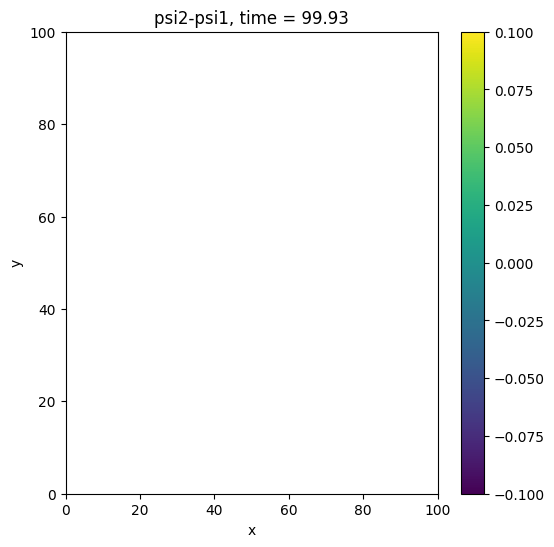

In [4]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    streamfunction = plt.pcolor(X, Y, (psi2_save[n,:,:].T-psi1_save[n,:,:].T))
    # Specify the axis limits and labels
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('psi2-psi1, time = {0:.2f}'.format(t_save[n]))
    return (streamfunction,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 1.5 Student investigation
<a id='section1pt5'></a>
In lectures, we found growing solutions of the form

$$ \psi_{1,2}=Re\left[\hat{\psi}_{1,2}e^{ikx+\sigma t}\right], $$

where

$$ \sigma = Uk \left(\frac{2/R_d^2-k^2}{2/R_d^2+k^2}\right)^{1/2}, $$

is the exponential growth rate, $R_d=\sqrt{g'H}/f_0$ is the deformation radius in each layer, and $k$ is the wavenumber in the $x$ direction where $\lambda=2\pi/k$ is the wavelength.

In the box below, compare the result of the simulation with what you would expect based on the growth rate given above. Comment on the possible reasons for any differences. Discuss the behaviour of the flow in the simulation at later times and comment on the relevance to storms in the atmosphere.

**expectations based on the growth rate given above**

Given the expression for $\sigma$, we would expect growth of instabilities with horizontal wavenumber $k$ satisfying:

$$
k < \sqrt{2}/R_d
$$

which means that, if we substitute $\lambda = 2\pi/k$ we see that, for an instability to grow, it must have wavelength satisfying

$$
\lambda > \pi\sqrt{2R_d}
$$

Plotting $\sigma$ against $k$ shows that, in the region $k \in (0, \sqrt{R_d})$, $\sigma$ is strictly increasing in $k$ and hence the maximum growth rate is achieved at the largest possible $k$ (or equivalently the least possible $\lambda$). Thus we expect growth of instabilities with wavelength

$$
\lambda_c = \pi\sqrt{2R_d}
$$

With the default parameters of $R_d = R_{d1} = R_{d2} = 3$, we would expect $\lambda_c\approx 13.3$ and we do indeed see a growing instability with width somewhere in the region of $15$ as expected.

**discussion of the behaviour of the flow at later times**

At around $t=55$, we see the growing modes begin to break down, with velocities in the $x$ direction breaking down the large instability and we see eddies forming. In the atmosphere, this would correspond to the formation of storm cells.

In [ ]:
## plotting sigma against k

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 6))

R_d = 3
A = 2 / R_d
U = 1

def sigma(k):

    return U * k * ((A - k**2) / (A + k**2))

x = np.linspace(0, 10, 20)[1:]

ax.plot(x, sigma(x))

## 2. Jet stream and the dimensional QG equations

The configuration in the previous section illustrates baroclinic instability, but the setup is quite idealized. In particular, we assumed that the Coriolis parameter and the initial velocity were constant. In the atmosphere there is are strong winds at the top of the troposphere in a band called the jet stream. The jet stream is several hundred kilometers wide with wind speeds that can exceed 100 miles per hour (roughly 50 m/s). A variable Coriolis parameter is important for constraining the jet dynamics. If we use $f=f_0+\beta y$, then the equations for $q_1$ and $q_2$ become:

$$ \partial_t(q_1) + U_1 \partial_x(q_1) + \partial_x(\psi_1)\left(\beta + \frac{U_1-U_2}{R_{d1}^2}\right)+\nu_4 \nabla^4 q_1 = - J(\psi_1, q_1), $$

$$ \partial_t(q_2) + U_2 \partial_x(q_2) + \partial_x(\psi_2)\left(\beta + \frac{U_2-U_1}{R_{d2}^2}\right)+\nu_4 \nabla^4 q_2 = - J(\psi_2, q_2). $$

Here, we have also switched from a viscous term to a 'hyperviscous' term, where $-\nabla^2 q_{1,2}$ has been replaced by $\nabla^4 q_{1,2}$ where $\nabla^4=(\nabla^2)^2=(\partial^2_x+\partial^2_y)^2$. Using a hyperviscosity is useful because it acts to preferentially damp small scale motions (with large horizontal wavenumbers), while having less influence on the larger scale motions (with small horizontal wavenumbers). It is useful in this case since we would like the jet not to be strongly influenced by viscosity.

We can simulate baroclinic instability on the jet stream by localizing the north/south gradient in the QG potential voriticty in the center of our computational domain. However, since our boundary conditions are periodic, we need the potential vorticity that we solve for to be equal at the northern and southern boundaries. We can accomplish this with the following trick. For our initial condition, let the total potential vorticity in layer 1 be:

$$ q_1 = Q_1 tanh\left(\frac{y-Ly/2}{w}\right) $$

where $Ly$ is the domain size, $Q_1$ is a constant dimensional amplitude and $w$ is the jet width. Clearly $q_1$ isn't periodic in the y-direction. Instead, we can impose a uniform background potential vorticity gradient (as we did in Section 1 above) and solve for the departure from this background gradient. We can then set the amplitude of the background gradient to make the <em>departure</em> from the background gradient periodic. Specifically, the departure from the background potential vorticity gradient will be:

$$ q_1 = Q_1 (tanh\left(\frac{y-Ly/2}{w}\right) - \frac{y-Ly/2}{Ly/2}) $$

which is periodic in $y$ (check for yourself if you aren't sure), and the background potential voricity gradient will be $2Q_1/Ly$ which then ensures that the total PV is the tanh function defined above.

### 2.1 Dedalus script

The script below sets up and solves the 2-layer QG equations in dimensional units (kilometers for x, y and seconds for time). The size of the box is 30,000 km in the x-direction and 10,000 km in the y-direction. This roughly corresponds to the Northern Hemisphere, although it is important to note that the analogy is only approximate since we are still solvin the equations in a Cartesian geometry and not a sphere.

Run the script below and comment on the results and the behavior of the jet stream in the text box below the script. You can also try changing some of the parameters at the top of the script to see how the result change.

Note that the script will likely take a few minutes to run.  Coordinate with the other members of your group so that you can each run a different case.

In [2]:
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 4s, Rate: 1.2e+01/s


2025-12-04 23:20:21,344 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 4s, Rate: 1.2e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 1.9e+01/s


2025-12-04 23:20:21,534 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 1.9e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 2s, Rate: 1.8e+01/s


2025-12-04 23:20:21,806 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 2s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 1.9e+01/s


2025-12-04 23:20:22,047 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 1.9e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.0e+01/s


2025-12-04 23:20:22,256 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.0e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.2e+01/s


2025-12-04 23:20:22,423 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.2e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.2e+01/s


2025-12-04 23:20:22,634 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.2e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 2s, Remaining: 1s, Rate: 2.1e+01/s


2025-12-04 23:20:22,894 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 2s, Remaining: 1s, Rate: 2.1e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 2.0e+01/s


2025-12-04 23:20:23,263 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 2.0e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.0e+01/s


2025-12-04 23:20:23,537 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.0e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.0e+01/s


2025-12-04 23:20:23,686 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.0e+01/s


INFO:__main__:Starting main loop


2025-12-04 23:20:23,853 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-12-04 23:20:24,499 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-12-04 23:20:25,730 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-12-04 23:20:27,110 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-12-04 23:20:28,216 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-12-04 23:20:29,394 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-12-04 23:20:30,831 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-12-04 23:20:32,679 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-12-04 23:20:33,707 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-12-04 23:20:34,544 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-12-04 23:20:35,250 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-12-04 23:20:35,787 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-12-04 23:20:36,335 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-12-04 23:20:36,855 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-12-04 23:20:37,427 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-12-04 23:20:37,939 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-12-04 23:20:38,500 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-12-04 23:20:39,016 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-12-04 23:20:39,578 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-12-04 23:20:40,115 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-12-04 23:20:40,647 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-12-04 23:20:41,183 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-12-04 23:20:41,705 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-12-04 23:20:42,232 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-12-04 23:20:42,782 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-12-04 23:20:43,366 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-12-04 23:20:43,890 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-12-04 23:20:44,408 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-12-04 23:20:44,934 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-12-04 23:20:45,766 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-12-04 23:20:46,563 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-12-04 23:20:47,451 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-12-04 23:20:47,997 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-12-04 23:20:48,532 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-12-04 23:20:49,057 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-12-04 23:20:49,564 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-12-04 23:20:50,098 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-12-04 23:20:50,644 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-12-04 23:20:51,170 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-12-04 23:20:51,680 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-12-04 23:20:52,215 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-12-04 23:20:52,723 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-12-04 23:20:53,246 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-12-04 23:20:53,759 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-12-04 23:20:54,285 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-12-04 23:20:54,798 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-12-04 23:20:55,329 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-12-04 23:20:55,850 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-12-04 23:20:56,382 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-12-04 23:20:56,886 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-12-04 23:20:57,417 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-12-04 23:20:58,221 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-12-04 23:20:59,020 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-12-04 23:20:59,887 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-12-04 23:21:00,488 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-12-04 23:21:01,021 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-12-04 23:21:01,556 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-12-04 23:21:02,072 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-12-04 23:21:02,613 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-12-04 23:21:03,157 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-12-04 23:21:03,688 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-12-04 23:21:04,205 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-12-04 23:21:04,742 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-12-04 23:21:05,247 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-12-04 23:21:05,775 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-12-04 23:21:06,323 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-12-04 23:21:06,847 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-12-04 23:21:07,350 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-12-04 23:21:07,873 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-12-04 23:21:08,384 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-12-04 23:21:08,904 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-12-04 23:21:09,413 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-12-04 23:21:09,935 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-12-04 23:21:10,729 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-12-04 23:21:11,550 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-12-04 23:21:12,405 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-12-04 23:21:13,019 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-12-04 23:21:13,522 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-12-04 23:21:14,039 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-12-04 23:21:14,570 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-12-04 23:21:15,101 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-12-04 23:21:15,622 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-12-04 23:21:16,148 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-12-04 23:21:16,644 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-12-04 23:21:17,161 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-12-04 23:21:17,667 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-12-04 23:21:18,205 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-12-04 23:21:18,710 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-12-04 23:21:19,224 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-12-04 23:21:19,750 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-12-04 23:21:20,353 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-12-04 23:21:20,867 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-12-04 23:21:21,390 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-12-04 23:21:21,899 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-12-04 23:21:22,443 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-12-04 23:21:23,192 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-12-04 23:21:24,007 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-12-04 23:21:24,867 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-12-04 23:21:25,518 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-12-04 23:21:26,069 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-12-04 23:21:26,601 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-12-04 23:21:27,103 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-12-04 23:21:27,653 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-12-04 23:21:28,168 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-12-04 23:21:28,698 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-12-04 23:21:29,203 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-12-04 23:21:29,749 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-12-04 23:21:30,334 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-12-04 23:21:30,864 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-12-04 23:21:31,376 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-12-04 23:21:31,900 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-12-04 23:21:32,419 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-12-04 23:21:32,970 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-12-04 23:21:33,490 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-12-04 23:21:34,015 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-12-04 23:21:34,537 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-12-04 23:21:35,064 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-12-04 23:21:35,863 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-12-04 23:21:36,702 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-12-04 23:21:37,578 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-12-04 23:21:38,233 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-12-04 23:21:38,763 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-12-04 23:21:39,300 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-12-04 23:21:39,835 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-12-04 23:21:40,374 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-12-04 23:21:40,881 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-12-04 23:21:41,405 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-12-04 23:21:41,906 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-12-04 23:21:42,443 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-12-04 23:21:42,920 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-12-04 23:21:42,922 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-12-04 23:21:42,927 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 2.688 sec


2025-12-04 23:21:42,929 solvers 0/1 INFO :: Setup time (init - iter 0): 2.688 sec


INFO:solvers:Warmup time (iter 0-10): 1.198 sec


2025-12-04 23:21:42,931 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.198 sec


INFO:solvers:Run time (iter 10-end): 77.87 sec


2025-12-04 23:21:42,932 solvers 0/1 INFO :: Run time (iter 10-end): 77.87 sec


INFO:solvers:CPU time (iter 10-end): 0.02163 cpu-hr


2025-12-04 23:21:42,933 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02163 cpu-hr


INFO:solvers:Speed: 2.315e+06 mode-stages/cpu-sec


2025-12-04 23:21:42,935 solvers 0/1 INFO :: Speed: 2.315e+06 mode-stages/cpu-sec


### 2.2 Visualization

The script below will visualize the results and create a movie showing the upper layer wind speed (the magnitude of the velocity vector (u1, v1)).

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-12-04 16:56:52,805 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpatsgdmcw/temp.m4v


2025-12-04 16:56:52,809 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpatsgdmcw/temp.m4v


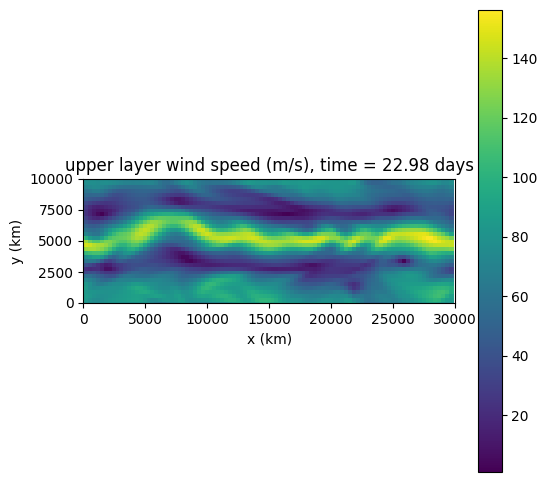

In [ ]:
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Describe the results in the box below. To what extent are the results qualitatively different from what you saw using the previous script? Comment on the interaction between the jet and the storms. Which features in the simulation do you think occur in the atmosphere? Do you see any features in the simulation that you think are unrealistic? If so, explain why you think those features are unrealistic.

**description of the results**

Initially we see instabilities forming, with those with wavelength around 4,000km emerging as the fastest growing mode. At around $t=3.5$ days, when the windspeed reaches somewhere between 100 and 120 m/s, we observe this instability break down into turbulent eddies, which continues until around $t=15$ days where a new dominant wavelength of around 12,500km emerges.

In this final state, we see a strong flow at the mid latitudes (around y=5,000m) moving in the positive x-direction, while there is flow in the negative x-direction above and below this.

**the extent to which the results are qualitatively different**

Compared to the previous case, the storm cells seem to dissipate much quicker. As well as this, the main instability in this case is spread out in the x direction as opposed to the y direction in the previous case (although this is due to initial conditions as opposed to the dynamics of the simulation).

The storms seem to get absorbed into the strong, central jet.


# 3. Forced QG flow

In the atmosphere, differential heating between the equator and poles maintains a north/south temperature gradient. This temperature gradient is represented by the north/south gradient in layer heights and potential vorticity in the 2-layer QG model. We can represent differential heating and cooling in the 2-layer QG model by adding terms that 'relax' the potential vorticity back to a prescribed field.

### 3.1 Student investigation
<a id='section3pt1'></a>

In the code box below, copy the code from Part 2 and modify it to include the following terms:

$$ \frac{\partial q_1}{\partial t} + \ldots = \ldots - \frac{1}{\tau}\left(q_1 - q_1(t=0)\right) $$

$$ \frac{\partial q_2}{\partial t} + \ldots = \ldots - \frac{1}{\tau}\left(q_2 - q_2(t=0)\right) $$

where $q_i(t=0)$ are the initial conditions (q1_ic and q2_ic in the script) and $\tau$ is a timescale which you should specify. A timescale of $\tau=36$ hours should be a good starting point. In the absence of any other terms, this additional forcing term will cause $q_1$ and $q_2$ to 'relax' exponentially back to the initial conditions with an e-folding timescale equal to $\tau$.

Set up a set of numerical experiments to explore the nonlinear interactions between the storms and the jet. For example, you can chose to systematically vary $\tau$, or q1_ic and q2_ic to represent weaker/stronger differential heating. Qualitatively comment on your findings.

In [9]:
## NEWER ONE

# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

## new params
tau = 36*60*60

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1) - (1/tau)*(q1-q1_ic)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2) - (1/tau)*(q2-q2_ic)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 1.7e+01/s


2025-12-05 12:03:38,566 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 3s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 3s, Rate: 1.7e+01/s


2025-12-05 12:03:38,799 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 3s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 2s, Rate: 1.7e+01/s


2025-12-05 12:03:39,108 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 2s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 1.8e+01/s


2025-12-05 12:03:39,338 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 2s, Rate: 1.7e+01/s


2025-12-05 12:03:39,674 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 2s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 1.8e+01/s


2025-12-05 12:03:39,924 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 1.8e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 1.9e+01/s


2025-12-05 12:03:40,052 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 1.9e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 2s, Remaining: 1s, Rate: 2.0e+01/s


2025-12-05 12:03:40,214 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 2s, Remaining: 1s, Rate: 2.0e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 2.2e+01/s


2025-12-05 12:03:40,347 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 2.2e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.3e+01/s


2025-12-05 12:03:40,495 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.3e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.3e+01/s


2025-12-05 12:03:40,580 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.3e+01/s


INFO:__main__:Starting main loop


2025-12-05 12:03:40,591 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-12-05 12:03:40,761 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-12-05 12:03:41,688 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-12-05 12:03:42,590 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-12-05 12:03:43,496 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-12-05 12:03:44,161 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-12-05 12:03:44,857 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-12-05 12:03:45,450 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-12-05 12:03:46,046 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-12-05 12:03:46,654 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-12-05 12:03:47,328 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-12-05 12:03:47,975 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-12-05 12:03:48,570 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-12-05 12:03:49,237 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-12-05 12:03:49,947 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-12-05 12:03:50,635 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-12-05 12:03:51,241 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-12-05 12:03:51,828 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-12-05 12:03:52,394 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-12-05 12:03:52,985 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-12-05 12:03:53,740 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-12-05 12:03:54,793 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-12-05 12:03:55,871 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-12-05 12:03:56,691 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-12-05 12:03:57,411 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-12-05 12:03:58,116 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-12-05 12:03:58,710 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-12-05 12:03:59,397 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-12-05 12:04:00,110 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-12-05 12:04:00,705 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-12-05 12:04:01,304 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-12-05 12:04:01,885 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-12-05 12:04:02,495 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-12-05 12:04:03,056 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-12-05 12:04:03,653 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-12-05 12:04:04,241 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-12-05 12:04:04,844 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-12-05 12:04:05,443 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-12-05 12:04:06,020 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-12-05 12:04:06,863 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-12-05 12:04:07,862 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-12-05 12:04:08,968 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-12-05 12:04:09,700 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-12-05 12:04:10,431 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-12-05 12:04:11,156 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-12-05 12:04:11,887 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-12-05 12:04:12,556 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-12-05 12:04:13,193 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-12-05 12:04:13,806 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-12-05 12:04:14,444 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-12-05 12:04:15,190 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-12-05 12:04:15,800 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-12-05 12:04:16,395 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-12-05 12:04:16,994 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-12-05 12:04:17,611 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-12-05 12:04:18,329 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-12-05 12:04:18,970 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-12-05 12:04:19,903 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-12-05 12:04:20,865 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-12-05 12:04:21,798 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-12-05 12:04:22,524 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-12-05 12:04:23,247 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-12-05 12:04:23,926 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-12-05 12:04:24,558 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-12-05 12:04:25,252 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-12-05 12:04:25,907 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-12-05 12:04:26,497 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-12-05 12:04:27,162 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-12-05 12:04:27,846 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-12-05 12:04:28,449 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-12-05 12:04:29,130 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-12-05 12:04:29,856 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-12-05 12:04:30,439 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-12-05 12:04:31,082 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-12-05 12:04:31,908 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-12-05 12:04:32,825 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-12-05 12:04:33,884 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-12-05 12:04:34,801 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-12-05 12:04:35,411 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-12-05 12:04:35,986 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-12-05 12:04:36,582 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-12-05 12:04:37,237 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-12-05 12:04:37,938 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-12-05 12:04:38,645 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-12-05 12:04:39,352 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-12-05 12:04:40,061 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-12-05 12:04:40,810 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-12-05 12:04:41,543 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-12-05 12:04:42,262 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-12-05 12:04:42,984 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-12-05 12:04:43,716 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-12-05 12:04:44,378 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-12-05 12:04:45,291 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-12-05 12:04:46,219 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-12-05 12:04:47,286 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-12-05 12:04:47,905 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-12-05 12:04:48,512 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-12-05 12:04:49,123 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-12-05 12:04:49,725 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-12-05 12:04:50,307 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-12-05 12:04:50,922 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-12-05 12:04:51,549 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-12-05 12:04:52,223 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-12-05 12:04:52,855 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-12-05 12:04:53,521 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-12-05 12:04:54,135 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-12-05 12:04:54,890 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-12-05 12:04:55,567 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-12-05 12:04:56,183 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-12-05 12:04:56,861 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-12-05 12:04:57,750 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-12-05 12:04:58,729 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-12-05 12:04:59,691 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-12-05 12:05:00,373 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-12-05 12:05:01,075 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-12-05 12:05:01,829 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-12-05 12:05:02,557 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-12-05 12:05:03,154 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-12-05 12:05:03,878 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-12-05 12:05:04,621 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-12-05 12:05:05,339 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-12-05 12:05:05,977 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-12-05 12:05:06,583 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-12-05 12:05:07,176 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-12-05 12:05:07,778 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-12-05 12:05:08,359 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-12-05 12:05:09,025 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-12-05 12:05:09,770 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-12-05 12:05:10,839 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-12-05 12:05:11,824 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-12-05 12:05:11,825 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-12-05 12:05:11,827 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 2.23 sec


2025-12-05 12:05:11,828 solvers 0/1 INFO :: Setup time (init - iter 0): 2.23 sec


INFO:solvers:Warmup time (iter 0-10): 0.6073 sec


2025-12-05 12:05:11,830 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.6073 sec


INFO:solvers:Run time (iter 10-end): 90.62 sec


2025-12-05 12:05:11,831 solvers 0/1 INFO :: Run time (iter 10-end): 90.62 sec


INFO:solvers:CPU time (iter 10-end): 0.02517 cpu-hr


2025-12-05 12:05:11,834 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02517 cpu-hr


INFO:solvers:Speed: 1.989e+06 mode-stages/cpu-sec


2025-12-05 12:05:11,835 solvers 0/1 INFO :: Speed: 1.989e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-12-05 12:05:12,044 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpofr4l6md/temp.m4v


2025-12-05 12:05:12,046 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpofr4l6md/temp.m4v


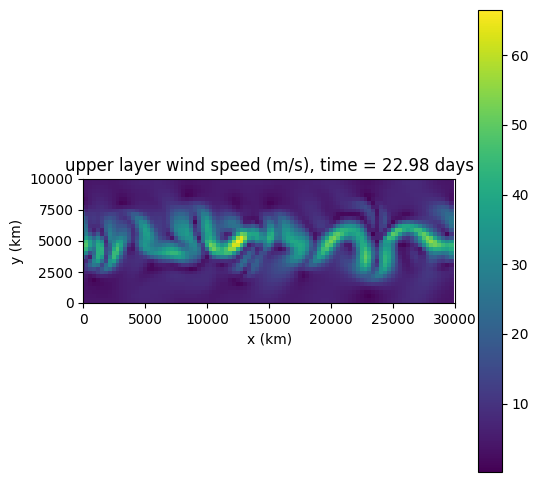

In [10]:
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

**comments on the new scenario with the additional damping term**

Under the initially suggested conditions (with $q_{ic}$ being as before, and taking $\tau=36$ hours), we see that the simulation proceeds much like before, except the instabilities don't break into the turbulent storm-like eddies as before, instead forming what I can only describe as a worm-shaped instability.